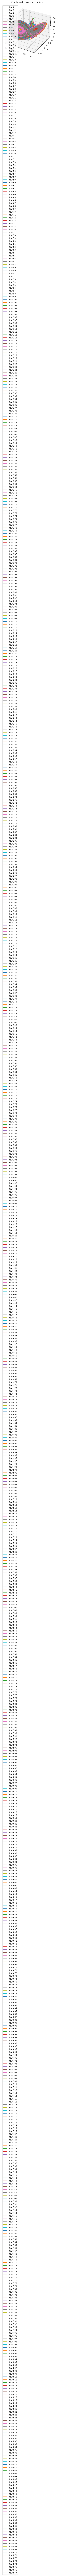

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pandas as pd

def lorenz_equations(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def apply_lorenz_equations(instance):
    columns = ['REB', 'AST', 'PTS']  # Using rebounds, assists, and points for Steph Curry
    initial_conditions = [instance[col] for col in columns]
    t_span = (0, 25)
    t_eval = np.linspace(*t_span, 1000)

    solution = solve_ivp(
        lorenz_equations,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval
    )

    return solution

dataset = pd.read_csv("E:\CHAOS\Stephen Curry Stats.csv")

# Plot combined Lorenz attractors for all rows in the dataset
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for index, row in dataset.iterrows():
    solution = apply_lorenz_equations(row)
    ax.plot(solution.y[0], solution.y[1], solution.y[2], label=f'Row {index}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Combined Lorenz Attractors')
ax.legend()
plt.show()


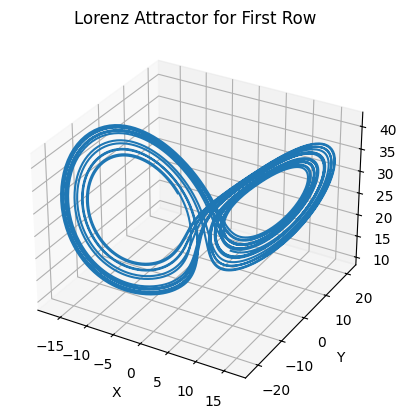

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pandas as pd

def lorenz_equations(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def apply_lorenz_equations(instance):
    columns = ['REB', 'AST', 'PTS']  # Using rebounds, assists, and points for Steph Curry
    initial_conditions = [instance[col] for col in columns]
    t_span = (0, 25)
    t_eval = np.linspace(*t_span, 5000)

    solution = solve_ivp(
        lorenz_equations,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval
    )

    return solution

dataset = pd.read_csv("E:\CHAOS\Stephen Curry Stats.csv")

# Take the first row from the dataset
first_row = dataset.iloc[0]

# Generate the trajectory for the first row
solution = apply_lorenz_equations(first_row)

# Store the subsequent states in X
X = solution.y.T[1:]  # Exclude the initial state

# Plot the Lorenz attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:, 0], X[:, 1], X[:, 2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor for First Row')
plt.show()


In [5]:
print(X)

[[ 2.24667912  7.11398829 13.88897694]
 [ 2.48736279  7.24569704 13.7893936 ]
 [ 2.72313985  7.39480655 13.70145813]
 ...
 [-4.87833856 -0.27498134 29.01286029]
 [-4.65322958 -0.25400487 28.63475527]
 [-4.4383169  -0.24256199 28.26100652]]


In [3]:
# Replace X_train, Y_train, and X with the values obtained previously


train_steps=2000
warm_steps=1000
test_steps=2000


In [29]:
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.hyper import research
import pandas as pd
import json
import numpy as np
# Load your dataset

# Define the objective function
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):

    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed
    
    losses = []
    r2s = []
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(units=500,
                              sr=sr,
                              lr=lr,
                              input_scaling=0.6,
                              seed=45,
                              input_connectivity=0.7,
                             )

        readout = Ridge(ridge=1e-7)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_val)

        loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_val, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}
# Define the hyperopt configuration
hyperopt_config = {
    "exp": "hyperopt-stephen-curry",
    "hp_max_evals": 200,
    "hp_method": "random",
    "seed": 0,
    "instances_per_trial": 3,
    "input_connectivity2":0,
    "hp_space": {
        "N": ["choice", 500],
        "sr": ["loguniform",1e-2, 10],
        "lr": ["loguniform", 1e-3, 1.0],
        "iss": ["choice", 0.9],
        "ridge": ["choice", 1e-7],
        "seed": ["choice", 45]
    }
}
import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [30]:
# Define the training set
X_train = X[:train_steps + warm_steps - 1]
Y_train = X[1:train_steps + warm_steps]
X_test = X[train_steps+warm_steps : -1]
y_test = X[train_steps+warm_steps + 1:]
# Run hyperparameter optimization using the research function
best_params = research(objective, ((X_train, Y_train), (X_test, y_test)), f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-620:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-620: 603it [00:00, 6028.84it/s]           
Running Model-620: 1517it [00:00, 7856.43it/s]
Running Model-620: 2434it [00:00, 8456.09it/s]
Running Model-620: 2999it [00:00, 8329.02it/s]
Running Model-620: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-620...                              
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-620:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-620: 1125it [00:00, 11142.58it/s]         
Running Model-620: 1998it [00:00, 10143.52it/s]
Running Model-621:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-621: 1090it [00:00, 10790.85it/s]         
Running Model-621: 2170it [00:00, 10256.87it/s]
Running Model-621: 2999it [00:00, 9771.13it/s] 
Running Model-621: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-621...                              
  0%|          | 0/200 [00:01<?, ?trial/s, best loss=?]

Running Model-621:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-621: 995it [00:00, 9949.80it/s]           
Running Model-621: 1990it [00:00, 9556.28it/s]
Running Model-621: 1998it [00:00, 9465.51it/s]
Running Model-622:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-622: 954it [00:00, 9538.12it/s]           
Running Model-622: 1917it [00:00, 9537.56it/s]
Running Model-622: 2871it [00:00, 9086.86it/s]
Running Model-622: 2999it [00:00, 9170.98it/s]
Running Model-622: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-622...                              
  0%|          | 0/200 [00:01<?, ?trial/s, best loss=?]

Running Model-622:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-622: 1016it [00:00, 10060.40it/s]         
Running Model-622: 1998it [00:00, 9609.38it/s] 


  0%|          | 1/200 [00:02<07:11,  2.17s/trial, best loss: 0.20385011565379438]

Running Model-623:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-623: 823it [00:00, 8224.16it/s]           
Running Model-623: 1739it [00:00, 8725.44it/s]
Running Model-623: 2672it [00:00, 8998.37it/s]
Running Model-623: 2999it [00:00, 9003.74it/s]
Running Model-623: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-623...                                                         
  0%|          | 1/200 [00:02<07:11,  2.17s/trial, best loss: 0.20385011565379438]

Running Model-623:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-623: 941it [00:00, 9323.45it/s]           
Running Model-623: 1905it [00:00, 9504.24it/s]
Running Model-623: 1998it [00:00, 9424.42it/s]
Running Model-624:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-624: 882it [00:00, 8813.01it/s]           
Running Model-624: 1764it [00:00, 6434.04it/s]
Running Model-624: 2616it [00:00, 7226.29it/s]
Running Model-624: 2999it [00:00, 7313.38it/s]
Running Model-624: 100%|##########| 1/1 [00:00<00:00,  2.34it/s]


Fitting node Ridge-624...                                                         
  0%|          | 1/200 [00:03<07:11,  2.17s/trial, best loss: 0.20385011565379438]

Running Model-624:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-624: 944it [00:00, 9347.04it/s]           
Running Model-624: 1930it [00:00, 9591.53it/s]
Running Model-624: 1998it [00:00, 9514.51it/s]
Running Model-625:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-625: 919it [00:00, 9184.25it/s]           
Running Model-625: 1852it [00:00, 9218.35it/s]
Running Model-625: 2856it [00:00, 9590.01it/s]
Running Model-625: 2999it [00:00, 9429.08it/s]
Running Model-625: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-625...                                                         
  0%|          | 1/200 [00:04<07:11,  2.17s/trial, best loss: 0.20385011565379438]

Running Model-625:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-625: 993it [00:00, 9832.30it/s]           
Running Model-625: 1998it [00:00, 9941.04it/s]


  1%|          | 2/200 [00:04<07:22,  2.23s/trial, best loss: 0.13689376955294635]

Running Model-626:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-626: 966it [00:00, 9652.21it/s]           
Running Model-626: 1932it [00:00, 9172.84it/s]
Running Model-626: 2851it [00:00, 8643.83it/s]
Running Model-626: 2999it [00:00, 8793.56it/s]
Running Model-626: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-626...                                                         
  1%|          | 2/200 [00:04<07:22,  2.23s/trial, best loss: 0.13689376955294635]

Running Model-626:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-626: 1014it [00:00, 10038.36it/s]         
Running Model-626: 1998it [00:00, 9990.07it/s] 
Running Model-627:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-627: 901it [00:00, 8922.74it/s]           
Running Model-627: 1991it [00:00, 10027.74it/s]
Running Model-627: 2994it [00:00, 9592.07it/s] 
Running Model-627: 2999it [00:00, 9523.92it/s]
Running Model-627: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-627...                                                         
  1%|          | 2/200 [00:05<07:22,  2.23s/trial, best loss: 0.13689376955294635]

Running Model-627:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-627: 994it [00:00, 9842.86it/s]           
Running Model-627: 1998it [00:00, 9990.62it/s]
Running Model-628:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-628: 919it [00:00, 9099.28it/s]           
Running Model-628: 1886it [00:00, 9381.53it/s]
Running Model-628: 2999it [00:00, 9963.41it/s]
Running Model-628: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-628...                                                         
  1%|          | 2/200 [00:06<07:22,  2.23s/trial, best loss: 0.13689376955294635]

Running Model-628:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-628: 1163it [00:00, 11518.35it/s]         
Running Model-628: 1998it [00:00, 11485.12it/s]


  2%|▏         | 3/200 [00:06<07:05,  2.16s/trial, best loss: 0.015237076809553074]

Running Model-629:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-629: 965it [00:00, 9558.13it/s]           
Running Model-629: 1921it [00:00, 9447.00it/s]
Running Model-629: 2999it [00:00, 10030.01it/s]
Running Model-629: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-629...                                                          
  2%|▏         | 3/200 [00:06<07:05,  2.16s/trial, best loss: 0.015237076809553074]

Running Model-629:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-629: 895it [00:00, 8861.67it/s]           
Running Model-629: 1782it [00:00, 8764.18it/s]
Running Model-629: 1998it [00:00, 8611.21it/s]
Running Model-630:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-630: 1097it [00:00, 10868.87it/s]         
Running Model-630: 2184it [00:00, 10677.99it/s]
Running Model-630: 2999it [00:00, 10710.76it/s]
Running Model-630: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-630...                                                          
  2%|▏         | 3/200 [00:07<07:05,  2.16s/trial, best loss: 0.015237076809553074]

Running Model-630:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-630: 1155it [00:00, 11543.21it/s]         
Running Model-630: 1998it [00:00, 10627.90it/s]
Running Model-631:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-631: 1069it [00:00, 10587.23it/s]         
Running Model-631: 2128it [00:00, 9629.08it/s] 
Running Model-631: 2999it [00:00, 9963.01it/s]
Running Model-631: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-631...                                                          
  2%|▏         | 3/200 [00:08<07:05,  2.16s/trial, best loss: 0.015237076809553074]

Running Model-631:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-631: 957it [00:00, 9568.87it/s]           
Running Model-631: 1956it [00:00, 9760.32it/s]
Running Model-631: 1998it [00:00, 9652.37it/s]


  2%|▏         | 4/200 [00:08<06:52,  2.10s/trial, best loss: 0.015237076809553074]

Running Model-632:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-632: 1085it [00:00, 10743.78it/s]         
Running Model-632: 2166it [00:00, 10782.45it/s]
Running Model-632: 2999it [00:00, 10635.14it/s]
Running Model-632: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-632...                                                          
  2%|▏         | 4/200 [00:08<06:52,  2.10s/trial, best loss: 0.015237076809553074]

Running Model-632:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-632: 1198it [00:00, 11862.50it/s]         
Running Model-632: 1998it [00:00, 11225.95it/s]
Running Model-633:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-633: 882it [00:00, 8733.84it/s]           
Running Model-633: 1763it [00:00, 8776.63it/s]
Running Model-633: 2796it [00:00, 9442.54it/s]
Running Model-633: 2999it [00:00, 9342.87it/s]
Running Model-633: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-633...                                                          
  2%|▏         | 4/200 [00:09<06:52,  2.10s/trial, best loss: 0.015237076809553074]

Running Model-633:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-633: 1170it [00:00, 11583.82it/s]         
Running Model-633: 1998it [00:00, 11483.13it/s]
Running Model-634:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-634: 1054it [00:00, 10445.23it/s]         
Running Model-634: 2099it [00:00, 9810.05it/s] 
Running Model-634: 2999it [00:00, 9930.58it/s]
Running Model-634: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-634...                                                          
  2%|▏         | 4/200 [00:10<06:52,  2.10s/trial, best loss: 0.015237076809553074]

Running Model-634:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-634: 943it [00:00, 9425.60it/s]           
Running Model-634: 1998it [00:00, 10568.66it/s]


  2%|▎         | 5/200 [00:10<06:40,  2.05s/trial, best loss: 0.015237076809553074]

Running Model-635:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-635: 897it [00:00, 8881.29it/s]           
Running Model-635: 1822it [00:00, 9044.26it/s]
Running Model-635: 2756it [00:00, 9135.78it/s]
Running Model-635: 2999it [00:00, 9199.57it/s]
Running Model-635: 100%|##########| 1/1 [00:00<00:00,  2.94it/s]


Fitting node Ridge-635...                                                          
  2%|▎         | 5/200 [00:10<06:40,  2.05s/trial, best loss: 0.015237076809553074]

Running Model-635:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-635: 960it [00:00, 9598.98it/s]           
Running Model-635: 1950it [00:00, 9719.45it/s]
Running Model-635: 1998it [00:00, 9605.47it/s]
Running Model-636:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-636: 944it [00:00, 9434.66it/s]           
Running Model-636: 2080it [00:00, 10506.44it/s]
Running Model-636: 2999it [00:00, 10166.14it/s]
Running Model-636: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-636...                                                          
  2%|▎         | 5/200 [00:11<06:40,  2.05s/trial, best loss: 0.015237076809553074]

Running Model-636:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-636: 1222it [00:00, 12102.29it/s]         
Running Model-636: 1998it [00:00, 11548.65it/s]
Running Model-637:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-637: 924it [00:00, 9148.68it/s]           
Running Model-637: 1999it [00:00, 10086.49it/s]
Running Model-637: 2999it [00:00, 9673.84it/s] 
Running Model-637: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-637...                                                          
  2%|▎         | 5/200 [00:12<06:40,  2.05s/trial, best loss: 0.015237076809553074]

Running Model-637:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-637: 1225it [00:00, 12128.27it/s]         
Running Model-637: 1998it [00:00, 11291.55it/s]


  3%|▎         | 6/200 [00:12<06:34,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-638:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-638: 820it [00:00, 8192.60it/s]           
Running Model-638: 1727it [00:00, 8660.15it/s]
Running Model-638: 2646it [00:00, 8899.13it/s]
Running Model-638: 2999it [00:00, 8869.76it/s]
Running Model-638: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


Fitting node Ridge-638...                                                          
  3%|▎         | 6/200 [00:12<06:34,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-638:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-638: 980it [00:00, 9703.12it/s]           
Running Model-638: 1998it [00:00, 10742.51it/s]
Running Model-639:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-639: 1075it [00:00, 10645.62it/s]         
Running Model-639: 2150it [00:00, 10704.83it/s]
Running Model-639: 2999it [00:00, 10559.63it/s]
Running Model-639: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-639...                                                          
  3%|▎         | 6/200 [00:13<06:34,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-639:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-639: 1186it [00:00, 11742.90it/s]         
Running Model-639: 1998it [00:00, 11616.17it/s]
Running Model-640:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-640: 967it [00:00, 9577.82it/s]           
Running Model-640: 2094it [00:00, 10567.75it/s]
Running Model-640: 2999it [00:00, 10488.42it/s]
Running Model-640: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-640...                                                          
  3%|▎         | 6/200 [00:14<06:34,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-640:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-640: 943it [00:00, 9423.90it/s]           
Running Model-640: 1998it [00:00, 10512.09it/s]


  4%|▎         | 7/200 [00:14<06:31,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-641:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-641: 1043it [00:00, 10422.06it/s]         
Running Model-641: 2112it [00:00, 10517.81it/s]
Running Model-641: 2999it [00:00, 10631.94it/s]
Running Model-641: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-641...                                                          
  4%|▎         | 7/200 [00:14<06:31,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-641:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-641: 1174it [00:00, 11624.77it/s]         
Running Model-641: 1998it [00:00, 10687.41it/s]
Running Model-642:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-642: 875it [00:00, 8665.12it/s]           
Running Model-642: 1791it [00:00, 8950.31it/s]
Running Model-642: 2701it [00:00, 9018.15it/s]
Running Model-642: 2999it [00:00, 8976.89it/s]
Running Model-642: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-642...                                                          
  4%|▎         | 7/200 [00:15<06:31,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-642:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-642: 1196it [00:00, 11842.97it/s]         
Running Model-642: 1998it [00:00, 11622.78it/s]
Running Model-643:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-643: 1086it [00:00, 10754.73it/s]         
Running Model-643: 2168it [00:00, 10792.96it/s]
Running Model-643: 2999it [00:00, 10827.24it/s]
Running Model-643: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-643...                                                          
  4%|▎         | 7/200 [00:16<06:31,  2.03s/trial, best loss: 0.015237076809553074]

Running Model-643:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-643: 1107it [00:00, 11060.44it/s]         
Running Model-643: 1998it [00:00, 11156.18it/s]


  4%|▍         | 8/200 [00:16<06:27,  2.02s/trial, best loss: 0.015237076809553074]

Running Model-644:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-644: 1037it [00:00, 10369.81it/s]         
Running Model-644: 2074it [00:00, 9633.47it/s] 
Running Model-644: 2999it [00:00, 10097.56it/s]
Running Model-644: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-644...                                                          
  4%|▍         | 8/200 [00:16<06:27,  2.02s/trial, best loss: 0.015237076809553074]

Running Model-644:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-644: 987it [00:00, 9772.45it/s]           
Running Model-644: 1998it [00:00, 10684.65it/s]
Running Model-645:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-645: 1084it [00:00, 10838.95it/s]         
Running Model-645: 2168it [00:00, 10015.21it/s]
Running Model-645: 2999it [00:00, 9832.69it/s] 
Running Model-645: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-645...                                                          
  4%|▍         | 8/200 [00:17<06:27,  2.02s/trial, best loss: 0.015237076809553074]

Running Model-645:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-645: 932it [00:00, 9319.70it/s]           
Running Model-645: 1903it [00:00, 9493.11it/s]
Running Model-645: 1998it [00:00, 9424.61it/s]
Running Model-646:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-646: 977it [00:00, 9769.24it/s]           
Running Model-646: 1954it [00:00, 9490.54it/s]
Running Model-646: 2999it [00:00, 9996.01it/s]
Running Model-646: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-646...                                                          
  4%|▍         | 8/200 [00:18<06:27,  2.02s/trial, best loss: 0.015237076809553074]

Running Model-646:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-646: 972it [00:00, 9630.03it/s]           
Running Model-646: 1938it [00:00, 9644.34it/s]
Running Model-646: 1998it [00:00, 9606.17it/s]


  4%|▍         | 9/200 [00:18<06:30,  2.04s/trial, best loss: 0.015237076809553074]

Running Model-647:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-647: 854it [00:00, 8538.68it/s]           
Running Model-647: 1756it [00:00, 8819.72it/s]
Running Model-647: 2691it [00:00, 9061.34it/s]
Running Model-647: 2999it [00:00, 8977.60it/s]
Running Model-647: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-647...                                                          
  4%|▍         | 9/200 [00:19<06:30,  2.04s/trial, best loss: 0.015237076809553074]

Running Model-647:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-647: 1044it [00:00, 10337.77it/s]         
Running Model-647: 1998it [00:00, 10247.70it/s]
Running Model-648:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-648: 890it [00:00, 8899.86it/s]           
Running Model-648: 1945it [00:00, 9812.76it/s]
Running Model-648: 2926it [00:00, 9551.72it/s]
Running Model-648: 2999it [00:00, 9490.59it/s]
Running Model-648: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-648...                                                          
  4%|▍         | 9/200 [00:19<06:30,  2.04s/trial, best loss: 0.015237076809553074]

Running Model-648:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-648: 1151it [00:00, 11500.66it/s]         
Running Model-648: 1998it [00:00, 10571.71it/s]
Running Model-649:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-649: 1054it [00:00, 10539.48it/s]         
Running Model-649: 2108it [00:00, 9685.36it/s] 
Running Model-649: 2999it [00:00, 9996.99it/s]
Running Model-649: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-649...                                                          
  4%|▍         | 9/200 [00:20<06:30,  2.04s/trial, best loss: 0.015237076809553074]

Running Model-649:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-649: 878it [00:00, 8779.99it/s]           
Running Model-649: 1998it [00:00, 9985.32it/s]


  5%|▌         | 10/200 [00:20<06:30,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-650:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-650: 943it [00:00, 9425.31it/s]           
Running Model-650: 1886it [00:00, 9427.55it/s]
Running Model-650: 2854it [00:00, 9542.71it/s]
Running Model-650: 2999it [00:00, 9489.89it/s]
Running Model-650: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-650...                                                           
  5%|▌         | 10/200 [00:21<06:30,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-650:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-650: 1136it [00:00, 11249.22it/s]         
Running Model-650: 1998it [00:00, 11353.68it/s]
Running Model-651:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-651: 1097it [00:00, 10864.94it/s]         
Running Model-651: 2184it [00:00, 9990.14it/s] 
Running Model-651: 2999it [00:00, 9801.26it/s]
Running Model-651: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-651...                                                           
  5%|▌         | 10/200 [00:21<06:30,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-651:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-651: 1227it [00:00, 12151.52it/s]         
Running Model-651: 1998it [00:00, 11226.78it/s]
Running Model-652:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-652: 907it [00:00, 9067.95it/s]           
Running Model-652: 2029it [00:00, 10274.26it/s]
Running Model-652: 2999it [00:00, 10341.60it/s]
Running Model-652: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-652...                                                           
  5%|▌         | 10/200 [00:22<06:30,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-652:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-652: 926it [00:00, 9173.62it/s]           
Running Model-652: 1998it [00:00, 10301.92it/s]


  6%|▌         | 11/200 [00:22<06:24,  2.03s/trial, best loss: 0.013702695765532095]

Running Model-653:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-653: 1089it [00:00, 10780.19it/s]         
Running Model-653: 2168it [00:00, 10601.17it/s]
Running Model-653: 2999it [00:00, 9490.41it/s] 
Running Model-653: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-653...                                                           
  6%|▌         | 11/200 [00:23<06:24,  2.03s/trial, best loss: 0.013702695765532095]

Running Model-653:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-653: 1095it [00:00, 10849.03it/s]         
Running Model-653: 1998it [00:00, 11100.45it/s]
Running Model-654:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-654: 1097it [00:00, 10861.94it/s]         
Running Model-654: 2185it [00:00, 10809.63it/s]
Running Model-654: 2999it [00:00, 10377.49it/s]
Running Model-654: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-654...                                                           
  6%|▌         | 11/200 [00:23<06:24,  2.03s/trial, best loss: 0.013702695765532095]

Running Model-654:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-654: 911it [00:00, 9020.92it/s]           
Running Model-654: 1896it [00:00, 9451.41it/s]
Running Model-654: 1998it [00:00, 9337.01it/s]
Running Model-655:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-655: 904it [00:00, 8952.18it/s]           
Running Model-655: 1842it [00:00, 9202.55it/s]
Running Model-655: 2936it [00:00, 9993.72it/s]
Running Model-655: 2999it [00:00, 9737.24it/s]
Running Model-655: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-655...                                                           
  6%|▌         | 11/200 [00:24<06:24,  2.03s/trial, best loss: 0.013702695765532095]

Running Model-655:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-655: 996it [00:00, 9862.61it/s]           
Running Model-655: 1998it [00:00, 9989.62it/s]


  6%|▌         | 12/200 [00:24<06:25,  2.05s/trial, best loss: 0.013702695765532095]

Running Model-656:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-656: 882it [00:00, 8809.21it/s]           
Running Model-656: 1816it [00:00, 9069.56it/s]
Running Model-656: 2756it [00:00, 9218.30it/s]
Running Model-656: 2999it [00:00, 9253.64it/s]
Running Model-656: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-656...                                                           
  6%|▌         | 12/200 [00:25<06:25,  2.05s/trial, best loss: 0.013702695765532095]

Running Model-656:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-656: 924it [00:00, 9150.93it/s]           
Running Model-656: 1865it [00:00, 9301.26it/s]
Running Model-656: 1998it [00:00, 9380.51it/s]
Running Model-657:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-657: 867it [00:00, 8591.84it/s]           
Running Model-657: 1727it [00:00, 8496.28it/s]
Running Model-657: 2760it [00:00, 9326.51it/s]
Running Model-657: 2999it [00:00, 9116.97it/s]
Running Model-657: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-657...                                                           
  6%|▌         | 12/200 [00:25<06:25,  2.05s/trial, best loss: 0.013702695765532095]

Running Model-657:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-657: 977it [00:00, 9676.71it/s]           
Running Model-657: 1998it [00:00, 10572.88it/s]
Running Model-658:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-658: 1083it [00:00, 10727.80it/s]         
Running Model-658: 2156it [00:00, 10664.57it/s]
Running Model-658: 2999it [00:00, 10273.93it/s]
Running Model-658: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-658...                                                           
  6%|▌         | 12/200 [00:26<06:25,  2.05s/trial, best loss: 0.013702695765532095]

Running Model-658:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-658: 1112it [00:00, 11115.19it/s]         
Running Model-658: 1998it [00:00, 9697.20it/s] 


  6%|▋         | 13/200 [00:26<06:26,  2.07s/trial, best loss: 0.013702695765532095]

Running Model-659:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-659: 982it [00:00, 9819.52it/s]           
Running Model-659: 2017it [00:00, 10073.91it/s]
Running Model-659: 2999it [00:00, 10270.39it/s]
Running Model-659: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-659...                                                           
  6%|▋         | 13/200 [00:27<06:26,  2.07s/trial, best loss: 0.013702695765532095]

Running Model-659:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-659: 645it [00:00, 6449.48it/s]           
Running Model-659: 1514it [00:00, 7722.81it/s]
Running Model-659: 1998it [00:00, 7897.63it/s]
Running Model-660:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-660: 1123it [00:00, 11222.28it/s]         
Running Model-660: 2246it [00:00, 11031.98it/s]
Running Model-660: 2999it [00:00, 10708.03it/s]
Running Model-660: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-660...                                                           
  6%|▋         | 13/200 [00:27<06:26,  2.07s/trial, best loss: 0.013702695765532095]

Running Model-660:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-660: 1160it [00:00, 11492.38it/s]         
Running Model-660: 1998it [00:00, 10803.85it/s]
Running Model-661:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-661: 915it [00:00, 9065.76it/s]           
Running Model-661: 1883it [00:00, 9425.61it/s]
Running Model-661: 2940it [00:00, 9947.07it/s]
Running Model-661: 2999it [00:00, 9739.35it/s]
Running Model-661: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-661...                                                           
  6%|▋         | 13/200 [00:28<06:26,  2.07s/trial, best loss: 0.013702695765532095]

Running Model-661:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-661: 987it [00:00, 9767.13it/s]           
Running Model-661: 1972it [00:00, 9761.98it/s]
Running Model-661: 1998it [00:00, 9652.71it/s]


  7%|▋         | 14/200 [00:28<06:23,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-662:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-662: 905it [00:00, 9049.79it/s]           
Running Model-662: 2014it [00:00, 10241.55it/s]
Running Model-662: 2999it [00:00, 10305.75it/s]
Running Model-662: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-662...                                                           
  7%|▋         | 14/200 [00:29<06:23,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-662:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-662: 1195it [00:00, 11831.20it/s]         
Running Model-662: 1998it [00:00, 11162.39it/s]
Running Model-663:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-663: 1085it [00:00, 10744.49it/s]         
Running Model-663: 2160it [00:00, 10685.09it/s]
Running Model-663: 2999it [00:00, 10341.88it/s]
Running Model-663: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-663...                                                           
  7%|▋         | 14/200 [00:29<06:23,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-663:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-663: 1106it [00:00, 11058.88it/s]         
Running Model-663: 1998it [00:00, 10463.62it/s]
Running Model-664:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-664: 1111it [00:00, 10999.71it/s]         
Running Model-664: 2211it [00:00, 10748.34it/s]
Running Model-664: 2999it [00:00, 10377.73it/s]
Running Model-664: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-664...                                                           
  7%|▋         | 14/200 [00:30<06:23,  2.06s/trial, best loss: 0.013702695765532095]

Running Model-664:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-664: 950it [00:00, 9411.11it/s]           
Running Model-664: 1892it [00:00, 9147.73it/s]
Running Model-664: 1998it [00:00, 9083.46it/s]


  8%|▊         | 15/200 [00:30<06:17,  2.04s/trial, best loss: 0.013702695765532095]

Running Model-665:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-665: 1089it [00:00, 10879.92it/s]         
Running Model-665: 2177it [00:00, 9437.13it/s] 
Running Model-665: 2999it [00:00, 9398.52it/s]
Running Model-665: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-665...                                                           
  8%|▊         | 15/200 [00:31<06:17,  2.04s/trial, best loss: 0.013702695765532095]

Running Model-665:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-665: 921it [00:00, 9204.98it/s]           
Running Model-665: 1871it [00:00, 9378.37it/s]
Running Model-665: 1998it [00:00, 9334.33it/s]
Running Model-666:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-666: 876it [00:00, 8673.16it/s]           
Running Model-666: 1926it [00:00, 9686.80it/s]
Running Model-666: 2895it [00:00, 8993.90it/s]
Running Model-666: 2999it [00:00, 9033.25it/s]
Running Model-666: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-666...                                                           
  8%|▊         | 15/200 [00:32<06:17,  2.04s/trial, best loss: 0.013702695765532095]

Running Model-666:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-666: 950it [00:00, 9405.60it/s]           
Running Model-666: 1900it [00:00, 9407.89it/s]
Running Model-666: 1998it [00:00, 9380.10it/s]
Running Model-667:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-667: 859it [00:00, 8589.82it/s]           
Running Model-667: 1743it [00:00, 8736.88it/s]
Running Model-667: 2717it [00:00, 9151.57it/s]
Running Model-667: 2999it [00:00, 9034.68it/s]
Running Model-667: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-667...                                                           
  8%|▊         | 15/200 [00:32<06:17,  2.04s/trial, best loss: 0.013702695765532095]

Running Model-667:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-667: 587it [00:00, 5815.49it/s]           
Running Model-667: 1473it [00:00, 7596.92it/s]
Running Model-667: 1998it [00:00, 7774.68it/s]


  8%|▊         | 16/200 [00:33<06:25,  2.10s/trial, best loss: 0.013702695765532095]

Running Model-668:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-668: 848it [00:00, 8396.71it/s]           
Running Model-668: 1903it [00:00, 9602.54it/s]
Running Model-668: 2864it [00:00, 9268.25it/s]
Running Model-668: 2999it [00:00, 9171.70it/s]
Running Model-668: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-668...                                                           
  8%|▊         | 16/200 [00:33<06:25,  2.10s/trial, best loss: 0.013702695765532095]

Running Model-668:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-668: 881it [00:00, 8723.78it/s]           
Running Model-668: 1814it [00:00, 9078.75it/s]
Running Model-668: 1998it [00:00, 9000.65it/s]
Running Model-669:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-669: 1065it [00:00, 10544.57it/s]         
Running Model-669: 2120it [00:00, 9854.92it/s] 
Running Model-669: 2999it [00:00, 9705.48it/s]
Running Model-669: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-669...                                                           
  8%|▊         | 16/200 [00:34<06:25,  2.10s/trial, best loss: 0.013702695765532095]

Running Model-669:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-669: 1118it [00:00, 11064.00it/s]         
Running Model-669: 1998it [00:00, 11096.87it/s]
Running Model-670:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-670: 899it [00:00, 8902.75it/s]           
Running Model-670: 1997it [00:00, 10060.40it/s]
Running Model-670: 2999it [00:00, 9899.79it/s] 
Running Model-670: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-670...                                                           
  8%|▊         | 16/200 [00:34<06:25,  2.10s/trial, best loss: 0.013702695765532095]

Running Model-670:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-670: 978it [00:00, 9684.49it/s]           
Running Model-670: 1998it [00:00, 10040.94it/s]


  8%|▊         | 17/200 [00:35<06:23,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-671:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-671: 858it [00:00, 8574.61it/s]           
Running Model-671: 1765it [00:00, 8814.40it/s]
Running Model-671: 2687it [00:00, 8998.73it/s]
Running Model-671: 2999it [00:00, 9086.10it/s]
Running Model-671: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-671...                                                           
  8%|▊         | 17/200 [00:35<06:23,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-671:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-671: 991it [00:00, 9815.30it/s]           
Running Model-671: 1973it [00:00, 9759.32it/s]
Running Model-671: 1998it [00:00, 9652.64it/s]
Running Model-672:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-672: 929it [00:00, 9204.08it/s]           
Running Model-672: 1850it [00:00, 8795.32it/s]
Running Model-672: 2862it [00:00, 9381.30it/s]
Running Model-672: 2999it [00:00, 9285.19it/s]
Running Model-672: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-672...                                                           
  8%|▊         | 17/200 [00:36<06:23,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-672:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-672: 1172it [00:00, 11605.27it/s]         
Running Model-672: 1998it [00:00, 11224.90it/s]
Running Model-673:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-673: 874it [00:00, 8653.42it/s]           
Running Model-673: 1871it [00:00, 9424.36it/s]
Running Model-673: 2814it [00:00, 9258.55it/s]
Running Model-673: 2999it [00:00, 9229.01it/s]
Running Model-673: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-673...                                                           
  8%|▊         | 17/200 [00:37<06:23,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-673:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-673: 1063it [00:00, 10629.55it/s]         
Running Model-673: 1998it [00:00, 10463.95it/s]


  9%|▉         | 18/200 [00:37<06:21,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-674:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-674: 765it [00:00, 7648.09it/s]           
Running Model-674: 1635it [00:00, 8266.69it/s]
Running Model-674: 2620it [00:00, 8988.95it/s]
Running Model-674: 2999it [00:00, 8742.71it/s]
Running Model-674: 100%|##########| 1/1 [00:00<00:00,  2.78it/s]


Fitting node Ridge-674...                                                           
  9%|▉         | 18/200 [00:37<06:21,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-674:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-674: 630it [00:00, 6239.89it/s]           
Running Model-674: 1547it [00:00, 7955.08it/s]
Running Model-674: 1998it [00:00, 8125.26it/s]
Running Model-675:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-675: 888it [00:00, 8794.38it/s]           
Running Model-675: 1790it [00:00, 8879.33it/s]
Running Model-675: 2793it [00:00, 9398.06it/s]
Running Model-675: 2999it [00:00, 9314.48it/s]
Running Model-675: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-675...                                                           
  9%|▉         | 18/200 [00:38<06:21,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-675:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-675: 885it [00:00, 8764.07it/s]           
Running Model-675: 1836it [00:00, 9147.02it/s]
Running Model-675: 1998it [00:00, 9042.88it/s]
Running Model-676:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-676: 847it [00:00, 8386.65it/s]           
Running Model-676: 1827it [00:00, 9214.36it/s]
Running Model-676: 2771it [00:00, 9275.37it/s]
Running Model-676: 2999it [00:00, 9117.27it/s]
Running Model-676: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-676...                                                           
  9%|▉         | 18/200 [00:39<06:21,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-676:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-676: 865it [00:00, 8565.85it/s]           
Running Model-676: 1835it [00:00, 9230.21it/s]
Running Model-676: 1998it [00:00, 9165.46it/s]


 10%|▉         | 19/200 [00:39<06:26,  2.13s/trial, best loss: 0.013702695765532095]

Running Model-677:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-677: 936it [00:00, 9270.78it/s]           
Running Model-677: 1881it [00:00, 9375.27it/s]
Running Model-677: 2819it [00:00, 9048.33it/s]
Running Model-677: 2999it [00:00, 9144.39it/s]
Running Model-677: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-677...                                                           
 10%|▉         | 19/200 [00:39<06:26,  2.13s/trial, best loss: 0.013702695765532095]

Running Model-677:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-677: 940it [00:00, 9317.09it/s]           
Running Model-677: 1872it [00:00, 9259.72it/s]
Running Model-677: 1998it [00:00, 9210.47it/s]
Running Model-678:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-678: 892it [00:00, 8833.14it/s]           
Running Model-678: 1793it [00:00, 8884.35it/s]
Running Model-678: 2716it [00:00, 9040.34it/s]
Running Model-678: 2999it [00:00, 9005.64it/s]
Running Model-678: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-678...                                                           
 10%|▉         | 19/200 [00:40<06:26,  2.13s/trial, best loss: 0.013702695765532095]

Running Model-678:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-678: 989it [00:00, 9798.78it/s]           
Running Model-678: 1969it [00:00, 9517.45it/s]
Running Model-678: 1998it [00:00, 9425.05it/s]
Running Model-679:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-679: 960it [00:00, 9505.06it/s]           
Running Model-679: 1911it [00:00, 9344.09it/s]
Running Model-679: 2846it [00:00, 8540.99it/s]
Running Model-679: 2999it [00:00, 8645.17it/s]
Running Model-679: 100%|##########| 1/1 [00:00<00:00,  2.71it/s]


Fitting node Ridge-679...                                                           
 10%|▉         | 19/200 [00:41<06:26,  2.13s/trial, best loss: 0.013702695765532095]

Running Model-679:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-679: 891it [00:00, 8821.30it/s]           
Running Model-679: 1890it [00:00, 9451.21it/s]
Running Model-679: 1998it [00:00, 9336.53it/s]


 10%|█         | 20/200 [00:41<06:28,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-680:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-680: 948it [00:00, 9479.06it/s]           
Running Model-680: 1896it [00:00, 9054.50it/s]
Running Model-680: 2907it [00:00, 9523.91it/s]
Running Model-680: 2999it [00:00, 9372.03it/s]
Running Model-680: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-680...                                                           
 10%|█         | 20/200 [00:42<06:28,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-680:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-680: 1054it [00:00, 10533.38it/s]         
Running Model-680: 1998it [00:00, 9936.62it/s] 
Running Model-681:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-681: 1007it [00:00, 9979.15it/s]          
Running Model-681: 2005it [00:00, 9475.62it/s]
Running Model-681: 2955it [00:00, 8309.66it/s]
Running Model-681: 2999it [00:00, 8546.04it/s]
Running Model-681: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-681...                                                           
 10%|█         | 20/200 [00:42<06:28,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-681:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-681: 787it [00:00, 7797.96it/s]           
Running Model-681: 1893it [00:00, 9706.34it/s]
Running Model-681: 1998it [00:00, 9427.88it/s]
Running Model-682:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-682: 1032it [00:00, 10313.81it/s]         
Running Model-682: 2064it [00:00, 9690.44it/s] 
Running Model-682: 2999it [00:00, 9488.85it/s]
Running Model-682: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-682...                                                           
 10%|█         | 20/200 [00:43<06:28,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-682:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-682: 979it [00:00, 9693.47it/s]           
Running Model-682: 1998it [00:00, 10572.13it/s]


 10%|█         | 21/200 [00:43<06:27,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-683:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-683: 949it [00:00, 9397.25it/s]           
Running Model-683: 1889it [00:00, 9183.20it/s]
Running Model-683: 2808it [00:00, 9023.95it/s]
Running Model-683: 2999it [00:00, 9087.97it/s]
Running Model-683: 100%|##########| 1/1 [00:00<00:00,  2.89it/s]


Fitting node Ridge-683...                                                           
 10%|█         | 21/200 [00:44<06:27,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-683:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-683: 1045it [00:00, 10345.31it/s]         
Running Model-683: 1998it [00:00, 10800.89it/s]
Running Model-684:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-684: 875it [00:00, 8744.86it/s]           
Running Model-684: 1810it [00:00, 9100.54it/s]
Running Model-684: 2731it [00:00, 9150.50it/s]
Running Model-684: 2999it [00:00, 9059.66it/s]
Running Model-684: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-684...                                                           
 10%|█         | 21/200 [00:45<06:27,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-684:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-684: 870it [00:00, 8695.03it/s]           
Running Model-684: 1740it [00:00, 8450.15it/s]
Running Model-684: 1998it [00:00, 8536.14it/s]
Running Model-685:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-685: 875it [00:00, 8666.22it/s]           
Running Model-685: 1920it [00:00, 9655.67it/s]
Running Model-685: 2886it [00:00, 8465.09it/s]
Running Model-685: 2999it [00:00, 8618.95it/s]
Running Model-685: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-685...                                                           
 10%|█         | 21/200 [00:45<06:27,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-685:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-685: 857it [00:00, 8533.89it/s]           
Running Model-685: 1825it [00:00, 9206.37it/s]
Running Model-685: 1998it [00:00, 9147.06it/s]


 11%|█         | 22/200 [00:46<06:28,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-686:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-686: 818it [00:00, 8173.11it/s]           
Running Model-686: 1640it [00:00, 8157.60it/s]
Running Model-686: 2484it [00:00, 8285.16it/s]
Running Model-686: 2999it [00:00, 8283.23it/s]
Running Model-686: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-686...                                                           
 11%|█         | 22/200 [00:46<06:28,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-686:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-686: 838it [00:00, 8299.08it/s]           
Running Model-686: 1798it [00:00, 9057.88it/s]
Running Model-686: 1998it [00:00, 9163.56it/s]
Running Model-687:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-687: 988it [00:00, 9878.60it/s]           
Running Model-687: 1976it [00:00, 9432.56it/s]
Running Model-687: 2921it [00:00, 9153.64it/s]
Running Model-687: 2999it [00:00, 9197.34it/s]
Running Model-687: 100%|##########| 1/1 [00:00<00:00,  2.93it/s]


Fitting node Ridge-687...                                                           
 11%|█         | 22/200 [00:47<06:28,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-687:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-687: 899it [00:00, 8989.60it/s]           
Running Model-687: 1850it [00:00, 9241.31it/s]
Running Model-687: 1998it [00:00, 9207.24it/s]
Running Model-688:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-688: 990it [00:00, 9896.09it/s]           
Running Model-688: 1980it [00:00, 9840.69it/s]
Running Model-688: 2965it [00:00, 9457.06it/s]
Running Model-688: 2999it [00:00, 9519.16it/s]
Running Model-688: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-688...                                                           
 11%|█         | 22/200 [00:48<06:28,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-688:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-688: 1031it [00:00, 10307.18it/s]         
Running Model-688: 1998it [00:00, 10297.12it/s]


 12%|█▏        | 23/200 [00:48<06:26,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-689:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-689: 1060it [00:00, 10495.86it/s]         
Running Model-689: 2110it [00:00, 10436.85it/s]
Running Model-689: 2999it [00:00, 10341.02it/s]
Running Model-689: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-689...                                                           
 12%|█▏        | 23/200 [00:48<06:26,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-689:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-689: 1054it [00:00, 10538.65it/s]         
Running Model-689: 1998it [00:00, 10515.09it/s]
Running Model-690:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-690: 1079it [00:00, 10779.58it/s]         
Running Model-690: 2157it [00:00, 10540.58it/s]
Running Model-690: 2999it [00:00, 10449.70it/s]
Running Model-690: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-690...                                                           
 12%|█▏        | 23/200 [00:49<06:26,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-690:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-690: 879it [00:00, 8703.13it/s]           
Running Model-690: 1894it [00:00, 9495.08it/s]
Running Model-690: 1998it [00:00, 9339.88it/s]
Running Model-691:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-691: 1061it [00:00, 10506.18it/s]         
Running Model-691: 2112it [00:00, 9505.46it/s] 
Running Model-691: 2999it [00:00, 9460.83it/s]
Running Model-691: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-691...                                                           
 12%|█▏        | 23/200 [00:50<06:26,  2.18s/trial, best loss: 0.013702695765532095]

Running Model-691:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-691: 863it [00:00, 8625.13it/s]           
Running Model-691: 1726it [00:00, 8240.64it/s]
Running Model-691: 1998it [00:00, 8322.36it/s]


 12%|█▏        | 24/200 [00:50<06:20,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-692:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-692: 1014it [00:00, 10139.67it/s]         
Running Model-692: 2028it [00:00, 9906.93it/s] 
Running Model-692: 2999it [00:00, 9800.83it/s]
Running Model-692: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-692...                                                           
 12%|█▏        | 24/200 [00:50<06:20,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-692:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-692: 1012it [00:00, 10118.56it/s]         
Running Model-692: 1998it [00:00, 10515.65it/s]
Running Model-693:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-693: 1020it [00:00, 10098.50it/s]         
Running Model-693: 2030it [00:00, 9436.67it/s] 
Running Model-693: 2999it [00:00, 9963.45it/s]
Running Model-693: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-693...                                                           
 12%|█▏        | 24/200 [00:51<06:20,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-693:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-693: 969it [00:00, 9689.89it/s]           
Running Model-693: 1938it [00:00, 9579.42it/s]
Running Model-693: 1998it [00:00, 9468.76it/s]
Running Model-694:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-694: 1097it [00:00, 10959.72it/s]         
Running Model-694: 2193it [00:00, 10590.08it/s]
Running Model-694: 2999it [00:00, 10747.50it/s]
Running Model-694: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-694...                                                           
 12%|█▏        | 24/200 [00:52<06:20,  2.16s/trial, best loss: 0.013702695765532095]

Running Model-694:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-694: 967it [00:00, 9669.73it/s]           
Running Model-694: 1956it [00:00, 9773.55it/s]
Running Model-694: 1998it [00:00, 9677.20it/s]


 12%|█▎        | 25/200 [00:52<06:11,  2.12s/trial, best loss: 0.013702695765532095]

Running Model-695:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-695: 928it [00:00, 9279.99it/s]           
Running Model-695: 1856it [00:00, 9014.89it/s]
Running Model-695: 2784it [00:00, 9134.01it/s]
Running Model-695: 2999it [00:00, 9115.50it/s]
Running Model-695: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-695...                                                           
 12%|█▎        | 25/200 [00:52<06:11,  2.12s/trial, best loss: 0.013702695765532095]

Running Model-695:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-695: 956it [00:00, 9559.99it/s]           
Running Model-695: 1998it [00:00, 10515.81it/s]
Running Model-696:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-696: 892it [00:00, 8919.88it/s]           
Running Model-696: 1914it [00:00, 9628.11it/s]
Running Model-696: 2999it [00:00, 10097.61it/s]
Running Model-696: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-696...                                                           
 12%|█▎        | 25/200 [00:53<06:11,  2.12s/trial, best loss: 0.013702695765532095]

Running Model-696:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-696: 980it [00:00, 9703.06it/s]           
Running Model-696: 1998it [00:00, 10741.08it/s]
Running Model-697:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-697: 930it [00:00, 9208.00it/s]           
Running Model-697: 1884it [00:00, 9347.74it/s]
Running Model-697: 2993it [00:00, 10093.17it/s]
Running Model-697: 2999it [00:00, 9800.65it/s] 
Running Model-697: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-697...                                                           
 12%|█▎        | 25/200 [00:54<06:11,  2.12s/trial, best loss: 0.013702695765532095]

Running Model-697:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-697: 1024it [00:00, 10138.70it/s]         
Running Model-697: 1998it [00:00, 10090.90it/s]


 13%|█▎        | 26/200 [00:54<06:03,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-698:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-698: 932it [00:00, 9319.96it/s]           
Running Model-698: 1905it [00:00, 9561.05it/s]
Running Model-698: 2862it [00:00, 9478.60it/s]
Running Model-698: 2999it [00:00, 9430.79it/s]
Running Model-698: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-698...                                                           
 13%|█▎        | 26/200 [00:54<06:03,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-698:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-698: 964it [00:00, 9639.94it/s]           
Running Model-698: 1998it [00:00, 10740.95it/s]
Running Model-699:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-699: 1120it [00:00, 11089.26it/s]         
Running Model-699: 2229it [00:00, 11023.98it/s]
Running Model-699: 2999it [00:00, 10944.61it/s]
Running Model-699: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-699...                                                           
 13%|█▎        | 26/200 [00:55<06:03,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-699:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-699: 1117it [00:00, 11059.48it/s]         
Running Model-699: 1998it [00:00, 10515.84it/s]
Running Model-700:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-700: 1103it [00:00, 10919.37it/s]         
Running Model-700: 2211it [00:00, 10950.17it/s]
Running Model-700: 2999it [00:00, 10985.38it/s]
Running Model-700: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-700...                                                           
 13%|█▎        | 26/200 [00:56<06:03,  2.09s/trial, best loss: 0.013702695765532095]

Running Model-700:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-700: 1022it [00:00, 10209.64it/s]         
Running Model-700: 1998it [00:00, 10977.09it/s]


 14%|█▎        | 27/200 [00:56<05:52,  2.04s/trial, best loss: 0.010912033540205444]

Running Model-701:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-701: 1098it [00:00, 10978.31it/s]         
Running Model-701: 2196it [00:00, 10915.07it/s]
Running Model-701: 2999it [00:00, 10865.96it/s]
Running Model-701: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-701...                                                           
 14%|█▎        | 27/200 [00:56<05:52,  2.04s/trial, best loss: 0.010912033540205444]

Running Model-701:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-701: 1113it [00:00, 11129.98it/s]         
Running Model-701: 1998it [00:00, 10193.79it/s]
Running Model-702:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-702: 1073it [00:00, 10729.88it/s]         
Running Model-702: 2146it [00:00, 10422.15it/s]
Running Model-702: 2999it [00:00, 10559.74it/s]
Running Model-702: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-702...                                                           
 14%|█▎        | 27/200 [00:57<05:52,  2.04s/trial, best loss: 0.010912033540205444]

Running Model-702:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-702: 966it [00:00, 9658.67it/s]           
Running Model-702: 1998it [00:00, 9990.01it/s]
Running Model-703:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-703: 1007it [00:00, 10069.82it/s]         
Running Model-703: 2125it [00:00, 10660.21it/s]
Running Model-703: 2999it [00:00, 10710.03it/s]
Running Model-703: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-703...                                                           
 14%|█▎        | 27/200 [00:58<05:52,  2.04s/trial, best loss: 0.010912033540205444]

Running Model-703:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-703: 1163it [00:00, 11627.65it/s]         
Running Model-703: 1998it [00:00, 11038.65it/s]


 14%|█▍        | 28/200 [00:58<05:44,  2.01s/trial, best loss: 0.010912033540205444]

Running Model-704:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-704: 1100it [00:00, 10999.98it/s]         
Running Model-704: 2200it [00:00, 10499.51it/s]
Running Model-704: 2999it [00:00, 10235.50it/s]
Running Model-704: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-704...                                                           
 14%|█▍        | 28/200 [00:58<05:44,  2.01s/trial, best loss: 0.010912033540205444]

Running Model-704:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-704: 907it [00:00, 9069.90it/s]           
Running Model-704: 1998it [00:00, 10040.19it/s]
Running Model-705:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-705: 806it [00:00, 7980.32it/s]           
Running Model-705: 1828it [00:00, 9292.37it/s]
Running Model-705: 2922it [00:00, 10042.35it/s]
Running Model-705: 2999it [00:00, 9705.57it/s] 
Running Model-705: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-705...                                                           
 14%|█▍        | 28/200 [00:59<05:44,  2.01s/trial, best loss: 0.010912033540205444]

Running Model-705:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-705: 926it [00:00, 9259.90it/s]           
Running Model-705: 1998it [00:00, 10514.85it/s]
Running Model-706:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-706: 945it [00:00, 9449.96it/s]           
Running Model-706: 1890it [00:00, 9394.72it/s]
Running Model-706: 2999it [00:00, 10030.15it/s]
Running Model-706: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-706...                                                           
 14%|█▍        | 28/200 [01:00<05:44,  2.01s/trial, best loss: 0.010912033540205444]

Running Model-706:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-706: 1189it [00:00, 11888.03it/s]         
Running Model-706: 1998it [00:00, 11287.39it/s]


 14%|█▍        | 29/200 [01:00<05:42,  2.00s/trial, best loss: 0.010912033540205444]

Running Model-707:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-707: 1016it [00:00, 10060.23it/s]         
Running Model-707: 2023it [00:00, 9724.49it/s] 
Running Model-707: 2997it [00:00, 9644.65it/s]
Running Model-707: 2999it [00:00, 9612.17it/s]
Running Model-707: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-707...                                                           
 14%|█▍        | 29/200 [01:00<05:42,  2.00s/trial, best loss: 0.010912033540205444]

Running Model-707:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-707: 1213it [00:00, 12119.46it/s]         
Running Model-707: 1998it [00:00, 11282.63it/s]
Running Model-708:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-708: 1147it [00:00, 11356.00it/s]         
Running Model-708: 2283it [00:00, 10275.32it/s]
Running Model-708: 2999it [00:00, 10200.92it/s]
Running Model-708: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-708...                                                           
 14%|█▍        | 29/200 [01:01<05:42,  2.00s/trial, best loss: 0.010912033540205444]

Running Model-708:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-708: 1099it [00:00, 10882.00it/s]         
Running Model-708: 1998it [00:00, 10496.45it/s]
Running Model-709:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-709: 1142it [00:00, 11307.00it/s]         
Running Model-709: 2273it [00:00, 11307.69it/s]
Running Model-709: 2999it [00:00, 11232.16it/s]
Running Model-709: 100%|##########| 1/1 [00:00<00:00,  3.56it/s]


Fitting node Ridge-709...                                                           
 14%|█▍        | 29/200 [01:01<05:42,  2.00s/trial, best loss: 0.010912033540205444]

Running Model-709:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-709: 1095it [00:00, 10949.80it/s]         
Running Model-709: 1998it [00:00, 10245.27it/s]


 15%|█▌        | 30/200 [01:02<05:37,  1.99s/trial, best loss: 0.010912033540205444]

Running Model-710:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-710: 1075it [00:00, 10748.37it/s]         
Running Model-710: 2186it [00:00, 10896.93it/s]
Running Model-710: 2999it [00:00, 10862.08it/s]
Running Model-710: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-710...                                                           
 15%|█▌        | 30/200 [01:02<05:37,  1.99s/trial, best loss: 0.010912033540205444]

Running Model-710:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-710: 1185it [00:00, 11849.02it/s]         
Running Model-710: 1998it [00:00, 11822.24it/s]
Running Model-711:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-711: 1124it [00:00, 11239.37it/s]         
Running Model-711: 2248it [00:00, 11109.57it/s]
Running Model-711: 2999it [00:00, 11066.05it/s]
Running Model-711: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-711...                                                           
 15%|█▌        | 30/200 [01:03<05:37,  1.99s/trial, best loss: 0.010912033540205444]

Running Model-711:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-711: 1195it [00:00, 11949.61it/s]         
Running Model-711: 1998it [00:00, 11893.70it/s]
Running Model-712:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-712: 1134it [00:00, 11229.78it/s]         
Running Model-712: 2257it [00:00, 10973.60it/s]
Running Model-712: 2999it [00:00, 10985.09it/s]
Running Model-712: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-712...                                                           
 15%|█▌        | 30/200 [01:03<05:37,  1.99s/trial, best loss: 0.010912033540205444]

Running Model-712:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-712: 1134it [00:00, 11227.18it/s]         
Running Model-712: 1998it [00:00, 11483.10it/s]


 16%|█▌        | 31/200 [01:04<05:27,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-713:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-713: 936it [00:00, 9359.83it/s]           
Running Model-713: 2083it [00:00, 10600.33it/s]
Running Model-713: 2999it [00:00, 10636.57it/s]
Running Model-713: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-713...                                                           
 16%|█▌        | 31/200 [01:04<05:27,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-713:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-713: 1182it [00:00, 11813.73it/s]         
Running Model-713: 1998it [00:00, 11684.00it/s]
Running Model-714:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-714: 1035it [00:00, 10248.85it/s]         
Running Model-714: 2096it [00:00, 10452.63it/s]
Running Model-714: 2999it [00:00, 10161.65it/s]
Running Model-714: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-714...                                                           
 16%|█▌        | 31/200 [01:05<05:27,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-714:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-714: 1211it [00:00, 12108.39it/s]         
Running Model-714: 1998it [00:00, 11962.62it/s]
Running Model-715:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-715: 989it [00:00, 9793.90it/s]           
Running Model-715: 2074it [00:00, 10406.55it/s]
Running Model-715: 2999it [00:00, 10197.68it/s]
Running Model-715: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-715...                                                           
 16%|█▌        | 31/200 [01:05<05:27,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-715:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-715: 969it [00:00, 9688.05it/s]           
Running Model-715: 1983it [00:00, 9948.89it/s]
Running Model-715: 1998it [00:00, 9789.30it/s]


 16%|█▌        | 32/200 [01:06<05:23,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-716:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-716: 1017it [00:00, 10169.65it/s]         
Running Model-716: 2034it [00:00, 9933.54it/s] 
Running Model-716: 2999it [00:00, 9864.61it/s]
Running Model-716: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-716...                                                           
 16%|█▌        | 32/200 [01:06<05:23,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-716:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-716: 1016it [00:00, 10058.97it/s]         
Running Model-716: 1998it [00:00, 10147.71it/s]
Running Model-717:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-717: 975it [00:00, 9741.25it/s]           
Running Model-717: 2109it [00:00, 10624.23it/s]
Running Model-717: 2999it [00:00, 10373.84it/s]
Running Model-717: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-717...                                                           
 16%|█▌        | 32/200 [01:07<05:23,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-717:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-717: 1130it [00:00, 11188.69it/s]         
Running Model-717: 1998it [00:00, 11482.47it/s]
Running Model-718:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-718: 977it [00:00, 9680.37it/s]           
Running Model-718: 2009it [00:00, 10049.95it/s]
Running Model-718: 2999it [00:00, 10098.35it/s]
Running Model-718: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-718...                                                           
 16%|█▌        | 32/200 [01:07<05:23,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-718:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-718: 1099it [00:00, 10883.31it/s]         
Running Model-718: 1998it [00:00, 11239.32it/s]


 16%|█▋        | 33/200 [01:07<05:22,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-719:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-719: 890it [00:00, 8899.99it/s]           
Running Model-719: 1837it [00:00, 9181.29it/s]
Running Model-719: 2924it [00:00, 9949.20it/s]
Running Model-719: 2999it [00:00, 9674.22it/s]
Running Model-719: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-719...                                                           
 16%|█▋        | 33/200 [01:08<05:22,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-719:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-719: 1209it [00:00, 11969.30it/s]         
Running Model-719: 1998it [00:00, 11161.88it/s]
Running Model-720:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-720: 1106it [00:00, 11049.97it/s]         
Running Model-720: 2211it [00:00, 10495.05it/s]
Running Model-720: 2999it [00:00, 10267.37it/s]
Running Model-720: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-720...                                                           
 16%|█▋        | 33/200 [01:08<05:22,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-720:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-720: 1074it [00:00, 10732.54it/s]         
Running Model-720: 1998it [00:00, 10974.00it/s]
Running Model-721:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-721: 996it [00:00, 9950.26it/s]           
Running Model-721: 2108it [00:00, 10637.58it/s]
Running Model-721: 2999it [00:00, 10593.45it/s]
Running Model-721: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-721...                                                           
 16%|█▋        | 33/200 [01:09<05:22,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-721:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-721: 1113it [00:00, 11022.11it/s]         
Running Model-721: 1998it [00:00, 11289.36it/s]


 17%|█▋        | 34/200 [01:09<05:19,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-722:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-722: 1058it [00:00, 10569.12it/s]         
Running Model-722: 2115it [00:00, 10446.48it/s]
Running Model-722: 2999it [00:00, 10411.85it/s]
Running Model-722: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-722...                                                           
 17%|█▋        | 34/200 [01:10<05:19,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-722:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-722: 1182it [00:00, 11705.37it/s]         
Running Model-722: 1998it [00:00, 11617.64it/s]
Running Model-723:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-723: 1023it [00:00, 10221.43it/s]         
Running Model-723: 2096it [00:00, 10464.62it/s]
Running Model-723: 2999it [00:00, 10594.04it/s]
Running Model-723: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-723...                                                           
 17%|█▋        | 34/200 [01:10<05:19,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-723:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-723: 1125it [00:00, 11248.11it/s]         
Running Model-723: 1998it [00:00, 11481.29it/s]
Running Model-724:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-724: 1107it [00:00, 11060.49it/s]         
Running Model-724: 2214it [00:00, 10937.35it/s]
Running Model-724: 2999it [00:00, 10941.70it/s]
Running Model-724: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-724...                                                           
 17%|█▋        | 34/200 [01:11<05:19,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-724:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-724: 1206it [00:00, 11940.67it/s]         
Running Model-724: 1998it [00:00, 11822.51it/s]


 18%|█▊        | 35/200 [01:11<05:16,  1.92s/trial, best loss: 0.010912033540205444]

Running Model-725:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-725: 1050it [00:00, 10498.11it/s]         
Running Model-725: 2136it [00:00, 10649.55it/s]
Running Model-725: 2999it [00:00, 10634.80it/s]
Running Model-725: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-725...                                                           
 18%|█▊        | 35/200 [01:12<05:16,  1.92s/trial, best loss: 0.010912033540205444]

Running Model-725:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-725: 1118it [00:00, 11097.30it/s]         
Running Model-725: 1998it [00:00, 10474.69it/s]
Running Model-726:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-726: 1096it [00:00, 10959.96it/s]         
Running Model-726: 2192it [00:00, 10467.31it/s]
Running Model-726: 2999it [00:00, 10412.67it/s]
Running Model-726: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-726...                                                           
 18%|█▊        | 35/200 [01:12<05:16,  1.92s/trial, best loss: 0.010912033540205444]

Running Model-726:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-726: 1175it [00:00, 11747.71it/s]         
Running Model-726: 1998it [00:00, 11224.59it/s]
Running Model-727:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-727: 1120it [00:00, 11089.10it/s]         
Running Model-727: 2229it [00:00, 10138.48it/s]
Running Model-727: 2999it [00:00, 10448.90it/s]
Running Model-727: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-727...                                                           
 18%|█▊        | 35/200 [01:13<05:16,  1.92s/trial, best loss: 0.010912033540205444]

Running Model-727:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-727: 1060it [00:00, 10597.91it/s]         
Running Model-727: 1998it [00:00, 10917.22it/s]


 18%|█▊        | 36/200 [01:13<05:13,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-728:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-728: 905it [00:00, 8960.37it/s]           
Running Model-728: 2014it [00:00, 10207.92it/s]
Running Model-728: 2999it [00:00, 10270.55it/s]
Running Model-728: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-728...                                                           
 18%|█▊        | 36/200 [01:14<05:13,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-728:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-728: 943it [00:00, 9429.94it/s]           
Running Model-728: 1998it [00:00, 10684.48it/s]
Running Model-729:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-729: 976it [00:00, 9759.66it/s]           
Running Model-729: 2001it [00:00, 10047.46it/s]
Running Model-729: 2999it [00:00, 10269.96it/s]
Running Model-729: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-729...                                                           
 18%|█▊        | 36/200 [01:14<05:13,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-729:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-729: 1050it [00:00, 10499.93it/s]         
Running Model-729: 1998it [00:00, 10090.87it/s]
Running Model-730:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-730: 998it [00:00, 9978.56it/s]           
Running Model-730: 1996it [00:00, 9745.09it/s]
Running Model-730: 2971it [00:00, 9251.22it/s]
Running Model-730: 2999it [00:00, 9342.68it/s]
Running Model-730: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-730...                                                           
 18%|█▊        | 36/200 [01:15<05:13,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-730:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-730: 1220it [00:00, 12079.29it/s]         
Running Model-730: 1998it [00:00, 11416.00it/s]


 18%|█▊        | 37/200 [01:15<05:14,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-731:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-731: 913it [00:00, 9123.03it/s]           
Running Model-731: 1853it [00:00, 9285.28it/s]
Running Model-731: 2978it [00:00, 10136.57it/s]
Running Model-731: 2999it [00:00, 9865.05it/s] 
Running Model-731: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-731...                                                           
 18%|█▊        | 37/200 [01:15<05:14,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-731:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-731: 1060it [00:00, 10507.82it/s]         
Running Model-731: 1998it [00:00, 11225.98it/s]
Running Model-732:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-732: 1095it [00:00, 10939.21it/s]         
Running Model-732: 2189it [00:00, 10939.22it/s]
Running Model-732: 2999it [00:00, 10709.86it/s]
Running Model-732: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-732...                                                           
 18%|█▊        | 37/200 [01:16<05:14,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-732:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-732: 1188it [00:00, 11763.92it/s]         
Running Model-732: 1998it [00:00, 11690.50it/s]
Running Model-733:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-733: 1092it [00:00, 10918.03it/s]         
Running Model-733: 2184it [00:00, 10914.01it/s]
Running Model-733: 2999it [00:00, 10865.44it/s]
Running Model-733: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-733...                                                           
 18%|█▊        | 37/200 [01:17<05:14,  1.93s/trial, best loss: 0.010912033540205444]

Running Model-733:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-733: 1166it [00:00, 11647.40it/s]         
Running Model-733: 1998it [00:00, 11476.36it/s]


 19%|█▉        | 38/200 [01:17<05:09,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-734:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-734: 1048it [00:00, 10469.03it/s]         
Running Model-734: 2162it [00:00, 10806.67it/s]
Running Model-734: 2999it [00:00, 10305.79it/s]
Running Model-734: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-734...                                                           
 19%|█▉        | 38/200 [01:17<05:09,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-734:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-734: 1167it [00:00, 11668.34it/s]         
Running Model-734: 1998it [00:00, 11161.97it/s]
Running Model-735:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-735: 955it [00:00, 9539.32it/s]           
Running Model-735: 2083it [00:00, 10506.58it/s]
Running Model-735: 2999it [00:00, 10630.84it/s]
Running Model-735: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-735...                                                           
 19%|█▉        | 38/200 [01:18<05:09,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-735:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-735: 1176it [00:00, 11748.05it/s]         
Running Model-735: 1998it [00:00, 11351.23it/s]
Running Model-736:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-736: 1126it [00:00, 11250.94it/s]         
Running Model-736: 2252it [00:00, 11193.88it/s]
Running Model-736: 2999it [00:00, 11108.10it/s]
Running Model-736: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-736...                                                           
 19%|█▉        | 38/200 [01:19<05:09,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-736:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-736: 1155it [00:00, 11439.01it/s]         
Running Model-736: 1998it [00:00, 11551.29it/s]


 20%|█▉        | 39/200 [01:19<05:06,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-737:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-737: 1118it [00:00, 11168.59it/s]         
Running Model-737: 2235it [00:00, 10794.00it/s]
Running Model-737: 2999it [00:00, 10593.16it/s]
Running Model-737: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-737...                                                           
 20%|█▉        | 39/200 [01:19<05:06,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-737:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-737: 1235it [00:00, 12226.13it/s]         
Running Model-737: 1998it [00:00, 11619.91it/s]
Running Model-738:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-738: 1147it [00:00, 11457.77it/s]         
Running Model-738: 2293it [00:00, 11195.93it/s]
Running Model-738: 2999it [00:00, 10861.82it/s]
Running Model-738: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-738...                                                           
 20%|█▉        | 39/200 [01:20<05:06,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-738:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-738: 1132it [00:00, 11219.14it/s]         
Running Model-738: 1998it [00:00, 11294.52it/s]
Running Model-739:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-739: 913it [00:00, 9120.22it/s]           
Running Model-739: 1826it [00:00, 9125.96it/s]
Running Model-739: 2792it [00:00, 9368.67it/s]
Running Model-739: 2999it [00:00, 9370.44it/s]
Running Model-739: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-739...                                                           
 20%|█▉        | 39/200 [01:21<05:06,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-739:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-739: 992it [00:00, 9831.55it/s]           
Running Model-739: 1998it [00:00, 10804.84it/s]


 20%|██        | 40/200 [01:21<05:04,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-740:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-740: 956it [00:00, 9551.79it/s]           
Running Model-740: 1933it [00:00, 9628.66it/s]
Running Model-740: 2896it [00:00, 9625.60it/s]
Running Model-740: 2999it [00:00, 9578.85it/s]
Running Model-740: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-740...                                                           
 20%|██        | 40/200 [01:21<05:04,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-740:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-740: 965it [00:00, 9640.75it/s]           
Running Model-740: 1959it [00:00, 9816.53it/s]
Running Model-740: 1998it [00:00, 9694.04it/s]
Running Model-741:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-741: 938it [00:00, 9372.59it/s]           
Running Model-741: 2010it [00:00, 10110.60it/s]
Running Model-741: 2999it [00:00, 9894.78it/s] 
Running Model-741: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-741...                                                           
 20%|██        | 40/200 [01:22<05:04,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-741:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-741: 1205it [00:00, 12035.75it/s]         
Running Model-741: 1998it [00:00, 11370.21it/s]
Running Model-742:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-742: 924it [00:00, 9238.44it/s]           
Running Model-742: 2024it [00:00, 10215.45it/s]
Running Model-742: 2999it [00:00, 10426.33it/s]
Running Model-742: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-742...                                                           
 20%|██        | 40/200 [01:22<05:04,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-742:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-742: 907it [00:00, 9068.30it/s]           
Running Model-742: 1998it [00:00, 10570.57it/s]


 20%|██        | 41/200 [01:23<05:08,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-743:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-743: 1126it [00:00, 11258.08it/s]         
Running Model-743: 2252it [00:00, 11193.49it/s]
Running Model-743: 2999it [00:00, 11147.69it/s]
Running Model-743: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-743...                                                           
 20%|██        | 41/200 [01:23<05:08,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-743:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-743: 1104it [00:00, 11037.46it/s]         
Running Model-743: 1998it [00:00, 10799.79it/s]
Running Model-744:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-744: 1143it [00:00, 11318.03it/s]         
Running Model-744: 2275it [00:00, 11123.59it/s]
Running Model-744: 2999it [00:00, 11067.06it/s]
Running Model-744: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-744...                                                           
 20%|██        | 41/200 [01:24<05:08,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-744:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-744: 1204it [00:00, 11922.02it/s]         
Running Model-744: 1998it [00:00, 11691.30it/s]
Running Model-745:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-745: 1114it [00:00, 11029.72it/s]         
Running Model-745: 2217it [00:00, 9925.33it/s] 
Running Model-745: 2999it [00:00, 10305.77it/s]
Running Model-745: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-745...                                                           
 20%|██        | 41/200 [01:24<05:08,  1.94s/trial, best loss: 0.010912033540205444]

Running Model-745:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-745: 1176it [00:00, 11644.96it/s]         
Running Model-745: 1998it [00:00, 11684.58it/s]


 21%|██        | 42/200 [01:25<05:01,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-746:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-746: 1070it [00:00, 10592.30it/s]         
Running Model-746: 2138it [00:00, 10637.68it/s]
Running Model-746: 2999it [00:00, 10748.96it/s]
Running Model-746: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-746...                                                           
 21%|██        | 42/200 [01:25<05:01,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-746:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-746: 1170it [00:00, 11688.08it/s]         
Running Model-746: 1998it [00:00, 11481.69it/s]
Running Model-747:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-747: 1024it [00:00, 10230.84it/s]         
Running Model-747: 2104it [00:00, 10503.86it/s]
Running Model-747: 2999it [00:00, 10669.31it/s]
Running Model-747: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-747...                                                           
 21%|██        | 42/200 [01:26<05:01,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-747:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-747: 1175it [00:00, 11644.13it/s]         
Running Model-747: 1998it [00:00, 11759.42it/s]
Running Model-748:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-748: 1116it [00:00, 11147.36it/s]         
Running Model-748: 2231it [00:00, 10477.12it/s]
Running Model-748: 2999it [00:00, 10340.79it/s]
Running Model-748: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-748...                                                           
 21%|██        | 42/200 [01:26<05:01,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-748:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-748: 970it [00:00, 9698.41it/s]           
Running Model-748: 1998it [00:00, 10454.78it/s]


 22%|██▏       | 43/200 [01:27<04:57,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-749:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-749: 1157it [00:00, 11457.06it/s]         
Running Model-749: 2303it [00:00, 11007.14it/s]
Running Model-749: 2999it [00:00, 10749.07it/s]
Running Model-749: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-749...                                                           
 22%|██▏       | 43/200 [01:27<04:57,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-749:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-749: 1213it [00:00, 12122.81it/s]         
Running Model-749: 1998it [00:00, 10914.61it/s]
Running Model-750:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-750: 1088it [00:00, 10782.53it/s]         
Running Model-750: 2189it [00:00, 10910.01it/s]
Running Model-750: 2999it [00:00, 10905.76it/s]
Running Model-750: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-750...                                                           
 22%|██▏       | 43/200 [01:27<04:57,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-750:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-750: 1177it [00:00, 11666.59it/s]         
Running Model-750: 1998it [00:00, 11106.95it/s]
Running Model-751:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-751: 866it [00:00, 8658.56it/s]           
Running Model-751: 1910it [00:00, 9701.39it/s]
Running Model-751: 2881it [00:00, 9535.45it/s]
Running Model-751: 2999it [00:00, 9487.32it/s]
Running Model-751: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-751...                                                           
 22%|██▏       | 43/200 [01:28<04:57,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-751:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-751: 967it [00:00, 9669.27it/s]           
Running Model-751: 1989it [00:00, 9992.99it/s]
Running Model-751: 1998it [00:00, 9841.84it/s]


 22%|██▏       | 44/200 [01:28<04:58,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-752:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-752: 1126it [00:00, 11248.40it/s]         
Running Model-752: 2251it [00:00, 10629.78it/s]
Running Model-752: 2999it [00:00, 10822.50it/s]
Running Model-752: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-752...                                                           
 22%|██▏       | 44/200 [01:29<04:58,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-752:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-752: 1105it [00:00, 10952.12it/s]         
Running Model-752: 1998it [00:00, 10742.09it/s]
Running Model-753:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-753: 967it [00:00, 9668.35it/s]           
Running Model-753: 1968it [00:00, 9869.02it/s]
Running Model-753: 2955it [00:00, 9824.84it/s]
Running Model-753: 2999it [00:00, 9736.46it/s]
Running Model-753: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-753...                                                           
 22%|██▏       | 44/200 [01:29<04:58,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-753:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-753: 1075it [00:00, 10748.11it/s]         
Running Model-753: 1998it [00:00, 10459.79it/s]
Running Model-754:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-754: 1056it [00:00, 10457.07it/s]         
Running Model-754: 2161it [00:00, 10803.42it/s]
Running Model-754: 2999it [00:00, 10597.16it/s]
Running Model-754: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-754...                                                           
 22%|██▏       | 44/200 [01:30<04:58,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-754:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-754: 1145it [00:00, 11447.96it/s]         
Running Model-754: 1998it [00:00, 11481.53it/s]


 22%|██▎       | 45/200 [01:30<04:56,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-755:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-755: 983it [00:00, 9828.16it/s]           
Running Model-755: 2086it [00:00, 10475.91it/s]
Running Model-755: 2999it [00:00, 10451.18it/s]
Running Model-755: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-755...                                                           
 22%|██▎       | 45/200 [01:31<04:56,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-755:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-755: 1177it [00:00, 11768.61it/s]         
Running Model-755: 1998it [00:00, 11753.13it/s]
Running Model-756:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-756: 1080it [00:00, 10797.90it/s]         
Running Model-756: 2160it [00:00, 10372.29it/s]
Running Model-756: 2999it [00:00, 10485.73it/s]
Running Model-756: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-756...                                                           
 22%|██▎       | 45/200 [01:31<04:56,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-756:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-756: 1236it [00:00, 12239.52it/s]         
Running Model-756: 1998it [00:00, 11753.30it/s]
Running Model-757:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-757: 1128it [00:00, 11169.86it/s]         
Running Model-757: 2245it [00:00, 11040.50it/s]
Running Model-757: 2999it [00:00, 10906.03it/s]
Running Model-757: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-757...                                                           
 22%|██▎       | 45/200 [01:32<04:56,  1.91s/trial, best loss: 0.010912033540205444]

Running Model-757:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-757: 1168it [00:00, 11676.25it/s]         
Running Model-757: 1998it [00:00, 10350.65it/s]


 23%|██▎       | 46/200 [01:32<04:52,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-758:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-758: 989it [00:00, 9792.90it/s]           
Running Model-758: 1969it [00:00, 9682.80it/s]
Running Model-758: 2948it [00:00, 9688.04it/s]
Running Model-758: 2999it [00:00, 9643.21it/s]
Running Model-758: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-758...                                                           
 23%|██▎       | 46/200 [01:33<04:52,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-758:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-758: 1128it [00:00, 11171.32it/s]         
Running Model-758: 1998it [00:00, 10804.70it/s]
Running Model-759:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-759: 846it [00:00, 8452.29it/s]           
Running Model-759: 1785it [00:00, 8952.47it/s]
Running Model-759: 2738it [00:00, 9173.82it/s]
Running Model-759: 2999it [00:00, 9058.46it/s]
Running Model-759: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-759...                                                           
 23%|██▎       | 46/200 [01:33<04:52,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-759:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-759: 1002it [00:00, 9919.47it/s]          
Running Model-759: 1998it [00:00, 10040.65it/s]
Running Model-760:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-760: 1035it [00:00, 10248.92it/s]         
Running Model-760: 2060it [00:00, 10190.23it/s]
Running Model-760: 2999it [00:00, 10063.81it/s]
Running Model-760: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-760...                                                           
 23%|██▎       | 46/200 [01:34<04:52,  1.90s/trial, best loss: 0.010912033540205444]

Running Model-760:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-760: 1037it [00:00, 10268.60it/s]         
Running Model-760: 1998it [00:00, 10407.11it/s]


 24%|██▎       | 47/200 [01:34<04:56,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-761:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-761: 970it [00:00, 9604.18it/s]           
Running Model-761: 1931it [00:00, 9605.03it/s]
Running Model-761: 2892it [00:00, 9483.62it/s]
Running Model-761: 2999it [00:00, 9429.78it/s]
Running Model-761: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-761...                                                            
 24%|██▎       | 47/200 [01:35<04:56,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-761:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-761: 1006it [00:00, 9960.86it/s]          
Running Model-761: 1998it [00:00, 10248.17it/s]
Running Model-762:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-762: 940it [00:00, 9313.70it/s]           
Running Model-762: 1914it [00:00, 9560.47it/s]
Running Model-762: 2906it [00:00, 9724.11it/s]
Running Model-762: 2999it [00:00, 9612.72it/s]
Running Model-762: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-762...                                                            
 24%|██▎       | 47/200 [01:35<04:56,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-762:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-762: 1016it [00:00, 10150.43it/s]         
Running Model-762: 1998it [00:00, 10241.14it/s]
Running Model-763:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-763: 962it [00:00, 9619.30it/s]           
Running Model-763: 2016it [00:00, 10101.63it/s]
Running Model-763: 2999it [00:00, 9864.92it/s] 
Running Model-763: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-763...                                                            
 24%|██▎       | 47/200 [01:36<04:56,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-763:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-763: 1204it [00:00, 11920.61it/s]         
Running Model-763: 1998it [00:00, 11226.51it/s]


 24%|██▍       | 48/200 [01:36<04:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-764:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-764: 927it [00:00, 9178.82it/s]           
Running Model-764: 1901it [00:00, 9452.48it/s]
Running Model-764: 2864it [00:00, 9532.55it/s]
Running Model-764: 2999it [00:00, 9462.58it/s]
Running Model-764: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-764...                                                            
 24%|██▍       | 48/200 [01:37<04:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-764:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-764: 1070it [00:00, 10599.96it/s]         
Running Model-764: 1998it [00:00, 10518.57it/s]
Running Model-765:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-765: 970it [00:00, 9605.40it/s]           
Running Model-765: 1962it [00:00, 9789.60it/s]
Running Model-765: 2999it [00:00, 10064.11it/s]
Running Model-765: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-765...                                                            
 24%|██▍       | 48/200 [01:37<04:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-765:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-765: 1151it [00:00, 11400.50it/s]         
Running Model-765: 1998it [00:00, 11619.09it/s]
Running Model-766:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-766: 1138it [00:00, 11266.71it/s]         
Running Model-766: 2265it [00:00, 11010.64it/s]
Running Model-766: 2999it [00:00, 11025.84it/s]
Running Model-766: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-766...                                                            
 24%|██▍       | 48/200 [01:38<04:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-766:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-766: 1092it [00:00, 10813.41it/s]         
Running Model-766: 1998it [00:00, 9696.80it/s] 


 24%|██▍       | 49/200 [01:38<04:55,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-767:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-767: 1001it [00:00, 10009.15it/s]         
Running Model-767: 2115it [00:00, 10612.78it/s]
Running Model-767: 2999it [00:00, 10634.90it/s]
Running Model-767: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-767...                                                            
 24%|██▍       | 49/200 [01:39<04:55,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-767:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-767: 1150it [00:00, 11497.71it/s]         
Running Model-767: 1998it [00:00, 11347.82it/s]
Running Model-768:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-768: 1039it [00:00, 10379.22it/s]         
Running Model-768: 2127it [00:00, 10673.42it/s]
Running Model-768: 2999it [00:00, 10671.84it/s]
Running Model-768: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-768...                                                            
 24%|██▍       | 49/200 [01:39<04:55,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-768:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-768: 1205it [00:00, 11933.56it/s]         
Running Model-768: 1998it [00:00, 11289.61it/s]
Running Model-769:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-769: 1070it [00:00, 10594.88it/s]         
Running Model-769: 2130it [00:00, 10238.00it/s]
Running Model-769: 2999it [00:00, 10063.75it/s]
Running Model-769: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-769...                                                            
 24%|██▍       | 49/200 [01:40<04:55,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-769:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-769: 1029it [00:00, 10191.34it/s]         
Running Model-769: 1998it [00:00, 10247.13it/s]


 25%|██▌       | 50/200 [01:40<04:50,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-770:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-770: 970it [00:00, 9699.32it/s]           
Running Model-770: 1940it [00:00, 9474.80it/s]
Running Model-770: 2999it [00:00, 10030.57it/s]
Running Model-770: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-770...                                                            
 25%|██▌       | 50/200 [01:40<04:50,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-770:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-770: 1012it [00:00, 10020.72it/s]         
Running Model-770: 1998it [00:00, 10859.76it/s]
Running Model-771:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-771: 972it [00:00, 9624.98it/s]           
Running Model-771: 1935it [00:00, 9247.59it/s]
Running Model-771: 2911it [00:00, 9435.21it/s]
Running Model-771: 2999it [00:00, 9372.21it/s]
Running Model-771: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-771...                                                            
 25%|██▌       | 50/200 [01:41<04:50,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-771:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-771: 1081it [00:00, 10803.96it/s]         
Running Model-771: 1998it [00:00, 10571.09it/s]
Running Model-772:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-772: 970it [00:00, 9699.48it/s]           
Running Model-772: 2109it [00:00, 10632.72it/s]
Running Model-772: 2999it [00:00, 10342.44it/s]
Running Model-772: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-772...                                                            
 25%|██▌       | 50/200 [01:42<04:50,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-772:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-772: 1002it [00:00, 9923.85it/s]          
Running Model-772: 1998it [00:00, 10143.71it/s]


 26%|██▌       | 51/200 [01:42<04:49,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-773:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-773: 970it [00:00, 9610.31it/s]           
Running Model-773: 1950it [00:00, 9717.90it/s]
Running Model-773: 2999it [00:00, 10270.58it/s]
Running Model-773: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-773...                                                            
 26%|██▌       | 51/200 [01:42<04:49,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-773:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-773: 1059it [00:00, 10485.88it/s]         
Running Model-773: 1998it [00:00, 10406.58it/s]
Running Model-774:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-774: 1125it [00:00, 11143.89it/s]         
Running Model-774: 2240it [00:00, 8581.22it/s] 
Running Model-774: 2999it [00:00, 8952.58it/s]
Running Model-774: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-774...                                                            
 26%|██▌       | 51/200 [01:43<04:49,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-774:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-774: 911it [00:00, 9013.35it/s]           
Running Model-774: 1850it [00:00, 9186.52it/s]
Running Model-774: 1998it [00:00, 9167.07it/s]
Running Model-775:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-775: 932it [00:00, 9229.98it/s]           
Running Model-775: 1984it [00:00, 9985.38it/s]
Running Model-775: 2999it [00:00, 9997.30it/s]
Running Model-775: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-775...                                                            
 26%|██▌       | 51/200 [01:44<04:49,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-775:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-775: 1005it [00:00, 10049.15it/s]         
Running Model-775: 1998it [00:00, 10352.88it/s]


 26%|██▌       | 52/200 [01:44<04:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-776:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-776: 1152it [00:00, 11406.26it/s]         
Running Model-776: 2293it [00:00, 11147.53it/s]
Running Model-776: 2999it [00:00, 11106.95it/s]
Running Model-776: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-776...                                                            
 26%|██▌       | 52/200 [01:44<04:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-776:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-776: 1171it [00:00, 11703.26it/s]         
Running Model-776: 1998it [00:00, 11672.43it/s]
Running Model-777:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-777: 1061it [00:00, 10504.97it/s]         
Running Model-777: 2112it [00:00, 10320.49it/s]
Running Model-777: 2999it [00:00, 10522.31it/s]
Running Model-777: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-777...                                                            
 26%|██▌       | 52/200 [01:45<04:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-777:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-777: 1073it [00:00, 10623.83it/s]         
Running Model-777: 1998it [00:00, 11099.98it/s]
Running Model-778:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-778: 971it [00:00, 9700.46it/s]           
Running Model-778: 1978it [00:00, 9865.41it/s]
Running Model-778: 2971it [00:00, 9894.19it/s]
Running Model-778: 2999it [00:00, 9800.63it/s]
Running Model-778: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-778...                                                            
 26%|██▌       | 52/200 [01:46<04:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-778:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-778: 1149it [00:00, 11488.53it/s]         
Running Model-778: 1998it [00:00, 10977.11it/s]


 26%|██▋       | 53/200 [01:46<04:46,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-779:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-779: 1108it [00:00, 10970.16it/s]         
Running Model-779: 2206it [00:00, 10724.65it/s]
Running Model-779: 2999it [00:00, 10634.06it/s]
Running Model-779: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-779...                                                            
 26%|██▋       | 53/200 [01:46<04:46,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-779:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-779: 1114it [00:00, 11138.74it/s]         
Running Model-779: 1998it [00:00, 11485.26it/s]
Running Model-780:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-780: 1109it [00:00, 10981.80it/s]         
Running Model-780: 2212it [00:00, 10944.57it/s]
Running Model-780: 2999it [00:00, 10943.15it/s]
Running Model-780: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-780...                                                            
 26%|██▋       | 53/200 [01:47<04:46,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-780:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-780: 1014it [00:00, 10050.06it/s]         
Running Model-780: 1998it [00:00, 10200.21it/s]
Running Model-781:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-781: 1061it [00:00, 10604.45it/s]         
Running Model-781: 2122it [00:00, 9911.21it/s] 
Running Model-781: 2999it [00:00, 9674.15it/s]
Running Model-781: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-781...                                                            
 26%|██▋       | 53/200 [01:48<04:46,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-781:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-781: 1013it [00:00, 10128.51it/s]         
Running Model-781: 1998it [00:00, 10193.08it/s]


 27%|██▋       | 54/200 [01:48<04:43,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-782:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-782: 1021it [00:00, 10108.90it/s]         
Running Model-782: 2032it [00:00, 9549.38it/s] 
Running Model-782: 2989it [00:00, 9474.55it/s]
Running Model-782: 2999it [00:00, 9489.83it/s]
Running Model-782: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-782...                                                            
 27%|██▋       | 54/200 [01:48<04:43,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-782:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-782: 1105it [00:00, 10946.63it/s]         
Running Model-782: 1998it [00:00, 9652.62it/s] 
Running Model-783:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-783: 915it [00:00, 9144.86it/s]           
Running Model-783: 2025it [00:00, 10294.58it/s]
Running Model-783: 2999it [00:00, 10232.04it/s]
Running Model-783: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-783...                                                            
 27%|██▋       | 54/200 [01:49<04:43,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-783:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-783: 996it [00:00, 9957.97it/s]           
Running Model-783: 1998it [00:00, 10462.04it/s]
Running Model-784:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-784: 1062it [00:00, 10514.05it/s]         
Running Model-784: 2114it [00:00, 9934.53it/s] 
Running Model-784: 2999it [00:00, 9962.29it/s]
Running Model-784: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-784...                                                            
 27%|██▋       | 54/200 [01:50<04:43,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-784:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-784: 1210it [00:00, 11981.63it/s]         
Running Model-784: 1998it [00:00, 11823.61it/s]


 28%|██▊       | 55/200 [01:50<04:43,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-785:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-785: 952it [00:00, 9511.44it/s]           
Running Model-785: 1983it [00:00, 9927.98it/s]
Running Model-785: 2976it [00:00, 9884.04it/s]
Running Model-785: 2999it [00:00, 9801.36it/s]
Running Model-785: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-785...                                                            
 28%|██▊       | 55/200 [01:50<04:43,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-785:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-785: 1067it [00:00, 10668.18it/s]         
Running Model-785: 1998it [00:00, 10514.88it/s]
Running Model-786:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-786: 1059it [00:00, 10588.27it/s]         
Running Model-786: 2161it [00:00, 10836.49it/s]
Running Model-786: 2999it [00:00, 10710.07it/s]
Running Model-786: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-786...                                                            
 28%|██▊       | 55/200 [01:51<04:43,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-786:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-786: 1109it [00:00, 11078.78it/s]         
Running Model-786: 1998it [00:00, 11037.63it/s]
Running Model-787:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-787: 1004it [00:00, 9940.68it/s]          
Running Model-787: 2009it [00:00, 9946.10it/s]
Running Model-787: 2999it [00:00, 10232.62it/s]
Running Model-787: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-787...                                                            
 28%|██▊       | 55/200 [01:52<04:43,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-787:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-787: 1006it [00:00, 10058.31it/s]         
Running Model-787: 1998it [00:00, 10245.33it/s]


 28%|██▊       | 56/200 [01:52<04:40,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-788:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-788: 1108it [00:00, 11079.83it/s]         
Running Model-788: 2216it [00:00, 10292.87it/s]
Running Model-788: 2999it [00:00, 10631.45it/s]
Running Model-788: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-788...                                                            
 28%|██▊       | 56/200 [01:52<04:40,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-788:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-788: 1078it [00:00, 10673.59it/s]         
Running Model-788: 1998it [00:00, 10800.20it/s]
Running Model-789:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-789: 999it [00:00, 9891.11it/s]           
Running Model-789: 2062it [00:00, 10323.86it/s]
Running Model-789: 2999it [00:00, 10449.47it/s]
Running Model-789: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-789...                                                            
 28%|██▊       | 56/200 [01:53<04:40,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-789:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-789: 654it [00:00, 6539.87it/s]           
Running Model-789: 1548it [00:00, 7951.64it/s]
Running Model-789: 1998it [00:00, 8121.31it/s]
Running Model-790:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-790: 949it [00:00, 9488.49it/s]           
Running Model-790: 1929it [00:00, 9649.17it/s]
Running Model-790: 2894it [00:00, 9649.43it/s]
Running Model-790: 2999it [00:00, 9629.68it/s]
Running Model-790: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-790...                                                            
 28%|██▊       | 56/200 [01:54<04:40,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-790:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-790: 961it [00:00, 9609.99it/s]           
Running Model-790: 1922it [00:00, 9076.11it/s]
Running Model-790: 1998it [00:00, 9081.27it/s]


 28%|██▊       | 57/200 [01:54<04:41,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-791:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-791: 989it [00:00, 9792.12it/s]           
Running Model-791: 1969it [00:00, 9464.08it/s]
Running Model-791: 2917it [00:00, 9471.18it/s]
Running Model-791: 2999it [00:00, 9430.84it/s]
Running Model-791: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-791...                                                            
 28%|██▊       | 57/200 [01:54<04:41,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-791:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-791: 1013it [00:00, 10029.53it/s]         
Running Model-791: 1998it [00:00, 10142.12it/s]
Running Model-792:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-792: 1027it [00:00, 10269.91it/s]         
Running Model-792: 2054it [00:00, 9918.71it/s] 
Running Model-792: 2999it [00:00, 10376.26it/s]
Running Model-792: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-792...                                                            
 28%|██▊       | 57/200 [01:55<04:41,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-792:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-792: 1005it [00:00, 9948.94it/s]          
Running Model-792: 1998it [00:00, 10090.32it/s]
Running Model-793:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-793: 955it [00:00, 9463.84it/s]           
Running Model-793: 2013it [00:00, 10115.53it/s]
Running Model-793: 2999it [00:00, 9966.42it/s] 
Running Model-793: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-793...                                                            
 28%|██▊       | 57/200 [01:56<04:41,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-793:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-793: 1032it [00:00, 10219.89it/s]         
Running Model-793: 1998it [00:00, 10195.01it/s]


 29%|██▉       | 58/200 [01:56<04:40,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-794:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-794: 976it [00:00, 9664.87it/s]           
Running Model-794: 2094it [00:00, 10490.69it/s]
Running Model-794: 2999it [00:00, 10200.48it/s]
Running Model-794: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-794...                                                            
 29%|██▉       | 58/200 [01:56<04:40,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-794:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-794: 1023it [00:00, 10128.78it/s]         
Running Model-794: 1998it [00:00, 10193.92it/s]
Running Model-795:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-795: 1026it [00:00, 10259.99it/s]         
Running Model-795: 2052it [00:00, 9910.24it/s] 
Running Model-795: 2999it [00:00, 10377.18it/s]
Running Model-795: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-795...                                                            
 29%|██▉       | 58/200 [01:57<04:40,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-795:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-795: 994it [00:00, 9926.35it/s]           
Running Model-795: 1998it [00:00, 10240.54it/s]
Running Model-796:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-796: 986it [00:00, 9762.53it/s]           
Running Model-796: 2053it [00:00, 10292.99it/s]
Running Model-796: 2999it [00:00, 10305.85it/s]
Running Model-796: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-796...                                                            
 29%|██▉       | 58/200 [01:58<04:40,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-796:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-796: 1169it [00:00, 11575.04it/s]         
Running Model-796: 1998it [00:00, 11100.53it/s]


 30%|██▉       | 59/200 [01:58<04:37,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-797:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-797: 1143it [00:00, 11429.98it/s]         
Running Model-797: 2286it [00:00, 11040.08it/s]
Running Model-797: 2999it [00:00, 10825.94it/s]
Running Model-797: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-797...                                                            
 30%|██▉       | 59/200 [01:58<04:37,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-797:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-797: 1109it [00:00, 11087.82it/s]         
Running Model-797: 1998it [00:00, 11040.00it/s]
Running Model-798:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-798: 991it [00:00, 9818.71it/s]           
Running Model-798: 2018it [00:00, 10080.52it/s]
Running Model-798: 2999it [00:00, 10097.71it/s]
Running Model-798: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-798...                                                            
 30%|██▉       | 59/200 [01:59<04:37,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-798:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-798: 969it [00:00, 9688.55it/s]           
Running Model-798: 1998it [00:00, 10406.32it/s]
Running Model-799:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-799: 1044it [00:00, 10429.96it/s]         
Running Model-799: 2152it [00:00, 10805.89it/s]
Running Model-799: 2999it [00:00, 10601.39it/s]
Running Model-799: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-799...                                                            
 30%|██▉       | 59/200 [01:59<04:37,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-799:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-799: 994it [00:00, 9930.61it/s]           
Running Model-799: 1998it [00:00, 10852.84it/s]


 30%|███       | 60/200 [02:00<04:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-800:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-800: 1013it [00:00, 10126.03it/s]         
Running Model-800: 2129it [00:00, 10675.09it/s]
Running Model-800: 2999it [00:00, 10710.08it/s]
Running Model-800: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-800...                                                            
 30%|███       | 60/200 [02:00<04:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-800:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-800: 1159it [00:00, 11475.48it/s]         
Running Model-800: 1998it [00:00, 11288.42it/s]
Running Model-801:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-801: 1062it [00:00, 10516.78it/s]         
Running Model-801: 2169it [00:00, 10839.82it/s]
Running Model-801: 2999it [00:00, 10945.81it/s]
Running Model-801: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-801...                                                            
 30%|███       | 60/200 [02:01<04:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-801:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-801: 1005it [00:00, 9952.70it/s]          
Running Model-801: 1998it [00:00, 9992.25it/s]
Running Model-802:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-802: 973it [00:00, 9634.54it/s]           
Running Model-802: 1949it [00:00, 9651.83it/s]
Running Model-802: 2931it [00:00, 9683.45it/s]
Running Model-802: 2999it [00:00, 9643.40it/s]
Running Model-802: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-802...                                                            
 30%|███       | 60/200 [02:01<04:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-802:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-802: 1057it [00:00, 10466.85it/s]         
Running Model-802: 1998it [00:00, 11162.85it/s]


 30%|███       | 61/200 [02:02<04:29,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-803:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-803: 969it [00:00, 9600.24it/s]           
Running Model-803: 1946it [00:00, 9696.10it/s]
Running Model-803: 2916it [00:00, 9656.55it/s]
Running Model-803: 2999it [00:00, 9581.73it/s]
Running Model-803: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-803...                                                            
 30%|███       | 61/200 [02:02<04:29,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-803:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-803: 1069it [00:00, 10586.50it/s]         
Running Model-803: 1998it [00:00, 11101.82it/s]
Running Model-804:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-804: 970it [00:00, 9604.02it/s]           
Running Model-804: 1952it [00:00, 9674.18it/s]
Running Model-804: 2999it [00:00, 9996.56it/s]
Running Model-804: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-804...                                                            
 30%|███       | 61/200 [02:03<04:29,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-804:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-804: 1032it [00:00, 10319.59it/s]         
Running Model-804: 1998it [00:00, 11038.59it/s]
Running Model-805:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-805: 1031it [00:00, 10207.72it/s]         
Running Model-805: 2152it [00:00, 10794.31it/s]
Running Model-805: 2999it [00:00, 10559.68it/s]
Running Model-805: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-805...                                                            
 30%|███       | 61/200 [02:03<04:29,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-805:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-805: 1227it [00:00, 12268.96it/s]         
Running Model-805: 1998it [00:00, 11683.14it/s]


 31%|███       | 62/200 [02:04<04:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-806:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-806: 930it [00:00, 9208.83it/s]           
Running Model-806: 1880it [00:00, 9325.01it/s]
Running Model-806: 2906it [00:00, 9747.81it/s]
Running Model-806: 2999it [00:00, 9588.49it/s]
Running Model-806: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-806...                                                            
 31%|███       | 62/200 [02:04<04:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-806:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-806: 876it [00:00, 8674.43it/s]           
Running Model-806: 1998it [00:00, 9991.63it/s]
Running Model-807:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-807: 990it [00:00, 9898.40it/s]           
Running Model-807: 2056it [00:00, 10346.03it/s]
Running Model-807: 2999it [00:00, 10165.47it/s]
Running Model-807: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-807...                                                            
 31%|███       | 62/200 [02:05<04:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-807:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-807: 1181it [00:00, 11698.78it/s]         
Running Model-807: 1998it [00:00, 11417.57it/s]
Running Model-808:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-808: 1162it [00:00, 11506.27it/s]         
Running Model-808: 2313it [00:00, 11118.29it/s]
Running Model-808: 2999it [00:00, 10870.78it/s]
Running Model-808: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-808...                                                            
 31%|███       | 62/200 [02:05<04:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-808:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-808: 1086it [00:00, 10755.69it/s]         
Running Model-808: 1998it [00:00, 10572.72it/s]


 32%|███▏      | 63/200 [02:06<04:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-809:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-809: 969it [00:00, 9678.49it/s]           
Running Model-809: 1937it [00:00, 9625.31it/s]
Running Model-809: 2900it [00:00, 9539.37it/s]
Running Model-809: 2999it [00:00, 9547.97it/s]
Running Model-809: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-809...                                                            
 32%|███▏      | 63/200 [02:06<04:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-809:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-809: 1239it [00:00, 12389.27it/s]         
Running Model-809: 1998it [00:00, 11892.71it/s]
Running Model-810:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-810: 1115it [00:00, 11039.86it/s]         
Running Model-810: 2219it [00:00, 10605.17it/s]
Running Model-810: 2999it [00:00, 10866.20it/s]
Running Model-810: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-810...                                                            
 32%|███▏      | 63/200 [02:07<04:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-810:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-810: 1195it [00:00, 11948.22it/s]         
Running Model-810: 1998it [00:00, 11746.00it/s]
Running Model-811:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-811: 1100it [00:00, 10989.06it/s]         
Running Model-811: 2223it [00:00, 11069.26it/s]
Running Model-811: 2999it [00:00, 10901.46it/s]
Running Model-811: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-811...                                                            
 32%|███▏      | 63/200 [02:07<04:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-811:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-811: 1180it [00:00, 11791.24it/s]         
Running Model-811: 1998it [00:00, 11753.61it/s]


 32%|███▏      | 64/200 [02:07<04:20,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-812:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-812: 1081it [00:00, 10710.07it/s]         
Running Model-812: 2186it [00:00, 10905.12it/s]
Running Model-812: 2999it [00:00, 10672.88it/s]
Running Model-812: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-812...                                                            
 32%|███▏      | 64/200 [02:08<04:20,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-812:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-812: 998it [00:00, 9978.44it/s]           
Running Model-812: 1998it [00:00, 10140.93it/s]
Running Model-813:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-813: 1115it [00:00, 11148.18it/s]         
Running Model-813: 2230it [00:00, 10296.24it/s]
Running Model-813: 2999it [00:00, 10200.10it/s]
Running Model-813: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-813...                                                            
 32%|███▏      | 64/200 [02:08<04:20,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-813:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-813: 1042it [00:00, 10418.54it/s]         
Running Model-813: 1998it [00:00, 10458.44it/s]
Running Model-814:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-814: 959it [00:00, 9580.30it/s]           
Running Model-814: 2016it [00:00, 10107.79it/s]
Running Model-814: 2999it [00:00, 10413.14it/s]
Running Model-814: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-814...                                                            
 32%|███▏      | 64/200 [02:09<04:20,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-814:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-814: 1127it [00:00, 11164.23it/s]         
Running Model-814: 1998it [00:00, 10860.44it/s]


 32%|███▎      | 65/200 [02:09<04:18,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-815:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-815: 991it [00:00, 9909.61it/s]           
Running Model-815: 2069it [00:00, 10418.81it/s]
Running Model-815: 2999it [00:00, 10199.05it/s]
Running Model-815: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-815...                                                            
 32%|███▎      | 65/200 [02:10<04:18,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-815:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-815: 1002it [00:00, 10016.02it/s]         
Running Model-815: 1998it [00:00, 8186.68it/s] 
Running Model-816:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-816: 1017it [00:00, 10069.82it/s]         
Running Model-816: 2024it [00:00, 9953.50it/s] 
Running Model-816: 2999it [00:00, 9865.54it/s]
Running Model-816: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-816...                                                            
 32%|███▎      | 65/200 [02:10<04:18,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-816:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-816: 1140it [00:00, 11287.41it/s]         
Running Model-816: 1998it [00:00, 10800.74it/s]
Running Model-817:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-817: 952it [00:00, 9514.68it/s]           
Running Model-817: 1926it [00:00, 9593.04it/s]
Running Model-817: 2900it [00:00, 9659.93it/s]
Running Model-817: 2999it [00:00, 9581.00it/s]
Running Model-817: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-817...                                                            
 32%|███▎      | 65/200 [02:11<04:18,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-817:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-817: 1195it [00:00, 11836.20it/s]         
Running Model-817: 1998it [00:00, 11354.82it/s]


 33%|███▎      | 66/200 [02:11<04:21,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-818:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-818: 1083it [00:00, 10722.84it/s]         
Running Model-818: 2174it [00:00, 10832.47it/s]
Running Model-818: 2999it [00:00, 10826.72it/s]
Running Model-818: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-818...                                                            
 33%|███▎      | 66/200 [02:12<04:21,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-818:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-818: 1153it [00:00, 11421.06it/s]         
Running Model-818: 1998it [00:00, 11687.99it/s]
Running Model-819:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-819: 1074it [00:00, 10632.98it/s]         
Running Model-819: 2213it [00:00, 11013.02it/s]
Running Model-819: 2999it [00:00, 11026.19it/s]
Running Model-819: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-819...                                                            
 33%|███▎      | 66/200 [02:12<04:21,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-819:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-819: 993it [00:00, 9919.96it/s]           
Running Model-819: 1998it [00:00, 10972.02it/s]
Running Model-820:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-820: 1077it [00:00, 10769.96it/s]         
Running Model-820: 2201it [00:00, 10982.14it/s]
Running Model-820: 2999it [00:00, 10985.52it/s]
Running Model-820: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-820...                                                            
 33%|███▎      | 66/200 [02:13<04:21,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-820:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-820: 1092it [00:00, 10811.92it/s]         
Running Model-820: 1998it [00:00, 11224.74it/s]


 34%|███▎      | 67/200 [02:13<04:14,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-821:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-821: 970it [00:00, 9699.96it/s]           
Running Model-821: 1963it [00:00, 9829.04it/s]
Running Model-821: 2966it [00:00, 9920.59it/s]
Running Model-821: 2999it [00:00, 9800.58it/s]
Running Model-821: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-821...                                                            
 34%|███▎      | 67/200 [02:14<04:14,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-821:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-821: 1191it [00:00, 11909.56it/s]         
Running Model-821: 1998it [00:00, 11616.14it/s]
Running Model-822:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-822: 1078it [00:00, 10778.34it/s]         
Running Model-822: 2156it [00:00, 10653.95it/s]
Running Model-822: 2999it [00:00, 10377.20it/s]
Running Model-822: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-822...                                                            
 34%|███▎      | 67/200 [02:14<04:14,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-822:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-822: 1194it [00:00, 11821.89it/s]         
Running Model-822: 1998it [00:00, 11684.16it/s]
Running Model-823:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-823: 863it [00:00, 8544.57it/s]           
Running Model-823: 1722it [00:00, 8570.25it/s]
Running Model-823: 2812it [00:00, 9588.68it/s]
Running Model-823: 2999it [00:00, 9342.72it/s]
Running Model-823: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-823...                                                            
 34%|███▎      | 67/200 [02:15<04:14,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-823:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-823: 1136it [00:00, 11248.10it/s]         
Running Model-823: 1998it [00:00, 10742.42it/s]


 34%|███▍      | 68/200 [02:15<04:14,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-824:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-824: 934it [00:00, 9339.90it/s]           
Running Model-824: 2007it [00:00, 10157.56it/s]
Running Model-824: 2999it [00:00, 10235.44it/s]
Running Model-824: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-824...                                                            
 34%|███▍      | 68/200 [02:15<04:14,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-824:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-824: 1063it [00:00, 10525.81it/s]         
Running Model-824: 1998it [00:00, 10406.49it/s]
Running Model-825:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-825: 1025it [00:00, 10156.01it/s]         
Running Model-825: 2106it [00:00, 10480.39it/s]
Running Model-825: 2999it [00:00, 10097.32it/s]
Running Model-825: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-825...                                                            
 34%|███▍      | 68/200 [02:16<04:14,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-825:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-825: 1018it [00:00, 10086.63it/s]         
Running Model-825: 1998it [00:00, 10978.04it/s]
Running Model-826:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-826: 982it [00:00, 9728.41it/s]           
Running Model-826: 1964it [00:00, 9779.24it/s]
Running Model-826: 2942it [00:00, 9779.50it/s]
Running Model-826: 2999it [00:00, 9705.40it/s]
Running Model-826: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-826...                                                            
 34%|███▍      | 68/200 [02:17<04:14,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-826:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-826: 1036it [00:00, 10258.99it/s]         
Running Model-826: 1998it [00:00, 10299.64it/s]


 34%|███▍      | 69/200 [02:17<04:13,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-827:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-827: 1020it [00:00, 10104.68it/s]         
Running Model-827: 2031it [00:00, 9987.45it/s] 
Running Model-827: 2999it [00:00, 9963.57it/s]
Running Model-827: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-827...                                                            
 34%|███▍      | 69/200 [02:17<04:13,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-827:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-827: 1017it [00:00, 10070.56it/s]         
Running Model-827: 1998it [00:00, 10194.36it/s]
Running Model-828:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-828: 1090it [00:00, 10793.55it/s]         
Running Model-828: 2170it [00:00, 10199.92it/s]
Running Model-828: 2999it [00:00, 10486.44it/s]
Running Model-828: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-828...                                                            
 34%|███▍      | 69/200 [02:18<04:13,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-828:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-828: 1210it [00:00, 12094.22it/s]         
Running Model-828: 1998it [00:00, 12032.96it/s]
Running Model-829:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-829: 1138it [00:00, 11264.79it/s]         
Running Model-829: 2277it [00:00, 11273.98it/s]
Running Model-829: 2999it [00:00, 11081.16it/s]
Running Model-829: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-829...                                                            
 34%|███▍      | 69/200 [02:19<04:13,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-829:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-829: 1159it [00:00, 11589.96it/s]         
Running Model-829: 1998it [00:00, 11416.18it/s]


 35%|███▌      | 70/200 [02:19<04:11,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-830:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-830: 981it [00:00, 9712.98it/s]           
Running Model-830: 1973it [00:00, 9829.95it/s]
Running Model-830: 2957it [00:00, 9792.49it/s]
Running Model-830: 2999it [00:00, 9736.48it/s]
Running Model-830: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-830...                                                            
 35%|███▌      | 70/200 [02:19<04:11,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-830:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-830: 1199it [00:00, 11871.39it/s]         
Running Model-830: 1998it [00:00, 11822.37it/s]
Running Model-831:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-831: 940it [00:00, 9399.92it/s]           
Running Model-831: 1957it [00:00, 9852.86it/s]
Running Model-831: 2943it [00:00, 9722.26it/s]
Running Model-831: 2999it [00:00, 9643.08it/s]
Running Model-831: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-831...                                                            
 35%|███▌      | 70/200 [02:20<04:11,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-831:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-831: 1163it [00:00, 11629.84it/s]         
Running Model-831: 1998it [00:00, 11352.27it/s]
Running Model-832:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-832: 867it [00:00, 8667.69it/s]           
Running Model-832: 1884it [00:00, 9496.98it/s]
Running Model-832: 2953it [00:00, 10039.94it/s]
Running Model-832: 2999it [00:00, 9768.76it/s] 
Running Model-832: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-832...                                                            
 35%|███▌      | 70/200 [02:21<04:11,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-832:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-832: 1004it [00:00, 10027.74it/s]         
Running Model-832: 1998it [00:00, 10972.81it/s]


 36%|███▌      | 71/200 [02:21<04:10,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-833:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-833: 1056it [00:00, 10559.98it/s]         
Running Model-833: 2112it [00:00, 10492.00it/s]
Running Model-833: 2999it [00:00, 10231.94it/s]
Running Model-833: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-833...                                                            
 36%|███▌      | 71/200 [02:21<04:10,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-833:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-833: 1198it [00:00, 11967.34it/s]         
Running Model-833: 1998it [00:00, 11475.46it/s]
Running Model-834:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-834: 960it [00:00, 9515.64it/s]           
Running Model-834: 1926it [00:00, 9593.07it/s]
Running Model-834: 2908it [00:00, 9652.44it/s]
Running Model-834: 2999it [00:00, 9612.45it/s]
Running Model-834: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-834...                                                            
 36%|███▌      | 71/200 [02:22<04:10,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-834:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-834: 1000it [00:00, 9990.82it/s]          
Running Model-834: 1998it [00:00, 10189.46it/s]
Running Model-835:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-835: 991it [00:00, 9815.37it/s]           
Running Model-835: 2033it [00:00, 10168.33it/s]
Running Model-835: 2999it [00:00, 10059.72it/s]
Running Model-835: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-835...                                                            
 36%|███▌      | 71/200 [02:23<04:10,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-835:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-835: 1014it [00:00, 10038.74it/s]         
Running Model-835: 1998it [00:00, 11038.63it/s]


 36%|███▌      | 72/200 [02:23<04:08,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-836:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-836: 1132it [00:00, 11210.37it/s]         
Running Model-836: 2254it [00:00, 10365.49it/s]
Running Model-836: 2999it [00:00, 10238.14it/s]
Running Model-836: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-836...                                                            
 36%|███▌      | 72/200 [02:23<04:08,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-836:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-836: 1046it [00:00, 10356.58it/s]         
Running Model-836: 1998it [00:00, 10352.52it/s]
Running Model-837:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-837: 1039it [00:00, 10293.51it/s]         
Running Model-837: 2069it [00:00, 9889.17it/s] 
Running Model-837: 2999it [00:00, 9898.03it/s]
Running Model-837: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-837...                                                            
 36%|███▌      | 72/200 [02:24<04:08,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-837:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-837: 1029it [00:00, 10186.91it/s]         
Running Model-837: 1998it [00:00, 10246.22it/s]
Running Model-838:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-838: 1162it [00:00, 11510.16it/s]         
Running Model-838: 2314it [00:00, 11124.90it/s]
Running Model-838: 2999it [00:00, 11191.85it/s]
Running Model-838: 100%|##########| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-838...                                                            
 36%|███▌      | 72/200 [02:25<04:08,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-838:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-838: 1084it [00:00, 10734.79it/s]         
Running Model-838: 1998it [00:00, 10628.51it/s]


 36%|███▋      | 73/200 [02:25<04:06,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-839:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-839: 901it [00:00, 8924.26it/s]           
Running Model-839: 1859it [00:00, 9301.55it/s]
Running Model-839: 2989it [00:00, 10166.86it/s]
Running Model-839: 2999it [00:00, 9830.41it/s] 
Running Model-839: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-839...                                                            
 36%|███▋      | 73/200 [02:25<04:06,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-839:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-839: 1059it [00:00, 10486.80it/s]         
Running Model-839: 1998it [00:00, 11165.99it/s]
Running Model-840:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-840: 1124it [00:00, 11128.63it/s]         
Running Model-840: 2238it [00:00, 11133.60it/s]
Running Model-840: 2999it [00:00, 11066.07it/s]
Running Model-840: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-840...                                                            
 36%|███▋      | 73/200 [02:26<04:06,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-840:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-840: 1204it [00:00, 11923.23it/s]         
Running Model-840: 1998it [00:00, 11552.28it/s]
Running Model-841:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-841: 1118it [00:00, 11179.74it/s]         
Running Model-841: 2244it [00:00, 11226.74it/s]
Running Model-841: 2999it [00:00, 11190.13it/s]
Running Model-841: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-841...                                                            
 36%|███▋      | 73/200 [02:26<04:06,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-841:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-841: 1075it [00:00, 10644.91it/s]         
Running Model-841: 1998it [00:00, 10631.05it/s]


 37%|███▋      | 74/200 [02:27<04:02,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-842:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-842: 928it [00:00, 9270.66it/s]           
Running Model-842: 1964it [00:00, 9853.91it/s]
Running Model-842: 2999it [00:00, 10094.47it/s]
Running Model-842: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-842...                                                            
 37%|███▋      | 74/200 [02:27<04:02,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-842:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-842: 1186it [00:00, 11745.53it/s]         
Running Model-842: 1998it [00:00, 11754.49it/s]
Running Model-843:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-843: 1059it [00:00, 10485.91it/s]         
Running Model-843: 2108it [00:00, 10077.54it/s]
Running Model-843: 2999it [00:00, 10559.73it/s]
Running Model-843: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-843...                                                            
 37%|███▋      | 74/200 [02:28<04:02,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-843:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-843: 1232it [00:00, 12199.48it/s]         
Running Model-843: 1998it [00:00, 11797.66it/s]
Running Model-844:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-844: 1110it [00:00, 11088.80it/s]         
Running Model-844: 2219it [00:00, 11028.15it/s]
Running Model-844: 2999it [00:00, 10985.40it/s]
Running Model-844: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-844...                                                            
 37%|███▋      | 74/200 [02:28<04:02,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-844:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-844: 1083it [00:00, 10829.88it/s]         
Running Model-844: 1998it [00:00, 11161.91it/s]


 38%|███▊      | 75/200 [02:29<03:58,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-845:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-845: 981it [00:00, 9712.86it/s]           
Running Model-845: 1953it [00:00, 9716.17it/s]
Running Model-845: 2926it [00:00, 9722.32it/s]
Running Model-845: 2999it [00:00, 9673.71it/s]
Running Model-845: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-845...                                                            
 38%|███▊      | 75/200 [02:29<03:58,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-845:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-845: 999it [00:00, 9988.46it/s]           
Running Model-845: 1998it [00:00, 10142.06it/s]
Running Model-846:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-846: 1127it [00:00, 11269.96it/s]         
Running Model-846: 2254it [00:00, 10703.24it/s]
Running Model-846: 2999it [00:00, 10744.89it/s]
Running Model-846: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-846...                                                            
 38%|███▊      | 75/200 [02:30<03:58,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-846:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-846: 987it [00:00, 9868.46it/s]           
Running Model-846: 1998it [00:00, 10090.77it/s]
Running Model-847:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-847: 933it [00:00, 9329.92it/s]           
Running Model-847: 1866it [00:00, 9115.26it/s]
Running Model-847: 2913it [00:00, 9682.56it/s]
Running Model-847: 2999it [00:00, 9550.74it/s]
Running Model-847: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-847...                                                            
 38%|███▊      | 75/200 [02:30<03:58,  1.91s/trial, best loss: 0.0072021032607188775]

Running Model-847:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-847: 927it [00:00, 9269.54it/s]           
Running Model-847: 1957it [00:00, 9874.05it/s]
Running Model-847: 1998it [00:00, 9698.91it/s]


 38%|███▊      | 76/200 [02:31<04:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-848:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-848: 1113it [00:00, 11128.31it/s]         
Running Model-848: 2226it [00:00, 10283.49it/s]
Running Model-848: 2999it [00:00, 10234.98it/s]
Running Model-848: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-848...                                                            
 38%|███▊      | 76/200 [02:31<04:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-848:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-848: 1017it [00:00, 10159.64it/s]         
Running Model-848: 1998it [00:00, 10858.77it/s]
Running Model-849:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-849: 1077it [00:00, 10769.98it/s]         
Running Model-849: 2154it [00:00, 10643.89it/s]
Running Model-849: 2999it [00:00, 10410.46it/s]
Running Model-849: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-849...                                                            
 38%|███▊      | 76/200 [02:32<04:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-849:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-849: 1057it [00:00, 10558.73it/s]         
Running Model-849: 1998it [00:00, 10245.43it/s]
Running Model-850:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-850: 973it [00:00, 9729.96it/s]           
Running Model-850: 1946it [00:00, 9452.00it/s]
Running Model-850: 2986it [00:00, 9877.97it/s]
Running Model-850: 2999it [00:00, 9736.95it/s]
Running Model-850: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-850...                                                            
 38%|███▊      | 76/200 [02:32<04:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-850:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-850: 1118it [00:00, 11069.51it/s]         
Running Model-850: 1998it [00:00, 10678.72it/s]


 38%|███▊      | 77/200 [02:33<03:58,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-851:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-851: 937it [00:00, 9368.74it/s]           
Running Model-851: 1874it [00:00, 8999.66it/s]
Running Model-851: 2962it [00:00, 9795.88it/s]
Running Model-851: 2999it [00:00, 9580.94it/s]
Running Model-851: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-851...                                                            
 38%|███▊      | 77/200 [02:33<03:58,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-851:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-851: 931it [00:00, 9309.96it/s]           
Running Model-851: 1998it [00:00, 10299.07it/s]
Running Model-852:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-852: 950it [00:00, 9498.31it/s]           
Running Model-852: 2032it [00:00, 10215.80it/s]
Running Model-852: 2999it [00:00, 10305.35it/s]
Running Model-852: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-852...                                                            
 38%|███▊      | 77/200 [02:34<03:58,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-852:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-852: 1009it [00:00, 9990.21it/s]          
Running Model-852: 1998it [00:00, 10454.81it/s]
Running Model-853:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-853: 1065it [00:00, 10648.26it/s]         
Running Model-853: 2130it [00:00, 10058.58it/s]
Running Model-853: 2999it [00:00, 10063.23it/s]
Running Model-853: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-853...                                                            
 38%|███▊      | 77/200 [02:34<03:58,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-853:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-853: 1040it [00:00, 10398.35it/s]         
Running Model-853: 1998it [00:00, 10972.03it/s]


 39%|███▉      | 78/200 [02:35<03:57,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-854:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-854: 1061it [00:00, 10608.34it/s]         
Running Model-854: 2161it [00:00, 10776.35it/s]
Running Model-854: 2999it [00:00, 10787.73it/s]
Running Model-854: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-854...                                                            
 39%|███▉      | 78/200 [02:35<03:57,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-854:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-854: 1034it [00:00, 10237.64it/s]         
Running Model-854: 1998it [00:00, 10741.61it/s]
Running Model-855:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-855: 1007it [00:00, 10069.87it/s]         
Running Model-855: 2014it [00:00, 9203.00it/s] 
Running Model-855: 2940it [00:00, 8993.96it/s]
Running Model-855: 2999it [00:00, 9087.41it/s]
Running Model-855: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-855...                                                            
 39%|███▉      | 78/200 [02:36<03:57,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-855:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-855: 746it [00:00, 7459.79it/s]           
Running Model-855: 1735it [00:00, 8837.45it/s]
Running Model-855: 1998it [00:00, 8840.71it/s]
Running Model-856:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-856: 958it [00:00, 9485.19it/s]           
Running Model-856: 1991it [00:00, 9980.09it/s]
Running Model-856: 2990it [00:00, 9893.65it/s]
Running Model-856: 2999it [00:00, 9800.65it/s]
Running Model-856: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-856...                                                            
 39%|███▉      | 78/200 [02:36<03:57,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-856:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-856: 1165it [00:00, 11637.61it/s]         
Running Model-856: 1998it [00:00, 11351.25it/s]


 40%|███▉      | 79/200 [02:37<03:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-857:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-857: 971it [00:00, 9613.95it/s]           
Running Model-857: 1933it [00:00, 9506.06it/s]
Running Model-857: 2960it [00:00, 9851.83it/s]
Running Model-857: 2999it [00:00, 9736.46it/s]
Running Model-857: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-857...                                                            
 40%|███▉      | 79/200 [02:37<03:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-857:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-857: 1190it [00:00, 11898.03it/s]         
Running Model-857: 1998it [00:00, 11223.73it/s]
Running Model-858:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-858: 1105it [00:00, 11045.01it/s]         
Running Model-858: 2210it [00:00, 10986.21it/s]
Running Model-858: 2999it [00:00, 10710.57it/s]
Running Model-858: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-858...                                                            
 40%|███▉      | 79/200 [02:38<03:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-858:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-858: 994it [00:00, 9938.66it/s]           
Running Model-858: 1998it [00:00, 10040.10it/s]
Running Model-859:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-859: 944it [00:00, 9439.83it/s]           
Running Model-859: 1895it [00:00, 9476.71it/s]
Running Model-859: 2860it [00:00, 9516.46it/s]
Running Model-859: 2999it [00:00, 9491.06it/s]
Running Model-859: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-859...                                                            
 40%|███▉      | 79/200 [02:38<03:57,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-859:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-859: 983it [00:00, 9828.67it/s]           
Running Model-859: 1998it [00:00, 10039.52it/s]


 40%|████      | 80/200 [02:39<03:56,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-860:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-860: 951it [00:00, 9508.60it/s]           
Running Model-860: 1918it [00:00, 9601.98it/s]
Running Model-860: 2884it [00:00, 9585.92it/s]
Running Model-860: 2999it [00:00, 9550.47it/s]
Running Model-860: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-860...                                                            
 40%|████      | 80/200 [02:39<03:56,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-860:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-860: 1089it [00:00, 10878.83it/s]         
Running Model-860: 1998it [00:00, 11100.00it/s]
Running Model-861:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-861: 1102it [00:00, 10902.34it/s]         
Running Model-861: 2201it [00:00, 10953.58it/s]
Running Model-861: 2999it [00:00, 10945.97it/s]
Running Model-861: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-861...                                                            
 40%|████      | 80/200 [02:40<03:56,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-861:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-861: 1009it [00:00, 9999.68it/s]          
Running Model-861: 1998it [00:00, 10921.17it/s]
Running Model-862:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-862: 836it [00:00, 8358.73it/s]           
Running Model-862: 1687it [00:00, 8399.08it/s]
Running Model-862: 2527it [00:00, 8248.83it/s]
Running Model-862: 2999it [00:00, 8447.84it/s]
Running Model-862: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Fitting node Ridge-862...                                                            
 40%|████      | 80/200 [02:40<03:56,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-862:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-862: 1069it [00:00, 10584.68it/s]         
Running Model-862: 1998it [00:00, 10194.03it/s]


 40%|████      | 81/200 [02:41<03:56,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-863:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-863: 866it [00:00, 8658.67it/s]           
Running Model-863: 1743it [00:00, 8674.04it/s]
Running Model-863: 2845it [00:00, 9697.09it/s]
Running Model-863: 2999it [00:00, 9430.25it/s]
Running Model-863: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-863...                                                            
 40%|████      | 81/200 [02:41<03:56,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-863:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-863: 999it [00:00, 9891.22it/s]           
Running Model-863: 1998it [00:00, 9990.07it/s]
Running Model-864:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-864: 946it [00:00, 9459.72it/s]           
Running Model-864: 1904it [00:00, 9475.99it/s]
Running Model-864: 2852it [00:00, 8338.56it/s]
Running Model-864: 2999it [00:00, 8593.58it/s]
Running Model-864: 100%|##########| 1/1 [00:00<00:00,  2.74it/s]


Fitting node Ridge-864...                                                            
 40%|████      | 81/200 [02:42<03:56,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-864:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-864: 1170it [00:00, 11698.03it/s]         
Running Model-864: 1998it [00:00, 11161.30it/s]
Running Model-865:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-865: 1121it [00:00, 11209.88it/s]         
Running Model-865: 2242it [00:00, 11016.53it/s]
Running Model-865: 2999it [00:00, 10949.32it/s]
Running Model-865: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-865...                                                            
 40%|████      | 81/200 [02:42<03:56,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-865:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-865: 965it [00:00, 9648.70it/s]           
Running Model-865: 1977it [00:00, 9925.88it/s]
Running Model-865: 1998it [00:00, 9793.33it/s]


 41%|████      | 82/200 [02:43<03:56,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-866:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-866: 918it [00:00, 9179.92it/s]           
Running Model-866: 1880it [00:00, 9438.07it/s]
Running Model-866: 2858it [00:00, 9594.16it/s]
Running Model-866: 2999it [00:00, 9520.60it/s]
Running Model-866: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-866...                                                            
 41%|████      | 82/200 [02:43<03:56,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-866:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-866: 990it [00:00, 9899.96it/s]           
Running Model-866: 1998it [00:00, 10142.11it/s]
Running Model-867:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-867: 1088it [00:00, 10879.96it/s]         
Running Model-867: 2176it [00:00, 9803.51it/s] 
Running Model-867: 2999it [00:00, 9779.26it/s]
Running Model-867: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-867...                                                            
 41%|████      | 82/200 [02:44<03:56,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-867:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-867: 961it [00:00, 9514.91it/s]           
Running Model-867: 1953it [00:00, 9695.45it/s]
Running Model-867: 1998it [00:00, 9605.80it/s]
Running Model-868:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-868: 1017it [00:00, 10168.63it/s]         
Running Model-868: 2034it [00:00, 9879.70it/s] 
Running Model-868: 2999it [00:00, 9674.22it/s]
Running Model-868: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-868...                                                            
 41%|████      | 82/200 [02:44<03:56,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-868:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-868: 695it [00:00, 6949.91it/s]           
Running Model-868: 1565it [00:00, 7932.72it/s]
Running Model-868: 1998it [00:00, 8089.05it/s]


 42%|████▏     | 83/200 [02:45<03:57,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-869:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-869: 932it [00:00, 9319.99it/s]           
Running Model-869: 1880it [00:00, 9359.08it/s]
Running Model-869: 2816it [00:00, 9359.46it/s]
Running Model-869: 2999it [00:00, 9313.66it/s]
Running Model-869: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-869...                                                            
 42%|████▏     | 83/200 [02:45<03:57,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-869:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-869: 996it [00:00, 9959.91it/s]           
Running Model-869: 1998it [00:00, 10048.66it/s]
Running Model-870:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-870: 931it [00:00, 9309.83it/s]           
Running Model-870: 1954it [00:00, 9845.41it/s]
Running Model-870: 2939it [00:00, 9758.16it/s]
Running Model-870: 2999it [00:00, 9643.04it/s]
Running Model-870: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-870...                                                            
 42%|████▏     | 83/200 [02:46<03:57,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-870:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-870: 1158it [00:00, 11579.29it/s]         
Running Model-870: 1998it [00:00, 11477.14it/s]
Running Model-871:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-871: 954it [00:00, 9445.47it/s]           
Running Model-871: 1915it [00:00, 9486.33it/s]
Running Model-871: 2868it [00:00, 9506.02it/s]
Running Model-871: 2999it [00:00, 9430.81it/s]
Running Model-871: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-871...                                                            
 42%|████▏     | 83/200 [02:46<03:57,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-871:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-871: 1115it [00:00, 11138.91it/s]         
Running Model-871: 1998it [00:00, 10460.58it/s]


 42%|████▏     | 84/200 [02:47<03:55,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-872:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-872: 1109it [00:00, 11078.55it/s]         
Running Model-872: 2217it [00:00, 10292.72it/s]
Running Model-872: 2999it [00:00, 10060.40it/s]
Running Model-872: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-872...                                                            
 42%|████▏     | 84/200 [02:47<03:55,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-872:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-872: 1073it [00:00, 10625.94it/s]         
Running Model-872: 1998it [00:00, 10461.88it/s]
Running Model-873:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-873: 928it [00:00, 9189.57it/s]           
Running Model-873: 1968it [00:00, 9893.00it/s]
Running Model-873: 2977it [00:00, 9941.23it/s]
Running Model-873: 2999it [00:00, 9768.57it/s]
Running Model-873: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-873...                                                            
 42%|████▏     | 84/200 [02:48<03:55,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-873:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-873: 941it [00:00, 9408.60it/s]           
Running Model-873: 1998it [00:00, 10455.27it/s]
Running Model-874:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-874: 1064it [00:00, 10617.58it/s]         
Running Model-874: 2151it [00:00, 10758.45it/s]
Running Model-874: 2999it [00:00, 10808.31it/s]
Running Model-874: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-874...                                                            
 42%|████▏     | 84/200 [02:48<03:55,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-874:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-874: 966it [00:00, 9631.42it/s]           
Running Model-874: 1930it [00:00, 9630.77it/s]
Running Model-874: 1998it [00:00, 9497.19it/s]


 42%|████▎     | 85/200 [02:49<03:51,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-875:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-875: 1033it [00:00, 10319.75it/s]         
Running Model-875: 2096it [00:00, 10500.34it/s]
Running Model-875: 2999it [00:00, 10371.82it/s]
Running Model-875: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-875...                                                            
 42%|████▎     | 85/200 [02:49<03:51,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-875:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-875: 1045it [00:00, 10448.49it/s]         
Running Model-875: 1998it [00:00, 10858.64it/s]
Running Model-876:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-876: 965it [00:00, 9648.28it/s]           
Running Model-876: 1930it [00:00, 9592.60it/s]
Running Model-876: 2999it [00:00, 10094.05it/s]
Running Model-876: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-876...                                                            
 42%|████▎     | 85/200 [02:50<03:51,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-876:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-876: 1073it [00:00, 10728.40it/s]         
Running Model-876: 1998it [00:00, 10510.19it/s]
Running Model-877:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-877: 1112it [00:00, 11118.29it/s]         
Running Model-877: 2224it [00:00, 10375.71it/s]
Running Model-877: 2999it [00:00, 10193.71it/s]
Running Model-877: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-877...                                                            
 42%|████▎     | 85/200 [02:50<03:51,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-877:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-877: 1049it [00:00, 10384.46it/s]         
Running Model-877: 1998it [00:00, 10400.60it/s]


 43%|████▎     | 86/200 [02:51<03:47,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-878:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-878: 928it [00:00, 9279.85it/s]           
Running Model-878: 1908it [00:00, 9583.57it/s]
Running Model-878: 2867it [00:00, 9169.50it/s]
Running Model-878: 2999it [00:00, 9142.87it/s]
Running Model-878: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-878...                                                            
 43%|████▎     | 86/200 [02:51<03:47,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-878:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-878: 942it [00:00, 9418.41it/s]           
Running Model-878: 1971it [00:00, 9930.80it/s]
Running Model-878: 1998it [00:00, 9793.32it/s]
Running Model-879:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-879: 959it [00:00, 9496.41it/s]           
Running Model-879: 2020it [00:00, 10143.07it/s]
Running Model-879: 2999it [00:00, 9993.98it/s] 
Running Model-879: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-879...                                                            
 43%|████▎     | 86/200 [02:52<03:47,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-879:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-879: 1003it [00:00, 10028.91it/s]         
Running Model-879: 1998it [00:00, 10193.24it/s]
Running Model-880:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-880: 1112it [00:00, 11119.56it/s]         
Running Model-880: 2224it [00:00, 10437.38it/s]
Running Model-880: 2999it [00:00, 10302.19it/s]
Running Model-880: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-880...                                                            
 43%|████▎     | 86/200 [02:52<03:47,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-880:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-880: 1140it [00:00, 11388.69it/s]         
Running Model-880: 1998it [00:00, 10852.25it/s]


 44%|████▎     | 87/200 [02:53<03:47,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-881:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-881: 1017it [00:00, 10069.42it/s]         
Running Model-881: 2042it [00:00, 10169.66it/s]
Running Model-881: 2999it [00:00, 10129.09it/s]
Running Model-881: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-881...                                                            
 44%|████▎     | 87/200 [02:53<03:47,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-881:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-881: 1030it [00:00, 10299.86it/s]         
Running Model-881: 1998it [00:00, 10460.49it/s]
Running Model-882:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-882: 1124it [00:00, 11119.65it/s]         
Running Model-882: 2236it [00:00, 10933.98it/s]
Running Model-882: 2999it [00:00, 10631.70it/s]
Running Model-882: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-882...                                                            
 44%|████▎     | 87/200 [02:54<03:47,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-882:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-882: 1109it [00:00, 11089.75it/s]         
Running Model-882: 1998it [00:00, 11417.08it/s]
Running Model-883:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-883: 1032it [00:00, 10311.50it/s]         
Running Model-883: 2143it [00:00, 10724.91it/s]
Running Model-883: 2999it [00:00, 10711.65it/s]
Running Model-883: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-883...                                                            
 44%|████▎     | 87/200 [02:54<03:47,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-883:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-883: 1233it [00:00, 12315.57it/s]         
Running Model-883: 1998it [00:00, 11751.50it/s]


 44%|████▍     | 88/200 [02:55<03:41,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-884:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-884: 1022it [00:00, 10119.47it/s]         
Running Model-884: 2036it [00:00, 10131.22it/s]
Running Model-884: 2999it [00:00, 10063.99it/s]
Running Model-884: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-884...                                                            
 44%|████▍     | 88/200 [02:55<03:41,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-884:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-884: 1154it [00:00, 11528.06it/s]         
Running Model-884: 1998it [00:00, 11224.68it/s]
Running Model-885:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-885: 1040it [00:00, 10297.24it/s]         
Running Model-885: 2070it [00:00, 9466.06it/s] 
Running Model-885: 2999it [00:00, 9457.19it/s]
Running Model-885: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-885...                                                            
 44%|████▍     | 88/200 [02:56<03:41,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-885:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-885: 1194it [00:00, 11933.72it/s]         
Running Model-885: 1998it [00:00, 11959.77it/s]
Running Model-886:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-886: 1102it [00:00, 10912.12it/s]         
Running Model-886: 2194it [00:00, 10789.46it/s]
Running Model-886: 2999it [00:00, 10273.97it/s]
Running Model-886: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-886...                                                            
 44%|████▍     | 88/200 [02:56<03:41,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-886:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-886: 1201it [00:00, 11895.07it/s]         
Running Model-886: 1998it [00:00, 11755.49it/s]


 44%|████▍     | 89/200 [02:57<03:38,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-887:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-887: 1022it [00:00, 10212.44it/s]         
Running Model-887: 2126it [00:00, 10698.90it/s]
Running Model-887: 2999it [00:00, 10541.37it/s]
Running Model-887: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-887...                                                            
 44%|████▍     | 89/200 [02:57<03:38,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-887:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-887: 1071it [00:00, 10605.08it/s]         
Running Model-887: 1998it [00:00, 10461.58it/s]
Running Model-888:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-888: 989it [00:00, 9792.86it/s]           
Running Model-888: 2092it [00:00, 10517.41it/s]
Running Model-888: 2999it [00:00, 10637.15it/s]
Running Model-888: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-888...                                                            
 44%|████▍     | 89/200 [02:58<03:38,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-888:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-888: 1186it [00:00, 11853.45it/s]         
Running Model-888: 1998it [00:00, 11819.01it/s]
Running Model-889:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-889: 1049it [00:00, 10483.64it/s]         
Running Model-889: 2098it [00:00, 10071.47it/s]
Running Model-889: 2999it [00:00, 9961.40it/s] 
Running Model-889: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-889...                                                            
 44%|████▍     | 89/200 [02:58<03:38,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-889:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-889: 1031it [00:00, 10212.16it/s]         
Running Model-889: 1998it [00:00, 10248.46it/s]


 45%|████▌     | 90/200 [02:58<03:34,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-890:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-890: 1086it [00:00, 10753.25it/s]         
Running Model-890: 2162it [00:00, 10335.18it/s]
Running Model-890: 2999it [00:00, 10166.30it/s]
Running Model-890: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-890...                                                            
 45%|████▌     | 90/200 [02:59<03:34,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-890:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-890: 994it [00:00, 9845.18it/s]           
Running Model-890: 1998it [00:00, 10462.78it/s]
Running Model-891:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-891: 965it [00:00, 9556.79it/s]           
Running Model-891: 2073it [00:00, 10449.09it/s]
Running Model-891: 2999it [00:00, 10236.63it/s]
Running Model-891: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-891...                                                            
 45%|████▌     | 90/200 [02:59<03:34,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-891:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-891: 1104it [00:00, 10932.93it/s]         
Running Model-891: 1998it [00:00, 10685.85it/s]
Running Model-892:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-892: 1013it [00:00, 10030.22it/s]         
Running Model-892: 2017it [00:00, 9862.59it/s] 
Running Model-892: 2999it [00:00, 9900.72it/s]
Running Model-892: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-892...                                                            
 45%|████▌     | 90/200 [03:00<03:34,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-892:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-892: 1132it [00:00, 11210.98it/s]         
Running Model-892: 1998it [00:00, 11101.73it/s]


 46%|████▌     | 91/200 [03:00<03:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-893:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-893: 1152it [00:00, 11406.71it/s]         
Running Model-893: 2293it [00:00, 11147.27it/s]
Running Model-893: 2999it [00:00, 11192.84it/s]
Running Model-893: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-893...                                                            
 46%|████▌     | 91/200 [03:01<03:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-893:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-893: 1131it [00:00, 11308.20it/s]         
Running Model-893: 1998it [00:00, 11416.12it/s]
Running Model-894:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-894: 706it [00:00, 6990.26it/s]           
Running Model-894: 1599it [00:00, 8126.54it/s]
Running Model-894: 2529it [00:00, 8622.03it/s]
Running Model-894: 2999it [00:00, 8471.76it/s]
Running Model-894: 100%|##########| 1/1 [00:00<00:00,  2.70it/s]


Fitting node Ridge-894...                                                            
 46%|████▌     | 91/200 [03:01<03:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-894:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-894: 985it [00:00, 9752.40it/s]           
Running Model-894: 1998it [00:00, 10741.08it/s]
Running Model-895:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-895: 1098it [00:00, 10871.66it/s]         
Running Model-895: 2195it [00:00, 10865.70it/s]
Running Model-895: 2999it [00:00, 10862.74it/s]
Running Model-895: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-895...                                                            
 46%|████▌     | 91/200 [03:02<03:32,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-895:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-895: 1163it [00:00, 11518.35it/s]         
Running Model-895: 1998it [00:00, 11551.40it/s]


 46%|████▌     | 92/200 [03:02<03:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-896:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-896: 1097it [00:00, 10961.20it/s]         
Running Model-896: 2194it [00:00, 10966.18it/s]
Running Model-896: 2999it [00:00, 10880.16it/s]
Running Model-896: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-896...                                                            
 46%|████▌     | 92/200 [03:03<03:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-896:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-896: 1144it [00:00, 11439.93it/s]         
Running Model-896: 1998it [00:00, 11482.52it/s]
Running Model-897:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-897: 974it [00:00, 9643.67it/s]           
Running Model-897: 2035it [00:00, 10150.29it/s]
Running Model-897: 2999it [00:00, 9957.65it/s] 
Running Model-897: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-897...                                                            
 46%|████▌     | 92/200 [03:03<03:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-897:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-897: 1161it [00:00, 11507.84it/s]         
Running Model-897: 1998it [00:00, 11148.42it/s]
Running Model-898:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-898: 1079it [00:00, 10683.31it/s]         
Running Model-898: 2148it [00:00, 10687.21it/s]
Running Model-898: 2999it [00:00, 10486.01it/s]
Running Model-898: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-898...                                                            
 46%|████▌     | 92/200 [03:04<03:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-898:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-898: 955it [00:00, 9548.30it/s]           
Running Model-898: 1974it [00:00, 9867.75it/s]
Running Model-898: 1998it [00:00, 9746.29it/s]


 46%|████▋     | 93/200 [03:04<03:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-899:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-899: 996it [00:00, 9958.37it/s]           
Running Model-899: 2061it [00:00, 10305.42it/s]
Running Model-899: 2999it [00:00, 10117.76it/s]
Running Model-899: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-899...                                                            
 46%|████▋     | 93/200 [03:05<03:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-899:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-899: 1112it [00:00, 11012.00it/s]         
Running Model-899: 1998it [00:00, 10622.85it/s]
Running Model-900:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-900: 956it [00:00, 9467.75it/s]           
Running Model-900: 2027it [00:00, 10194.59it/s]
Running Model-900: 2999it [00:00, 10027.21it/s]
Running Model-900: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-900...                                                            
 46%|████▋     | 93/200 [03:05<03:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-900:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-900: 972it [00:00, 9718.32it/s]           
Running Model-900: 1998it [00:00, 10352.07it/s]
Running Model-901:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-901: 1037it [00:00, 10359.64it/s]         
Running Model-901: 2073it [00:00, 9899.02it/s] 
Running Model-901: 2999it [00:00, 10114.81it/s]
Running Model-901: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-901...                                                            
 46%|████▋     | 93/200 [03:06<03:27,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-901:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-901: 1092it [00:00, 10919.54it/s]         
Running Model-901: 1998it [00:00, 10858.53it/s]


 47%|████▋     | 94/200 [03:06<03:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-902:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-902: 946it [00:00, 9457.78it/s]           
Running Model-902: 1954it [00:00, 9767.36it/s]
Running Model-902: 2931it [00:00, 9426.88it/s]
Running Model-902: 2999it [00:00, 9402.74it/s]
Running Model-902: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-902...                                                            
 47%|████▋     | 94/200 [03:07<03:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-902:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-902: 947it [00:00, 9376.47it/s]           
Running Model-902: 1886it [00:00, 9382.29it/s]
Running Model-902: 1998it [00:00, 9378.58it/s]
Running Model-903:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-903: 1094it [00:00, 10928.36it/s]         
Running Model-903: 2187it [00:00, 10155.88it/s]
Running Model-903: 2999it [00:00, 10342.49it/s]
Running Model-903: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-903...                                                            
 47%|████▋     | 94/200 [03:07<03:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-903:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-903: 1065it [00:00, 10545.12it/s]         
Running Model-903: 1998it [00:00, 10742.89it/s]
Running Model-904:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-904: 963it [00:00, 9535.28it/s]           
Running Model-904: 1929it [00:00, 9553.84it/s]
Running Model-904: 2885it [00:00, 9103.01it/s]
Running Model-904: 2999it [00:00, 9173.95it/s]
Running Model-904: 100%|##########| 1/1 [00:00<00:00,  2.89it/s]


Fitting node Ridge-904...                                                            
 47%|████▋     | 94/200 [03:08<03:25,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-904:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-904: 1151it [00:00, 11400.63it/s]         
Running Model-904: 1998it [00:00, 11419.82it/s]


 48%|████▊     | 95/200 [03:08<03:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-905:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-905: 1117it [00:00, 11061.77it/s]         
Running Model-905: 2224it [00:00, 11002.48it/s]
Running Model-905: 2999it [00:00, 10986.22it/s]
Running Model-905: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-905...                                                            
 48%|████▊     | 95/200 [03:09<03:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-905:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-905: 1032it [00:00, 10219.09it/s]         
Running Model-905: 1998it [00:00, 10685.33it/s]
Running Model-906:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-906: 1103it [00:00, 10922.56it/s]         
Running Model-906: 2196it [00:00, 10866.55it/s]
Running Model-906: 2999it [00:00, 10906.16it/s]
Running Model-906: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-906...                                                            
 48%|████▊     | 95/200 [03:09<03:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-906:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-906: 1160it [00:00, 11588.13it/s]         
Running Model-906: 1998it [00:00, 11548.09it/s]
Running Model-907:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-907: 1065it [00:00, 10639.51it/s]         
Running Model-907: 2129it [00:00, 10339.71it/s]
Running Model-907: 2999it [00:00, 9371.23it/s] 
Running Model-907: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-907...                                                            
 48%|████▊     | 95/200 [03:10<03:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-907:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-907: 1196it [00:00, 11829.74it/s]         
Running Model-907: 1998it [00:00, 11747.10it/s]


 48%|████▊     | 96/200 [03:10<03:24,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-908:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-908: 1094it [00:00, 10929.04it/s]         
Running Model-908: 2187it [00:00, 10444.44it/s]
Running Model-908: 2999it [00:00, 10559.23it/s]
Running Model-908: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-908...                                                            
 48%|████▊     | 96/200 [03:11<03:24,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-908:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-908: 1126it [00:00, 11162.84it/s]         
Running Model-908: 1998it [00:00, 10691.65it/s]
Running Model-909:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-909: 946it [00:00, 9366.99it/s]           
Running Model-909: 1921it [00:00, 9536.37it/s]
Running Model-909: 2875it [00:00, 9163.61it/s]
Running Model-909: 2999it [00:00, 9228.43it/s]
Running Model-909: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-909...                                                            
 48%|████▊     | 96/200 [03:11<03:24,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-909:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-909: 1062it [00:00, 10520.01it/s]         
Running Model-909: 1998it [00:00, 9897.26it/s] 
Running Model-910:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-910: 807it [00:00, 8069.95it/s]           
Running Model-910: 1744it [00:00, 8833.87it/s]
Running Model-910: 2628it [00:00, 8378.15it/s]
Running Model-910: 2999it [00:00, 8447.49it/s]
Running Model-910: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-910...                                                            
 48%|████▊     | 96/200 [03:12<03:24,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-910:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-910: 870it [00:00, 8691.20it/s]           
Running Model-910: 1816it [00:00, 9094.59it/s]
Running Model-910: 1998it [00:00, 8999.87it/s]


 48%|████▊     | 97/200 [03:12<03:26,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-911:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-911: 856it [00:00, 8559.95it/s]           
Running Model-911: 1712it [00:00, 8455.58it/s]
Running Model-911: 2597it [00:00, 8599.38it/s]
Running Model-911: 2999it [00:00, 8820.60it/s]
Running Model-911: 100%|##########| 1/1 [00:00<00:00,  2.81it/s]


Fitting node Ridge-911...                                                            
 48%|████▊     | 97/200 [03:13<03:26,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-911:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-911: 984it [00:00, 9838.39it/s]           
Running Model-911: 1998it [00:00, 10621.99it/s]
Running Model-912:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-912: 892it [00:00, 8913.38it/s]           
Running Model-912: 1803it [00:00, 8981.15it/s]
Running Model-912: 2753it [00:00, 9216.77it/s]
Running Model-912: 2999it [00:00, 9143.35it/s]
Running Model-912: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-912...                                                            
 48%|████▊     | 97/200 [03:13<03:26,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-912:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-912: 940it [00:00, 9389.64it/s]           
Running Model-912: 1936it [00:00, 9674.29it/s]
Running Model-912: 1998it [00:00, 9559.07it/s]
Running Model-913:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-913: 902it [00:00, 9018.57it/s]           
Running Model-913: 1809it [00:00, 9048.81it/s]
Running Model-913: 2714it [00:00, 9007.96it/s]
Running Model-913: 2999it [00:00, 9059.96it/s]
Running Model-913: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-913...                                                            
 48%|████▊     | 97/200 [03:14<03:26,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-913:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-913: 970it [00:00, 9699.92it/s]           
Running Model-913: 1972it [00:00, 9887.21it/s]
Running Model-913: 1998it [00:00, 9794.11it/s]


 49%|████▉     | 98/200 [03:14<03:28,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-914:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-914: 841it [00:00, 8401.76it/s]           
Running Model-914: 1766it [00:00, 8852.68it/s]
Running Model-914: 2758it [00:00, 9293.89it/s]
Running Model-914: 2999it [00:00, 9170.82it/s]
Running Model-914: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-914...                                                            
 49%|████▉     | 98/200 [03:15<03:28,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-914:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-914: 1076it [00:00, 10757.37it/s]         
Running Model-914: 1998it [00:00, 10793.85it/s]
Running Model-915:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-915: 929it [00:00, 9288.41it/s]           
Running Model-915: 1946it [00:00, 9749.70it/s]
Running Model-915: 2945it [00:00, 9855.39it/s]
Running Model-915: 2999it [00:00, 9736.38it/s]
Running Model-915: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-915...                                                            
 49%|████▉     | 98/200 [03:15<03:28,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-915:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-915: 1010it [00:00, 9998.27it/s]          
Running Model-915: 1998it [00:00, 9698.18it/s]
Running Model-916:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-916: 962it [00:00, 9618.38it/s]           
Running Model-916: 1937it [00:00, 9691.06it/s]
Running Model-916: 2985it [00:00, 10005.26it/s]
Running Model-916: 2999it [00:00, 9832.27it/s] 
Running Model-916: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-916...                                                            
 49%|████▉     | 98/200 [03:16<03:28,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-916:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-916: 1100it [00:00, 10991.15it/s]         
Running Model-916: 1998it [00:00, 10978.14it/s]


 50%|████▉     | 99/200 [03:16<03:26,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-917:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-917: 827it [00:00, 8189.72it/s]           
Running Model-917: 1730it [00:00, 8631.50it/s]
Running Model-917: 2647it [00:00, 8871.82it/s]
Running Model-917: 2999it [00:00, 8794.82it/s]
Running Model-917: 100%|##########| 1/1 [00:00<00:00,  2.81it/s]


Fitting node Ridge-917...                                                            
 50%|████▉     | 99/200 [03:17<03:26,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-917:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-917: 615it [00:00, 6149.36it/s]           
Running Model-917: 1314it [00:00, 6643.55it/s]
Running Model-917: 1998it [00:00, 7372.67it/s]
Running Model-918:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-918: 841it [00:00, 8409.81it/s]           
Running Model-918: 1833it [00:00, 9297.10it/s]
Running Model-918: 2778it [00:00, 9320.57it/s]
Running Model-918: 2999it [00:00, 8979.03it/s]
Running Model-918: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-918...                                                            
 50%|████▉     | 99/200 [03:18<03:26,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-918:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-918: 982it [00:00, 9817.88it/s]           
Running Model-918: 1976it [00:00, 9884.00it/s]
Running Model-918: 1998it [00:00, 9746.01it/s]
Running Model-919:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-919: 920it [00:00, 9199.96it/s]           
Running Model-919: 1880it [00:00, 9434.17it/s]
Running Model-919: 2937it [00:00, 9907.74it/s]
Running Model-919: 2999it [00:00, 9738.75it/s]
Running Model-919: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-919...                                                            
 50%|████▉     | 99/200 [03:18<03:26,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-919:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-919: 1030it [00:00, 10201.02it/s]         
Running Model-919: 1998it [00:00, 10195.35it/s]


 50%|█████     | 100/200 [03:19<03:28,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-920:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-920: 1062it [00:00, 10613.86it/s]         
Running Model-920: 2124it [00:00, 9972.14it/s] 
Running Model-920: 2999it [00:00, 10447.34it/s]
Running Model-920: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-920...                                                             
 50%|█████     | 100/200 [03:19<03:28,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-920:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-920: 998it [00:00, 9882.88it/s]           
Running Model-920: 1998it [00:00, 10092.03it/s]
Running Model-921:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-921: 1002it [00:00, 9923.46it/s]          
Running Model-921: 1995it [00:00, 9869.31it/s]
Running Model-921: 2982it [00:00, 9688.00it/s]
Running Model-921: 2999it [00:00, 9674.96it/s]
Running Model-921: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-921...                                                             
 50%|█████     | 100/200 [03:20<03:28,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-921:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-921: 993it [00:00, 9837.90it/s]           
Running Model-921: 1998it [00:00, 10803.51it/s]
Running Model-922:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-922: 923it [00:00, 9137.70it/s]           
Running Model-922: 1914it [00:00, 9539.91it/s]
Running Model-922: 2950it [00:00, 9909.51it/s]
Running Model-922: 2999it [00:00, 9737.67it/s]
Running Model-922: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-922...                                                             
 50%|█████     | 100/200 [03:20<03:28,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-922:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-922: 912it [00:00, 9119.68it/s]           
Running Model-922: 1998it [00:00, 10292.52it/s]


 50%|█████     | 101/200 [03:21<03:23,  2.06s/trial, best loss: 0.0072021032607188775]

Running Model-923:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-923: 1018it [00:00, 10086.37it/s]         
Running Model-923: 2098it [00:00, 10501.26it/s]
Running Model-923: 2999it [00:00, 10000.36it/s]
Running Model-923: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-923...                                                             
 50%|█████     | 101/200 [03:21<03:23,  2.06s/trial, best loss: 0.0072021032607188775]

Running Model-923:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-923: 1107it [00:00, 11060.20it/s]         
Running Model-923: 1998it [00:00, 10679.18it/s]
Running Model-924:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-924: 1125it [00:00, 11149.34it/s]         
Running Model-924: 2240it [00:00, 10763.90it/s]
Running Model-924: 2999it [00:00, 10905.63it/s]
Running Model-924: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-924...                                                             
 50%|█████     | 101/200 [03:22<03:23,  2.06s/trial, best loss: 0.0072021032607188775]

Running Model-924:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-924: 1095it [00:00, 10840.45it/s]         
Running Model-924: 1998it [00:00, 11038.98it/s]
Running Model-925:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-925: 1127it [00:00, 11160.15it/s]         
Running Model-925: 2244it [00:00, 10659.57it/s]
Running Model-925: 2999it [00:00, 10593.80it/s]
Running Model-925: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-925...                                                             
 50%|█████     | 101/200 [03:22<03:23,  2.06s/trial, best loss: 0.0072021032607188775]

Running Model-925:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-925: 1057it [00:00, 10559.13it/s]         
Running Model-925: 1998it [00:00, 10854.38it/s]


 51%|█████     | 102/200 [03:23<03:17,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-926:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-926: 910it [00:00, 9096.54it/s]           
Running Model-926: 1820it [00:00, 9044.84it/s]
Running Model-926: 2758it [00:00, 9155.20it/s]
Running Model-926: 2999it [00:00, 9114.39it/s]
Running Model-926: 100%|##########| 1/1 [00:00<00:00,  2.89it/s]


Fitting node Ridge-926...                                                             
 51%|█████     | 102/200 [03:23<03:17,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-926:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-926: 1058it [00:00, 10475.78it/s]         
Running Model-926: 1998it [00:00, 10142.35it/s]
Running Model-927:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-927: 930it [00:00, 9213.74it/s]           
Running Model-927: 1852it [00:00, 9214.63it/s]
Running Model-927: 2838it [00:00, 9465.88it/s]
Running Model-927: 2999it [00:00, 9401.88it/s]
Running Model-927: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-927...                                                             
 51%|█████     | 102/200 [03:24<03:17,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-927:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-927: 1042it [00:00, 10319.65it/s]         
Running Model-927: 1998it [00:00, 10409.99it/s]
Running Model-928:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-928: 932it [00:00, 9317.99it/s]           
Running Model-928: 1918it [00:00, 9581.25it/s]
Running Model-928: 2877it [00:00, 9541.60it/s]
Running Model-928: 2999it [00:00, 9520.52it/s]
Running Model-928: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-928...                                                             
 51%|█████     | 102/200 [03:24<03:17,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-928:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-928: 1042it [00:00, 10317.63it/s]         
Running Model-928: 1998it [00:00, 11039.21it/s]


 52%|█████▏    | 103/200 [03:25<03:18,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-929:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-929: 883it [00:00, 8828.72it/s]           
Running Model-929: 1913it [00:00, 9638.70it/s]
Running Model-929: 2877it [00:00, 9595.85it/s]
Running Model-929: 2999it [00:00, 9490.62it/s]
Running Model-929: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-929...                                                             
 52%|█████▏    | 103/200 [03:25<03:18,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-929:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-929: 953it [00:00, 9529.90it/s]           
Running Model-929: 1998it [00:00, 10139.54it/s]
Running Model-930:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-930: 1020it [00:00, 10099.19it/s]         
Running Model-930: 2030it [00:00, 9648.14it/s] 
Running Model-930: 2997it [00:00, 9528.60it/s]
Running Model-930: 2999it [00:00, 9551.20it/s]
Running Model-930: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-930...                                                             
 52%|█████▏    | 103/200 [03:26<03:18,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-930:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-930: 1037it [00:00, 10367.83it/s]         
Running Model-930: 1998it [00:00, 10351.29it/s]
Running Model-931:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-931: 1144it [00:00, 11326.78it/s]         
Running Model-931: 2277it [00:00, 10585.45it/s]
Running Model-931: 2999it [00:00, 10486.32it/s]
Running Model-931: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-931...                                                             
 52%|█████▏    | 103/200 [03:26<03:18,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-931:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-931: 976it [00:00, 9664.98it/s]           
Running Model-931: 1998it [00:00, 10040.99it/s]


 52%|█████▏    | 104/200 [03:27<03:15,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-932:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-932: 979it [00:00, 9782.55it/s]           
Running Model-932: 1990it [00:00, 9916.81it/s]
Running Model-932: 2999it [00:00, 10095.11it/s]
Running Model-932: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-932...                                                             
 52%|█████▏    | 104/200 [03:27<03:15,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-932:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-932: 1214it [00:00, 12133.88it/s]         
Running Model-932: 1998it [00:00, 11450.98it/s]
Running Model-933:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-933: 1121it [00:00, 11099.32it/s]         
Running Model-933: 2231it [00:00, 10320.28it/s]
Running Model-933: 2999it [00:00, 9708.89it/s] 
Running Model-933: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-933...                                                             
 52%|█████▏    | 104/200 [03:28<03:15,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-933:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-933: 1126it [00:00, 11245.93it/s]         
Running Model-933: 1998it [00:00, 11280.93it/s]
Running Model-934:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-934: 1050it [00:00, 10492.66it/s]         
Running Model-934: 2108it [00:00, 10481.83it/s]
Running Model-934: 2999it [00:00, 10594.17it/s]
Running Model-934: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-934...                                                             
 52%|█████▏    | 104/200 [03:28<03:15,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-934:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-934: 1093it [00:00, 10929.91it/s]         
Running Model-934: 1998it [00:00, 10515.96it/s]


 52%|█████▎    | 105/200 [03:29<03:09,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-935:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-935: 1129it [00:00, 11179.42it/s]         
Running Model-935: 2247it [00:00, 10060.23it/s]
Running Model-935: 2999it [00:00, 9836.38it/s] 
Running Model-935: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-935...                                                             
 52%|█████▎    | 105/200 [03:29<03:09,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-935:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-935: 1182it [00:00, 11701.22it/s]         
Running Model-935: 1998it [00:00, 11752.90it/s]
Running Model-936:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-936: 1007it [00:00, 9971.68it/s]          
Running Model-936: 2131it [00:00, 10714.54it/s]
Running Model-936: 2999it [00:00, 10672.62it/s]
Running Model-936: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-936...                                                             
 52%|█████▎    | 105/200 [03:30<03:09,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-936:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-936: 978it [00:00, 9777.72it/s]           
Running Model-936: 1989it [00:00, 9914.84it/s]
Running Model-936: 1998it [00:00, 9793.06it/s]
Running Model-937:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-937: 1111it [00:00, 11105.62it/s]         
Running Model-937: 2222it [00:00, 11046.77it/s]
Running Model-937: 2999it [00:00, 10984.71it/s]
Running Model-937: 100%|##########| 1/1 [00:00<00:00,  3.49it/s]


Fitting node Ridge-937...                                                             
 52%|█████▎    | 105/200 [03:30<03:09,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-937:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-937: 1192it [00:00, 11803.00it/s]         
Running Model-937: 1998it [00:00, 11685.14it/s]


 53%|█████▎    | 106/200 [03:30<03:04,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-938:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-938: 922it [00:00, 9129.74it/s]           
Running Model-938: 1882it [00:00, 9403.75it/s]
Running Model-938: 2999it [00:00, 9997.17it/s]
Running Model-938: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-938...                                                             
 53%|█████▎    | 106/200 [03:31<03:04,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-938:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-938: 1161it [00:00, 11608.68it/s]         
Running Model-938: 1998it [00:00, 11224.99it/s]
Running Model-939:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-939: 1012it [00:00, 10023.60it/s]         
Running Model-939: 2015it [00:00, 9911.25it/s] 
Running Model-939: 2999it [00:00, 9866.20it/s]
Running Model-939: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-939...                                                             
 53%|█████▎    | 106/200 [03:32<03:04,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-939:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-939: 1016it [00:00, 10153.84it/s]         
Running Model-939: 1998it [00:00, 10139.84it/s]
Running Model-940:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-940: 958it [00:00, 9572.43it/s]           
Running Model-940: 1928it [00:00, 9590.87it/s]
Running Model-940: 2992it [00:00, 10022.94it/s]
Running Model-940: 2999it [00:00, 9862.39it/s] 
Running Model-940: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-940...                                                             
 53%|█████▎    | 106/200 [03:32<03:04,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-940:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-940: 1022it [00:00, 10122.17it/s]         
Running Model-940: 1998it [00:00, 10195.47it/s]


 54%|█████▎    | 107/200 [03:32<03:03,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-941:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-941: 1021it [00:00, 10113.15it/s]         
Running Model-941: 2033it [00:00, 9884.65it/s] 
Running Model-941: 2999it [00:00, 9583.92it/s]
Running Model-941: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-941...                                                             
 54%|█████▎    | 107/200 [03:33<03:03,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-941:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-941: 1019it [00:00, 10091.22it/s]         
Running Model-941: 1998it [00:00, 10863.18it/s]
Running Model-942:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-942: 923it [00:00, 9138.15it/s]           
Running Model-942: 1911it [00:00, 9517.51it/s]
Running Model-942: 2999it [00:00, 9932.45it/s]
Running Model-942: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-942...                                                             
 54%|█████▎    | 107/200 [03:34<03:03,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-942:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-942: 1216it [00:00, 12153.64it/s]         
Running Model-942: 1998it [00:00, 11958.95it/s]
Running Model-943:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-943: 982it [00:00, 9723.71it/s]           
Running Model-943: 1955it [00:00, 9611.05it/s]
Running Model-943: 2936it [00:00, 9660.12it/s]
Running Model-943: 2999it [00:00, 9612.22it/s]
Running Model-943: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-943...                                                             
 54%|█████▎    | 107/200 [03:34<03:03,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-943:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-943: 1012it [00:00, 10021.73it/s]         
Running Model-943: 1998it [00:00, 10198.70it/s]


 54%|█████▍    | 108/200 [03:35<03:02,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-944:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-944: 1016it [00:00, 10062.23it/s]         
Running Model-944: 2023it [00:00, 9949.77it/s] 
Running Model-944: 2999it [00:00, 10342.45it/s]
Running Model-944: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-944...                                                             
 54%|█████▍    | 108/200 [03:35<03:02,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-944:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-944: 984it [00:00, 9744.55it/s]           
Running Model-944: 1998it [00:00, 10801.94it/s]
Running Model-945:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-945: 1088it [00:00, 10876.41it/s]         
Running Model-945: 2206it [00:00, 10992.18it/s]
Running Model-945: 2999it [00:00, 10865.80it/s]
Running Model-945: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-945...                                                             
 54%|█████▍    | 108/200 [03:35<03:02,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-945:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-945: 1005it [00:00, 9951.43it/s]          
Running Model-945: 1998it [00:00, 10800.27it/s]
Running Model-946:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-946: 1137it [00:00, 11256.97it/s]         
Running Model-946: 2263it [00:00, 10522.11it/s]
Running Model-946: 2999it [00:00, 10343.00it/s]
Running Model-946: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-946...                                                             
 54%|█████▍    | 108/200 [03:36<03:02,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-946:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-946: 1074it [00:00, 10739.81it/s]         
Running Model-946: 1998it [00:00, 10800.00it/s]


 55%|█████▍    | 109/200 [03:36<02:58,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-947:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-947: 948it [00:00, 9478.27it/s]           
Running Model-947: 1914it [00:00, 9530.06it/s]
Running Model-947: 2868it [00:00, 9491.38it/s]
Running Model-947: 2999it [00:00, 9490.48it/s]
Running Model-947: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-947...                                                             
 55%|█████▍    | 109/200 [03:37<02:58,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-947:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-947: 1010it [00:00, 10097.77it/s]         
Running Model-947: 1998it [00:00, 10570.18it/s]
Running Model-948:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-948: 947it [00:00, 9462.11it/s]           
Running Model-948: 2016it [00:00, 10129.57it/s]
Running Model-948: 2999it [00:00, 9963.54it/s] 
Running Model-948: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-948...                                                             
 55%|█████▍    | 109/200 [03:37<02:58,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-948:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-948: 1168it [00:00, 11678.26it/s]         
Running Model-948: 1998it [00:00, 11683.09it/s]
Running Model-949:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-949: 1103it [00:00, 11021.60it/s]         
Running Model-949: 2206it [00:00, 10958.29it/s]
Running Model-949: 2999it [00:00, 10788.95it/s]
Running Model-949: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-949...                                                             
 55%|█████▍    | 109/200 [03:38<02:58,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-949:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-949: 940it [00:00, 9389.64it/s]           
Running Model-949: 1963it [00:00, 9825.64it/s]
Running Model-949: 1998it [00:00, 9696.02it/s]


 55%|█████▌    | 110/200 [03:38<02:57,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-950:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-950: 930it [00:00, 9292.54it/s]           
Running Model-950: 1873it [00:00, 9323.45it/s]
Running Model-950: 2976it [00:00, 10054.48it/s]
Running Model-950: 2999it [00:00, 9800.63it/s] 
Running Model-950: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-950...                                                             
 55%|█████▌    | 110/200 [03:39<02:57,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-950:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-950: 1010it [00:00, 10098.47it/s]         
Running Model-950: 1998it [00:00, 10245.21it/s]
Running Model-951:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-951: 982it [00:00, 9723.43it/s]           
Running Model-951: 1966it [00:00, 9735.58it/s]
Running Model-951: 2940it [00:00, 9737.39it/s]
Running Model-951: 2999it [00:00, 9674.45it/s]
Running Model-951: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-951...                                                             
 55%|█████▌    | 110/200 [03:39<02:57,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-951:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-951: 1173it [00:00, 11616.13it/s]         
Running Model-951: 1998it [00:00, 11039.84it/s]
Running Model-952:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-952: 1050it [00:00, 10498.16it/s]         
Running Model-952: 2100it [00:00, 10027.07it/s]
Running Model-952: 2999it [00:00, 9832.68it/s] 
Running Model-952: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-952...                                                             
 55%|█████▌    | 110/200 [03:40<02:57,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-952:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-952: 676it [00:00, 6699.72it/s]           
Running Model-952: 1584it [00:00, 8047.48it/s]
Running Model-952: 1998it [00:00, 8189.66it/s]


 56%|█████▌    | 111/200 [03:40<02:56,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-953:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-953: 924it [00:00, 9149.13it/s]           
Running Model-953: 2003it [00:00, 10110.27it/s]
Running Model-953: 2999it [00:00, 10029.99it/s]
Running Model-953: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-953...                                                             
 56%|█████▌    | 111/200 [03:41<02:56,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-953:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-953: 994it [00:00, 9939.82it/s]           
Running Model-953: 1998it [00:00, 10142.20it/s]
Running Model-954:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-954: 1057it [00:00, 10567.31it/s]         
Running Model-954: 2114it [00:00, 10096.01it/s]
Running Model-954: 2999it [00:00, 10096.43it/s]
Running Model-954: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-954...                                                             
 56%|█████▌    | 111/200 [03:41<02:56,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-954:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-954: 1001it [00:00, 9911.38it/s]          
Running Model-954: 1998it [00:00, 10091.39it/s]
Running Model-955:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-955: 1030it [00:00, 10299.84it/s]         
Running Model-955: 2163it [00:00, 10842.20it/s]
Running Model-955: 2999it [00:00, 10635.09it/s]
Running Model-955: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-955...                                                             
 56%|█████▌    | 111/200 [03:42<02:56,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-955:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-955: 1193it [00:00, 11929.98it/s]         
Running Model-955: 1998it [00:00, 11555.94it/s]


 56%|█████▌    | 112/200 [03:42<02:53,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-956:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-956: 1116it [00:00, 11149.75it/s]         
Running Model-956: 2231it [00:00, 10770.05it/s]
Running Model-956: 2999it [00:00, 10556.38it/s]
Running Model-956: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-956...                                                             
 56%|█████▌    | 112/200 [03:43<02:53,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-956:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-956: 1203it [00:00, 11914.17it/s]         
Running Model-956: 1998it [00:00, 11823.36it/s]
Running Model-957:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-957: 1000it [00:00, 9900.21it/s]          
Running Model-957: 1991it [00:00, 9468.47it/s]
Running Model-957: 2939it [00:00, 8990.13it/s]
Running Model-957: 2999it [00:00, 9143.29it/s]
Running Model-957: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-957...                                                             
 56%|█████▌    | 112/200 [03:43<02:53,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-957:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-957: 1216it [00:00, 12041.39it/s]         
Running Model-957: 1998it [00:00, 11684.42it/s]
Running Model-958:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-958: 959it [00:00, 9588.68it/s]           
Running Model-958: 1969it [00:00, 9885.15it/s]
Running Model-958: 2958it [00:00, 9623.77it/s]
Running Model-958: 2999it [00:00, 9609.60it/s]
Running Model-958: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-958...                                                             
 56%|█████▌    | 112/200 [03:44<02:53,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-958:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-958: 1193it [00:00, 11915.15it/s]         
Running Model-958: 1998it [00:00, 11218.05it/s]


 56%|█████▋    | 113/200 [03:44<02:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-959:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-959: 932it [00:00, 9309.67it/s]           
Running Model-959: 2060it [00:00, 10407.53it/s]
Running Model-959: 2999it [00:00, 10556.13it/s]
Running Model-959: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-959...                                                             
 56%|█████▋    | 113/200 [03:45<02:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-959:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-959: 997it [00:00, 9965.85it/s]           
Running Model-959: 1998it [00:00, 10406.40it/s]
Running Model-960:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-960: 1081it [00:00, 10809.57it/s]         
Running Model-960: 2162it [00:00, 10442.11it/s]
Running Model-960: 2999it [00:00, 10236.22it/s]
Running Model-960: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-960...                                                             
 56%|█████▋    | 113/200 [03:45<02:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-960:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-960: 1030it [00:00, 10289.71it/s]         
Running Model-960: 1998it [00:00, 11095.07it/s]
Running Model-961:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-961: 972it [00:00, 9718.48it/s]           
Running Model-961: 2067it [00:00, 10381.90it/s]
Running Model-961: 2999it [00:00, 10269.98it/s]
Running Model-961: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-961...                                                             
 56%|█████▋    | 113/200 [03:46<02:51,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-961:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-961: 1066it [00:00, 10658.31it/s]         
Running Model-961: 1998it [00:00, 10459.79it/s]


 57%|█████▋    | 114/200 [03:46<02:48,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-962:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-962: 947it [00:00, 9467.93it/s]           
Running Model-962: 1918it [00:00, 9555.31it/s]
Running Model-962: 2999it [00:00, 9996.19it/s]
Running Model-962: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-962...                                                             
 57%|█████▋    | 114/200 [03:47<02:48,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-962:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-962: 957it [00:00, 9568.44it/s]           
Running Model-962: 1972it [00:00, 9852.62it/s]
Running Model-962: 1998it [00:00, 9746.37it/s]
Running Model-963:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-963: 972it [00:00, 9717.30it/s]           
Running Model-963: 1944it [00:00, 9607.43it/s]
Running Model-963: 2969it [00:00, 9898.09it/s]
Running Model-963: 2999it [00:00, 9768.74it/s]
Running Model-963: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-963...                                                             
 57%|█████▋    | 114/200 [03:47<02:48,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-963:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-963: 658it [00:00, 6518.68it/s]           
Running Model-963: 1570it [00:00, 8040.41it/s]
Running Model-963: 1998it [00:00, 8155.21it/s]
Running Model-964:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-964: 917it [00:00, 9169.33it/s]           
Running Model-964: 1867it [00:00, 9363.61it/s]
Running Model-964: 2911it [00:00, 9810.64it/s]
Running Model-964: 2999it [00:00, 9611.63it/s]
Running Model-964: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-964...                                                             
 57%|█████▋    | 114/200 [03:48<02:48,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-964:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-964: 1007it [00:00, 9971.87it/s]          
Running Model-964: 1998it [00:00, 10143.05it/s]


 57%|█████▊    | 115/200 [03:48<02:49,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-965:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-965: 985it [00:00, 9752.86it/s]           
Running Model-965: 1961it [00:00, 9590.60it/s]
Running Model-965: 2999it [00:00, 9931.07it/s]
Running Model-965: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-965...                                                             
 57%|█████▊    | 115/200 [03:49<02:49,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-965:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-965: 1182it [00:00, 11703.79it/s]         
Running Model-965: 1998it [00:00, 11288.48it/s]
Running Model-966:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-966: 951it [00:00, 9506.65it/s]           
Running Model-966: 2054it [00:00, 10397.25it/s]
Running Model-966: 2999it [00:00, 10522.73it/s]
Running Model-966: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-966...                                                             
 57%|█████▊    | 115/200 [03:49<02:49,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-966:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-966: 1212it [00:00, 12000.93it/s]         
Running Model-966: 1998it [00:00, 11822.66it/s]
Running Model-967:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-967: 1136it [00:00, 11253.25it/s]         
Running Model-967: 2262it [00:00, 10514.46it/s]
Running Model-967: 2999it [00:00, 10634.97it/s]
Running Model-967: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-967...                                                             
 57%|█████▊    | 115/200 [03:50<02:49,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-967:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-967: 1147it [00:00, 11469.98it/s]         
Running Model-967: 1998it [00:00, 11352.27it/s]


 58%|█████▊    | 116/200 [03:50<02:44,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-968:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-968: 1044it [00:00, 10336.72it/s]         
Running Model-968: 2078it [00:00, 9352.45it/s] 
Running Model-968: 2999it [00:00, 9256.18it/s]
Running Model-968: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-968...                                                             
 58%|█████▊    | 116/200 [03:51<02:44,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-968:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-968: 971it [00:00, 9613.76it/s]           
Running Model-968: 1998it [00:00, 9941.03it/s]
Running Model-969:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-969: 1161it [00:00, 11494.63it/s]         
Running Model-969: 2311it [00:00, 10986.69it/s]
Running Model-969: 2999it [00:00, 10672.68it/s]
Running Model-969: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-969...                                                             
 58%|█████▊    | 116/200 [03:51<02:44,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-969:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-969: 1180it [00:00, 11687.60it/s]         
Running Model-969: 1998it [00:00, 11103.00it/s]
Running Model-970:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-970: 1039it [00:00, 10288.38it/s]         
Running Model-970: 2068it [00:00, 9883.97it/s] 
Running Model-970: 2999it [00:00, 9801.16it/s]
Running Model-970: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-970...                                                             
 58%|█████▊    | 116/200 [03:52<02:44,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-970:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-970: 988it [00:00, 9785.84it/s]           
Running Model-970: 1998it [00:00, 10040.01it/s]


 58%|█████▊    | 117/200 [03:52<02:43,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-971:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-971: 945it [00:00, 9449.27it/s]           
Running Model-971: 1898it [00:00, 9496.60it/s]
Running Model-971: 2876it [00:00, 9582.44it/s]
Running Model-971: 2999it [00:00, 9520.63it/s]
Running Model-971: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-971...                                                             
 58%|█████▊    | 117/200 [03:53<02:43,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-971:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-971: 1022it [00:00, 10121.12it/s]         
Running Model-971: 1998it [00:00, 10194.68it/s]
Running Model-972:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-972: 1063it [00:00, 10524.87it/s]         
Running Model-972: 2116it [00:00, 10172.05it/s]
Running Model-972: 2999it [00:00, 10026.94it/s]
Running Model-972: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-972...                                                             
 58%|█████▊    | 117/200 [03:53<02:43,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-972:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-972: 997it [00:00, 9969.27it/s]           
Running Model-972: 1998it [00:00, 10142.07it/s]
Running Model-973:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-973: 937it [00:00, 9280.79it/s]           
Running Model-973: 1938it [00:00, 9702.67it/s]
Running Model-973: 2961it [00:00, 9897.91it/s]
Running Model-973: 2999it [00:00, 9703.46it/s]
Running Model-973: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-973...                                                             
 58%|█████▊    | 117/200 [03:54<02:43,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-973:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-973: 1001it [00:00, 9911.56it/s]          
Running Model-973: 1998it [00:00, 10302.15it/s]


 59%|█████▉    | 118/200 [03:54<02:42,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-974:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-974: 894it [00:00, 8850.31it/s]           
Running Model-974: 1888it [00:00, 9434.10it/s]
Running Model-974: 2910it [00:00, 9746.96it/s]
Running Model-974: 2999it [00:00, 9551.71it/s]
Running Model-974: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-974...                                                             
 59%|█████▉    | 118/200 [03:55<02:42,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-974:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-974: 811it [00:00, 8030.78it/s]           
Running Model-974: 1737it [00:00, 8750.83it/s]
Running Model-974: 1998it [00:00, 8882.27it/s]
Running Model-975:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-975: 1070it [00:00, 10595.38it/s]         
Running Model-975: 2130it [00:00, 9956.53it/s] 
Running Model-975: 2999it [00:00, 9930.99it/s]
Running Model-975: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-975...                                                             
 59%|█████▉    | 118/200 [03:55<02:42,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-975:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-975: 1023it [00:00, 10128.66it/s]         
Running Model-975: 1998it [00:00, 9746.31it/s] 
Running Model-976:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-976: 1111it [00:00, 11109.69it/s]         
Running Model-976: 2222it [00:00, 10725.08it/s]
Running Model-976: 2999it [00:00, 10672.53it/s]
Running Model-976: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-976...                                                             
 59%|█████▉    | 118/200 [03:56<02:42,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-976:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-976: 1012it [00:00, 10109.62it/s]         
Running Model-976: 1998it [00:00, 10298.87it/s]


 60%|█████▉    | 119/200 [03:56<02:41,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-977:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-977: 995it [00:00, 9949.99it/s]           
Running Model-977: 2022it [00:00, 10137.40it/s]
Running Model-977: 2999it [00:00, 10412.54it/s]
Running Model-977: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-977...                                                             
 60%|█████▉    | 119/200 [03:57<02:41,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-977:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-977: 1177it [00:00, 11655.05it/s]         
Running Model-977: 1998it [00:00, 11618.28it/s]
Running Model-978:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-978: 953it [00:00, 9522.34it/s]           
Running Model-978: 2038it [00:00, 10302.61it/s]
Running Model-978: 2999it [00:00, 10421.83it/s]
Running Model-978: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-978...                                                             
 60%|█████▉    | 119/200 [03:57<02:41,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-978:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-978: 1014it [00:00, 10138.37it/s]         
Running Model-978: 1998it [00:00, 10858.60it/s]
Running Model-979:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-979: 950it [00:00, 9499.60it/s]           
Running Model-979: 2077it [00:00, 10479.68it/s]
Running Model-979: 2999it [00:00, 10305.83it/s]
Running Model-979: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-979...                                                             
 60%|█████▉    | 119/200 [03:58<02:41,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-979:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-979: 1184it [00:00, 11838.15it/s]         
Running Model-979: 1998it [00:00, 11546.21it/s]


 60%|██████    | 120/200 [03:58<02:37,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-980:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-980: 955it [00:00, 9549.83it/s]           
Running Model-980: 2040it [00:00, 10313.95it/s]
Running Model-980: 2999it [00:00, 10063.19it/s]
Running Model-980: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-980...                                                             
 60%|██████    | 120/200 [03:58<02:37,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-980:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-980: 1196it [00:00, 11958.44it/s]         
Running Model-980: 1998it [00:00, 11352.31it/s]
Running Model-981:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-981: 966it [00:00, 9564.49it/s]           
Running Model-981: 2025it [00:00, 10106.09it/s]
Running Model-981: 2999it [00:00, 10270.60it/s]
Running Model-981: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-981...                                                             
 60%|██████    | 120/200 [03:59<02:37,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-981:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-981: 1163it [00:00, 11514.87it/s]         
Running Model-981: 1998it [00:00, 11039.11it/s]
Running Model-982:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-982: 1141it [00:00, 11297.85it/s]         
Running Model-982: 2271it [00:00, 10673.20it/s]
Running Model-982: 2999it [00:00, 10863.90it/s]
Running Model-982: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-982...                                                             
 60%|██████    | 120/200 [04:00<02:37,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-982:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-982: 1009it [00:00, 9991.96it/s]          
Running Model-982: 1998it [00:00, 10145.79it/s]


 60%|██████    | 121/200 [04:00<02:34,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-983:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-983: 940it [00:00, 9307.14it/s]           
Running Model-983: 1894it [00:00, 9389.71it/s]
Running Model-983: 2869it [00:00, 9509.84it/s]
Running Model-983: 2999it [00:00, 9431.35it/s]
Running Model-983: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-983...                                                             
 60%|██████    | 121/200 [04:00<02:34,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-983:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-983: 1054it [00:00, 10537.37it/s]         
Running Model-983: 1998it [00:00, 11288.18it/s]
Running Model-984:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-984: 959it [00:00, 9495.54it/s]           
Running Model-984: 1947it [00:00, 9664.32it/s]
Running Model-984: 2923it [00:00, 9664.07it/s]
Running Model-984: 2999it [00:00, 9581.66it/s]
Running Model-984: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-984...                                                             
 60%|██████    | 121/200 [04:01<02:34,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-984:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-984: 975it [00:00, 9740.84it/s]           
Running Model-984: 1998it [00:00, 10094.17it/s]
Running Model-985:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-985: 1142it [00:00, 11410.14it/s]         
Running Model-985: 2284it [00:00, 10790.09it/s]
Running Model-985: 2999it [00:00, 10560.15it/s]
Running Model-985: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-985...                                                             
 60%|██████    | 121/200 [04:02<02:34,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-985:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-985: 632it [00:00, 6259.25it/s]           
Running Model-985: 1630it [00:00, 8436.62it/s]
Running Model-985: 1998it [00:00, 8393.40it/s]


 61%|██████    | 122/200 [04:02<02:34,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-986:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-986: 883it [00:00, 8829.97it/s]           
Running Model-986: 1821it [00:00, 9100.01it/s]
Running Model-986: 2861it [00:00, 9691.71it/s]
Running Model-986: 2999it [00:00, 9490.17it/s]
Running Model-986: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-986...                                                             
 61%|██████    | 122/200 [04:02<02:34,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-986:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-986: 1208it [00:00, 12077.97it/s]         
Running Model-986: 1998it [00:00, 11962.89it/s]
Running Model-987:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-987: 1068it [00:00, 10679.98it/s]         
Running Model-987: 2176it [00:00, 10908.41it/s]
Running Model-987: 2999it [00:00, 10787.62it/s]
Running Model-987: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-987...                                                             
 61%|██████    | 122/200 [04:03<02:34,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-987:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-987: 1023it [00:00, 10128.97it/s]         
Running Model-987: 1998it [00:00, 10977.51it/s]
Running Model-988:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-988: 974it [00:00, 9644.01it/s]           
Running Model-988: 2118it [00:00, 10633.76it/s]
Running Model-988: 2999it [00:00, 10710.87it/s]
Running Model-988: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-988...                                                             
 61%|██████    | 122/200 [04:04<02:34,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-988:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-988: 1220it [00:00, 12085.45it/s]         
Running Model-988: 1998it [00:00, 12039.56it/s]


 62%|██████▏   | 123/200 [04:04<02:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-989:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-989: 963it [00:00, 9617.28it/s]           
Running Model-989: 1925it [00:00, 9562.99it/s]
Running Model-989: 2999it [00:00, 10026.75it/s]
Running Model-989: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-989...                                                             
 62%|██████▏   | 123/200 [04:04<02:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-989:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-989: 1217it [00:00, 12051.03it/s]         
Running Model-989: 1998it [00:00, 11549.65it/s]
Running Model-990:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-990: 1117it [00:00, 11059.01it/s]         
Running Model-990: 2223it [00:00, 10995.75it/s]
Running Model-990: 2999it [00:00, 10905.25it/s]
Running Model-990: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-990...                                                             
 62%|██████▏   | 123/200 [04:05<02:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-990:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-990: 1223it [00:00, 12224.62it/s]         
Running Model-990: 1998it [00:00, 12031.35it/s]
Running Model-991:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-991: 1073it [00:00, 10727.02it/s]         
Running Model-991: 2179it [00:00, 10860.75it/s]
Running Model-991: 2999it [00:00, 10787.78it/s]
Running Model-991: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-991...                                                             
 62%|██████▏   | 123/200 [04:06<02:30,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-991:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-991: 1187it [00:00, 11756.44it/s]         
Running Model-991: 1998it [00:00, 11755.33it/s]


 62%|██████▏   | 124/200 [04:06<02:26,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-992:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-992: 940it [00:00, 9318.60it/s]           
Running Model-992: 1975it [00:00, 9921.84it/s]
Running Model-992: 2968it [00:00, 9880.83it/s]
Running Model-992: 2999it [00:00, 9740.57it/s]
Running Model-992: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-992...                                                             
 62%|██████▏   | 124/200 [04:06<02:26,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-992:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-992: 1135it [00:00, 11344.55it/s]         
Running Model-992: 1998it [00:00, 10855.38it/s]
Running Model-993:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-993: 974it [00:00, 9650.82it/s]           
Running Model-993: 1940it [00:00, 9599.95it/s]
Running Model-993: 2900it [00:00, 9554.30it/s]
Running Model-993: 2999it [00:00, 9521.07it/s]
Running Model-993: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-993...                                                             
 62%|██████▏   | 124/200 [04:07<02:26,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-993:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-993: 1031it [00:00, 10210.61it/s]         
Running Model-993: 1998it [00:00, 10247.35it/s]
Running Model-994:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-994: 966it [00:00, 9565.03it/s]           
Running Model-994: 2022it [00:00, 10088.80it/s]
Running Model-994: 2999it [00:00, 9930.85it/s] 
Running Model-994: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-994...                                                             
 62%|██████▏   | 124/200 [04:08<02:26,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-994:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-994: 1020it [00:00, 10101.51it/s]         
Running Model-994: 1998it [00:00, 9991.12it/s] 


 62%|██████▎   | 125/200 [04:08<02:26,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-995:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-995: 949it [00:00, 9396.88it/s]           
Running Model-995: 1911it [00:00, 9473.06it/s]
Running Model-995: 2874it [00:00, 9543.12it/s]
Running Model-995: 2999it [00:00, 9491.09it/s]
Running Model-995: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-995...                                                             
 62%|██████▎   | 125/200 [04:08<02:26,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-995:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-995: 1065it [00:00, 10543.08it/s]         
Running Model-995: 1998it [00:00, 10580.40it/s]
Running Model-996:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-996: 967it [00:00, 9668.44it/s]           
Running Model-996: 1934it [00:00, 9557.77it/s]
Running Model-996: 2890it [00:00, 8620.11it/s]
Running Model-996: 2999it [00:00, 8742.51it/s]
Running Model-996: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-996...                                                             
 62%|██████▎   | 125/200 [04:09<02:26,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-996:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-996: 742it [00:00, 7346.63it/s]           
Running Model-996: 1508it [00:00, 7530.15it/s]
Running Model-996: 1998it [00:00, 7774.28it/s]
Running Model-997:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-997: 1102it [00:00, 11019.85it/s]         
Running Model-997: 2204it [00:00, 10350.22it/s]
Running Model-997: 2999it [00:00, 10628.15it/s]
Running Model-997: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-997...                                                             
 62%|██████▎   | 125/200 [04:10<02:26,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-997:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-997: 1221it [00:00, 12100.53it/s]         
Running Model-997: 1998it [00:00, 11965.14it/s]


 63%|██████▎   | 126/200 [04:10<02:27,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-998:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-998: 948it [00:00, 9467.55it/s]           
Running Model-998: 1962it [00:00, 9806.90it/s]
Running Model-998: 2943it [00:00, 9675.86it/s]
Running Model-998: 2999it [00:00, 9608.71it/s]
Running Model-998: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-998...                                                             
 63%|██████▎   | 126/200 [04:10<02:27,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-998:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-998: 1144it [00:00, 11427.78it/s]         
Running Model-998: 1998it [00:00, 11541.98it/s]
Running Model-999:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-999: 974it [00:00, 9644.10it/s]           
Running Model-999: 2053it [00:00, 10315.30it/s]
Running Model-999: 2999it [00:00, 10097.83it/s]
Running Model-999: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-999...                                                             
 63%|██████▎   | 126/200 [04:11<02:27,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-999:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-999: 1053it [00:00, 10529.78it/s]         
Running Model-999: 1998it [00:00, 11155.39it/s]
Running Model-1000:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1000: 1126it [00:00, 11248.45it/s]         
Running Model-1000: 2251it [00:00, 11249.21it/s]
Running Model-1000: 2999it [00:00, 11021.15it/s]
Running Model-1000: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-1000...                                                            
 63%|██████▎   | 126/200 [04:12<02:27,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1000:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1000: 1077it [00:00, 10758.34it/s]         
Running Model-1000: 1998it [00:00, 11218.59it/s]


 64%|██████▎   | 127/200 [04:12<02:23,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1001:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1001: 1107it [00:00, 11060.17it/s]         
Running Model-1001: 2216it [00:00, 11077.66it/s]
Running Model-1001: 2999it [00:00, 11103.89it/s]
Running Model-1001: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-1001...                                                            
 64%|██████▎   | 127/200 [04:12<02:23,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1001:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1001: 1073it [00:00, 10640.91it/s]         
Running Model-1001: 1998it [00:00, 11297.81it/s]
Running Model-1002:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1002: 1121it [00:00, 11106.16it/s]         
Running Model-1002: 2237it [00:00, 11134.06it/s]
Running Model-1002: 2999it [00:00, 11148.53it/s]
Running Model-1002: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-1002...                                                            
 64%|██████▎   | 127/200 [04:13<02:23,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1002:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1002: 1064it [00:00, 10534.99it/s]         
Running Model-1002: 1998it [00:00, 10406.71it/s]
Running Model-1003:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1003: 989it [00:00, 9882.12it/s]           
Running Model-1003: 1978it [00:00, 9773.83it/s]
Running Model-1003: 2961it [00:00, 9755.08it/s]
Running Model-1003: 2999it [00:00, 9704.15it/s]
Running Model-1003: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-1003...                                                            
 64%|██████▎   | 127/200 [04:13<02:23,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1003:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1003: 1216it [00:00, 12158.39it/s]         
Running Model-1003: 1998it [00:00, 12107.62it/s]


 64%|██████▍   | 128/200 [04:14<02:19,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1004:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1004: 945it [00:00, 9356.69it/s]           
Running Model-1004: 2030it [00:00, 10174.65it/s]
Running Model-1004: 2999it [00:00, 10413.35it/s]
Running Model-1004: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-1004...                                                            
 64%|██████▍   | 128/200 [04:14<02:19,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1004:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1004: 1143it [00:00, 11429.17it/s]         
Running Model-1004: 1998it [00:00, 9518.64it/s] 
Running Model-1005:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1005: 818it [00:00, 8171.42it/s]           
Running Model-1005: 1719it [00:00, 8613.63it/s]
Running Model-1005: 2673it [00:00, 8996.88it/s]
Running Model-1005: 2999it [00:00, 9001.86it/s]
Running Model-1005: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-1005...                                                            
 64%|██████▍   | 128/200 [04:15<02:19,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1005:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1005: 1047it [00:00, 10368.39it/s]         
Running Model-1005: 1998it [00:00, 10195.12it/s]
Running Model-1006:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1006: 970it [00:00, 9698.90it/s]           
Running Model-1006: 2106it [00:00, 10674.91it/s]
Running Model-1006: 2999it [00:00, 10376.95it/s]
Running Model-1006: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-1006...                                                            
 64%|██████▍   | 128/200 [04:15<02:19,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1006:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1006: 1061it [00:00, 10607.99it/s]         
Running Model-1006: 1998it [00:00, 10406.40it/s]


 64%|██████▍   | 129/200 [04:16<02:19,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1007:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1007: 979it [00:00, 9785.13it/s]           
Running Model-1007: 1982it [00:00, 9928.70it/s]
Running Model-1007: 2975it [00:00, 9884.43it/s]
Running Model-1007: 2999it [00:00, 9799.32it/s]
Running Model-1007: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-1007...                                                            
 64%|██████▍   | 129/200 [04:16<02:19,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1007:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1007: 1005it [00:00, 9952.84it/s]          
Running Model-1007: 1998it [00:00, 11039.95it/s]
Running Model-1008:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1008: 1154it [00:00, 11425.57it/s]         
Running Model-1008: 2297it [00:00, 10856.34it/s]
Running Model-1008: 2999it [00:00, 11066.09it/s]
Running Model-1008: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-1008...                                                            
 64%|██████▍   | 129/200 [04:17<02:19,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1008:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1008: 1197it [00:00, 11964.05it/s]         
Running Model-1008: 1998it [00:00, 11889.26it/s]
Running Model-1009:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1009: 1133it [00:00, 11218.50it/s]         
Running Model-1009: 2255it [00:00, 11025.46it/s]
Running Model-1009: 2999it [00:00, 10826.93it/s]
Running Model-1009: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-1009...                                                            
 64%|██████▍   | 129/200 [04:17<02:19,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1009:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1009: 1106it [00:00, 11057.32it/s]         
Running Model-1009: 1998it [00:00, 10932.83it/s]


 65%|██████▌   | 130/200 [04:18<02:16,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1010:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1010: 1113it [00:00, 11129.77it/s]         
Running Model-1010: 2226it [00:00, 10930.16it/s]
Running Model-1010: 2999it [00:00, 10904.78it/s]
Running Model-1010: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-1010...                                                            
 65%|██████▌   | 130/200 [04:18<02:16,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1010:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1010: 1037it [00:00, 10368.30it/s]         
Running Model-1010: 1998it [00:00, 11037.71it/s]
Running Model-1011:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1011: 1032it [00:00, 10318.36it/s]         
Running Model-1011: 2162it [00:00, 10832.13it/s]
Running Model-1011: 2999it [00:00, 10787.81it/s]
Running Model-1011: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-1011...                                                            
 65%|██████▌   | 130/200 [04:19<02:16,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1011:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1011: 1008it [00:00, 10079.96it/s]         
Running Model-1011: 1998it [00:00, 10977.09it/s]
Running Model-1012:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1012: 1104it [00:00, 10931.15it/s]         
Running Model-1012: 2198it [00:00, 10809.50it/s]
Running Model-1012: 2999it [00:00, 10866.75it/s]
Running Model-1012: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-1012...                                                            
 65%|██████▌   | 130/200 [04:19<02:16,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1012:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1012: 1052it [00:00, 10518.35it/s]         
Running Model-1012: 1998it [00:00, 10626.97it/s]


 66%|██████▌   | 131/200 [04:20<02:12,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-1013:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1013: 1018it [00:00, 10178.19it/s]         
Running Model-1013: 2036it [00:00, 9560.65it/s] 
Running Model-1013: 2995it [00:00, 9327.42it/s]
Running Model-1013: 2999it [00:00, 9401.20it/s]
Running Model-1013: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-1013...                                                            
 66%|██████▌   | 131/200 [04:20<02:12,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-1013:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1013: 1068it [00:00, 10678.02it/s]         
Running Model-1013: 1998it [00:00, 10977.03it/s]
Running Model-1014:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1014: 959it [00:00, 9495.11it/s]           
Running Model-1014: 1909it [00:00, 8546.59it/s]
Running Model-1014: 2811it [00:00, 8749.62it/s]
Running Model-1014: 2999it [00:00, 8820.60it/s]
Running Model-1014: 100%|##########| 1/1 [00:00<00:00,  2.81it/s]


Fitting node Ridge-1014...                                                            
 66%|██████▌   | 131/200 [04:21<02:12,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-1014:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1014: 961it [00:00, 9514.80it/s]           
Running Model-1014: 1998it [00:00, 10570.47it/s]
Running Model-1015:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1015: 957it [00:00, 9475.26it/s]           
Running Model-1015: 1960it [00:00, 9799.08it/s]
Running Model-1015: 2941it [00:00, 9760.37it/s]
Running Model-1015: 2999it [00:00, 9674.19it/s]
Running Model-1015: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-1015...                                                            
 66%|██████▌   | 131/200 [04:21<02:12,  1.92s/trial, best loss: 0.0072021032607188775]

Running Model-1015:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1015: 958it [00:00, 9579.96it/s]           
Running Model-1015: 1963it [00:00, 9855.08it/s]
Running Model-1015: 1998it [00:00, 9746.32it/s]


 66%|██████▌   | 132/200 [04:22<02:13,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1016:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1016: 936it [00:00, 9359.96it/s]           
Running Model-1016: 2067it [00:00, 10507.02it/s]
Running Model-1016: 2999it [00:00, 10559.89it/s]
Running Model-1016: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-1016...                                                            
 66%|██████▌   | 132/200 [04:22<02:13,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1016:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1016: 1197it [00:00, 11851.53it/s]         
Running Model-1016: 1998it [00:00, 11100.03it/s]
Running Model-1017:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1017: 1125it [00:00, 11138.68it/s]         
Running Model-1017: 2239it [00:00, 10407.83it/s]
Running Model-1017: 2999it [00:00, 10672.63it/s]
Running Model-1017: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-1017...                                                            
 66%|██████▌   | 132/200 [04:23<02:13,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1017:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1017: 986it [00:00, 9858.67it/s]           
Running Model-1017: 1998it [00:00, 9990.03it/s]
Running Model-1018:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1018: 1115it [00:00, 11039.65it/s]         
Running Model-1018: 2219it [00:00, 10203.04it/s]
Running Model-1018: 2999it [00:00, 10413.02it/s]
Running Model-1018: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-1018...                                                            
 66%|██████▌   | 132/200 [04:23<02:13,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1018:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1018: 995it [00:00, 9851.48it/s]           
Running Model-1018: 1998it [00:00, 10799.18it/s]


 66%|██████▋   | 133/200 [04:23<02:10,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1019:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1019: 974it [00:00, 9738.52it/s]           
Running Model-1019: 1948it [00:00, 9683.34it/s]
Running Model-1019: 2999it [00:00, 10131.79it/s]
Running Model-1019: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-1019...                                                            
 66%|██████▋   | 133/200 [04:24<02:10,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1019:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1019: 1018it [00:00, 10177.12it/s]         
Running Model-1019: 1998it [00:00, 10976.96it/s]
Running Model-1020:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1020: 1136it [00:00, 11244.46it/s]         
Running Model-1020: 2261it [00:00, 10866.60it/s]
Running Model-1020: 2999it [00:00, 10944.53it/s]
Running Model-1020: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-1020...                                                            
 66%|██████▋   | 133/200 [04:24<02:10,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1020:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1020: 1114it [00:00, 11138.05it/s]         
Running Model-1020: 1998it [00:00, 11415.98it/s]
Running Model-1021:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1021: 825it [00:00, 8249.81it/s]           
Running Model-1021: 1683it [00:00, 8394.71it/s]
Running Model-1021: 2751it [00:00, 9430.70it/s]
Running Model-1021: 2999it [00:00, 9224.87it/s]
Running Model-1021: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-1021...                                                            
 66%|██████▋   | 133/200 [04:25<02:10,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1021:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1021: 1178it [00:00, 11779.28it/s]         
Running Model-1021: 1998it [00:00, 11750.20it/s]


 67%|██████▋   | 134/200 [04:25<02:07,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1022:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1022: 1006it [00:00, 9962.60it/s]          
Running Model-1022: 2131it [00:00, 10654.15it/s]
Running Model-1022: 2999it [00:00, 10449.62it/s]
Running Model-1022: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-1022...                                                            
 67%|██████▋   | 134/200 [04:26<02:07,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1022:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1022: 1220it [00:00, 12078.20it/s]         
Running Model-1022: 1998it [00:00, 11965.49it/s]
Running Model-1023:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1023: 1120it [00:00, 11199.88it/s]         
Running Model-1023: 2242it [00:00, 11146.86it/s]
Running Model-1023: 2999it [00:00, 11106.61it/s]
Running Model-1023: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-1023...                                                            
 67%|██████▋   | 134/200 [04:26<02:07,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1023:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1023: 1033it [00:00, 10329.96it/s]         
Running Model-1023: 1998it [00:00, 11042.82it/s]
Running Model-1024:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1024: 1094it [00:00, 10832.14it/s]         
Running Model-1024: 2178it [00:00, 10237.21it/s]
Running Model-1024: 2999it [00:00, 10635.14it/s]
Running Model-1024: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-1024...                                                            
 67%|██████▋   | 134/200 [04:27<02:07,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1024:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1024: 977it [00:00, 9677.30it/s]           
Running Model-1024: 1998it [00:00, 9991.87it/s]


 68%|██████▊   | 135/200 [04:27<02:05,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1025:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1025: 1156it [00:00, 11445.54it/s]         
Running Model-1025: 2301it [00:00, 11122.30it/s]
Running Model-1025: 2999it [00:00, 10866.04it/s]
Running Model-1025: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-1025...                                                            
 68%|██████▊   | 135/200 [04:28<02:05,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1025:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1025: 1111it [00:00, 11109.85it/s]         
Running Model-1025: 1998it [00:00, 11549.38it/s]
Running Model-1026:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1026: 959it [00:00, 9495.60it/s]           
Running Model-1026: 2067it [00:00, 10422.16it/s]
Running Model-1026: 2999it [00:00, 10097.90it/s]
Running Model-1026: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-1026...                                                            
 68%|██████▊   | 135/200 [04:28<02:05,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1026:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1026: 1015it [00:00, 10051.56it/s]         
Running Model-1026: 1998it [00:00, 10247.66it/s]
Running Model-1027:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1027: 951it [00:00, 9416.17it/s]           
Running Model-1027: 1984it [00:00, 9951.11it/s]
Running Model-1027: 2987it [00:00, 9941.90it/s]
Running Model-1027: 2999it [00:00, 9832.69it/s]
Running Model-1027: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-1027...                                                            
 68%|██████▊   | 135/200 [04:29<02:05,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1027:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1027: 1010it [00:00, 10001.74it/s]         
Running Model-1027: 1998it [00:00, 10091.42it/s]


 68%|██████▊   | 136/200 [04:29<02:03,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1028:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1028: 1098it [00:00, 10979.59it/s]         
Running Model-1028: 2196it [00:00, 10144.33it/s]
Running Model-1028: 2999it [00:00, 10596.91it/s]
Running Model-1028: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-1028...                                                            
 68%|██████▊   | 136/200 [04:30<02:03,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1028:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1028: 1000it [00:00, 9904.72it/s]          
Running Model-1028: 1998it [00:00, 10092.47it/s]
Running Model-1029:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1029: 908it [00:00, 9078.90it/s]           
Running Model-1029: 1849it [00:00, 9215.02it/s]
Running Model-1029: 2787it [00:00, 9251.46it/s]
Running Model-1029: 2999it [00:00, 9342.14it/s]
Running Model-1029: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-1029...                                                            
 68%|██████▊   | 136/200 [04:30<02:03,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1029:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1029: 1081it [00:00, 10808.90it/s]         
Running Model-1029: 1998it [00:00, 11225.17it/s]
Running Model-1030:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1030: 975it [00:00, 9739.91it/s]           
Running Model-1030: 1980it [00:00, 9864.29it/s]
Running Model-1030: 2999it [00:00, 10163.77it/s]
Running Model-1030: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-1030...                                                            
 68%|██████▊   | 136/200 [04:31<02:03,  1.93s/trial, best loss: 0.0072021032607188775]

Running Model-1030:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1030: 1030it [00:00, 10198.06it/s]         
Running Model-1030: 1998it [00:00, 10298.07it/s]


 68%|██████▊   | 137/200 [04:31<02:02,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1031:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1031: 995it [00:00, 9948.66it/s]           
Running Model-1031: 2067it [00:00, 10402.35it/s]
Running Model-1031: 2999it [00:00, 10235.45it/s]
Running Model-1031: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1031...                                                            
 68%|██████▊   | 137/200 [04:32<02:02,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1031:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1031: 903it [00:00, 8940.76it/s]           
Running Model-1031: 1889it [00:00, 9473.50it/s]
Running Model-1031: 1998it [00:00, 9380.23it/s]
Running Model-1032:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1032: 931it [00:00, 9307.21it/s]           
Running Model-1032: 2013it [00:00, 10139.09it/s]
Running Model-1032: 2999it [00:00, 10341.30it/s]
Running Model-1032: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-1032...                                                            
 68%|██████▊   | 137/200 [04:32<02:02,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1032:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1032: 1026it [00:00, 10161.55it/s]         
Running Model-1032: 1998it [00:00, 10979.52it/s]
Running Model-1033:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1033: 1116it [00:00, 11157.75it/s]         
Running Model-1033: 2232it [00:00, 11093.46it/s]
Running Model-1033: 2999it [00:00, 11107.21it/s]
Running Model-1033: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-1033...                                                            
 68%|██████▊   | 137/200 [04:33<02:02,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1033:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1033: 1155it [00:00, 11442.23it/s]         
Running Model-1033: 1998it [00:00, 11360.22it/s]


 69%|██████▉   | 138/200 [04:33<02:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1034:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1034: 717it [00:00, 7099.31it/s]           
Running Model-1034: 1618it [00:00, 8218.38it/s]
Running Model-1034: 2554it [00:00, 8699.30it/s]
Running Model-1034: 2999it [00:00, 8769.90it/s]
Running Model-1034: 100%|##########| 1/1 [00:00<00:00,  2.80it/s]


Fitting node Ridge-1034...                                                            
 69%|██████▉   | 138/200 [04:34<02:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1034:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1034: 1174it [00:00, 11735.93it/s]         
Running Model-1034: 1998it [00:00, 11036.60it/s]
Running Model-1035:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1035: 1016it [00:00, 10061.32it/s]         
Running Model-1035: 2023it [00:00, 9724.08it/s] 
Running Model-1035: 2999it [00:00, 9769.12it/s]
Running Model-1035: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-1035...                                                            
 69%|██████▉   | 138/200 [04:34<02:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1035:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1035: 993it [00:00, 9834.28it/s]           
Running Model-1035: 1998it [00:00, 10092.10it/s]
Running Model-1036:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1036: 945it [00:00, 9448.66it/s]           
Running Model-1036: 1904it [00:00, 9476.28it/s]
Running Model-1036: 2895it [00:00, 9630.22it/s]
Running Model-1036: 2999it [00:00, 9550.80it/s]
Running Model-1036: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-1036...                                                            
 69%|██████▉   | 138/200 [04:35<02:00,  1.94s/trial, best loss: 0.0072021032607188775]

Running Model-1036:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1036: 979it [00:00, 9788.80it/s]           
Running Model-1036: 1998it [00:00, 10466.16it/s]


 70%|██████▉   | 139/200 [04:35<02:00,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1037:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1037: 987it [00:00, 9864.36it/s]           
Running Model-1037: 2002it [00:00, 10030.42it/s]
Running Model-1037: 2999it [00:00, 10338.06it/s]
Running Model-1037: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-1037...                                                            
 70%|██████▉   | 139/200 [04:36<02:00,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1037:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1037: 981it [00:00, 9713.46it/s]           
Running Model-1037: 1967it [00:00, 9743.53it/s]
Running Model-1037: 1998it [00:00, 9653.11it/s]
Running Model-1038:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1038: 929it [00:00, 9289.99it/s]           
Running Model-1038: 1881it [00:00, 9425.14it/s]
Running Model-1038: 2988it [00:00, 10130.11it/s]
Running Model-1038: 2999it [00:00, 9865.35it/s] 
Running Model-1038: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-1038...                                                            
 70%|██████▉   | 139/200 [04:36<02:00,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1038:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1038: 978it [00:00, 9774.46it/s]           
Running Model-1038: 1998it [00:00, 10088.23it/s]
Running Model-1039:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1039: 1124it [00:00, 11138.72it/s]         
Running Model-1039: 2238it [00:00, 10181.73it/s]
Running Model-1039: 2999it [00:00, 10065.13it/s]
Running Model-1039: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-1039...                                                            
 70%|██████▉   | 139/200 [04:37<02:00,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1039:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1039: 974it [00:00, 9645.97it/s]           
Running Model-1039: 1998it [00:00, 10743.51it/s]


 70%|███████   | 140/200 [04:37<01:58,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1040:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1040: 1086it [00:00, 10859.75it/s]         
Running Model-1040: 2201it [00:00, 10966.33it/s]
Running Model-1040: 2999it [00:00, 10749.10it/s]
Running Model-1040: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-1040...                                                            
 70%|███████   | 140/200 [04:38<01:58,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1040:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1040: 824it [00:00, 8239.60it/s]           
Running Model-1040: 1738it [00:00, 8718.73it/s]
Running Model-1040: 1998it [00:00, 8920.14it/s]
Running Model-1041:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1041: 1147it [00:00, 11361.50it/s]         
Running Model-1041: 2284it [00:00, 11167.25it/s]
Running Model-1041: 2999it [00:00, 11107.42it/s]
Running Model-1041: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-1041...                                                            
 70%|███████   | 140/200 [04:38<01:58,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1041:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1041: 1010it [00:00, 10003.63it/s]         
Running Model-1041: 1998it [00:00, 10629.97it/s]
Running Model-1042:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1042: 1161it [00:00, 11495.58it/s]         
Running Model-1042: 2311it [00:00, 11299.55it/s]
Running Model-1042: 2999it [00:00, 11232.53it/s]
Running Model-1042: 100%|##########| 1/1 [00:00<00:00,  3.56it/s]


Fitting node Ridge-1042...                                                            
 70%|███████   | 140/200 [04:39<01:58,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1042:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1042: 1175it [00:00, 11635.03it/s]         
Running Model-1042: 1998it [00:00, 11288.60it/s]


 70%|███████   | 141/200 [04:39<01:55,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1043:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1043: 911it [00:00, 9020.84it/s]           
Running Model-1043: 1998it [00:00, 10103.98it/s]
Running Model-1043: 2999it [00:00, 10341.87it/s]
Running Model-1043: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-1043...                                                            
 70%|███████   | 141/200 [04:39<01:55,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1043:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1043: 1198it [00:00, 11866.64it/s]         
Running Model-1043: 1998it [00:00, 11419.88it/s]
Running Model-1044:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1044: 1022it [00:00, 10119.47it/s]         
Running Model-1044: 2034it [00:00, 8737.93it/s] 
Running Model-1044: 2976it [00:00, 9023.75it/s]
Running Model-1044: 2999it [00:00, 9060.21it/s]
Running Model-1044: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-1044...                                                            
 70%|███████   | 141/200 [04:40<01:55,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1044:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1044: 1158it [00:00, 11574.13it/s]         
Running Model-1044: 1998it [00:00, 11417.80it/s]
Running Model-1045:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1045: 838it [00:00, 8375.08it/s]           
Running Model-1045: 1741it [00:00, 8707.97it/s]
Running Model-1045: 2612it [00:00, 8223.53it/s]
Running Model-1045: 2999it [00:00, 8149.47it/s]
Running Model-1045: 100%|##########| 1/1 [00:00<00:00,  2.59it/s]


Fitting node Ridge-1045...                                                            
 70%|███████   | 141/200 [04:41<01:55,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1045:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1045: 958it [00:00, 9483.84it/s]           
Running Model-1045: 1948it [00:00, 9670.85it/s]
Running Model-1045: 1998it [00:00, 9559.32it/s]


 71%|███████   | 142/200 [04:41<01:55,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1046:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1046: 927it [00:00, 9265.77it/s]           
Running Model-1046: 1879it [00:00, 9414.73it/s]
Running Model-1046: 2855it [00:00, 9529.38it/s]
Running Model-1046: 2999it [00:00, 9458.78it/s]
Running Model-1046: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-1046...                                                            
 71%|███████   | 142/200 [04:42<01:55,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1046:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1046: 1016it [00:00, 10061.92it/s]         
Running Model-1046: 1998it [00:00, 10143.08it/s]
Running Model-1047:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1047: 951it [00:00, 9417.92it/s]           
Running Model-1047: 1907it [00:00, 9500.05it/s]
Running Model-1047: 2999it [00:00, 10166.95it/s]
Running Model-1047: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-1047...                                                            
 71%|███████   | 142/200 [04:42<01:55,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1047:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1047: 1056it [00:00, 10551.23it/s]         
Running Model-1047: 1998it [00:00, 10794.91it/s]
Running Model-1048:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1048: 962it [00:00, 9617.21it/s]           
Running Model-1048: 2099it [00:00, 10586.27it/s]
Running Model-1048: 2999it [00:00, 10234.80it/s]
Running Model-1048: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-1048...                                                            
 71%|███████   | 142/200 [04:43<01:55,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1048:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1048: 986it [00:00, 9859.00it/s]           
Running Model-1048: 1998it [00:00, 10142.18it/s]


 72%|███████▏  | 143/200 [04:43<01:53,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1049:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1049: 920it [00:00, 9191.57it/s]           
Running Model-1049: 1876it [00:00, 9359.12it/s]
Running Model-1049: 2812it [00:00, 8072.54it/s]
Running Model-1049: 2999it [00:00, 8351.60it/s]
Running Model-1049: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-1049...                                                            
 72%|███████▏  | 143/200 [04:44<01:53,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1049:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1049: 1035it [00:00, 10247.25it/s]         
Running Model-1049: 1998it [00:00, 10194.34it/s]
Running Model-1050:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1050: 978it [00:00, 9769.74it/s]           
Running Model-1050: 1955it [00:00, 9713.14it/s]
Running Model-1050: 2933it [00:00, 9743.38it/s]
Running Model-1050: 2999it [00:00, 9702.27it/s]
Running Model-1050: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-1050...                                                            
 72%|███████▏  | 143/200 [04:44<01:53,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1050:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1050: 1079it [00:00, 10775.73it/s]         
Running Model-1050: 1998it [00:00, 10684.01it/s]
Running Model-1051:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1051: 1009it [00:00, 10080.49it/s]         
Running Model-1051: 2084it [00:00, 10418.19it/s]
Running Model-1051: 2999it [00:00, 10486.52it/s]
Running Model-1051: 100%|##########| 1/1 [00:00<00:00,  3.32it/s]


Fitting node Ridge-1051...                                                            
 72%|███████▏  | 143/200 [04:45<01:53,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1051:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1051: 1166it [00:00, 11659.34it/s]         
Running Model-1051: 1998it [00:00, 11685.14it/s]


 72%|███████▏  | 144/200 [04:45<01:51,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1052:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1052: 1033it [00:00, 10228.03it/s]         
Running Model-1052: 2101it [00:00, 10432.13it/s]
Running Model-1052: 2999it [00:00, 10635.11it/s]
Running Model-1052: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-1052...                                                            
 72%|███████▏  | 144/200 [04:46<01:51,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1052:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1052: 1017it [00:00, 10167.27it/s]         
Running Model-1052: 1998it [00:00, 9606.55it/s] 
Running Model-1053:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1053: 987it [00:00, 9869.73it/s]           
Running Model-1053: 1974it [00:00, 9755.73it/s]
Running Model-1053: 2999it [00:00, 10029.66it/s]
Running Model-1053: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-1053...                                                            
 72%|███████▏  | 144/200 [04:46<01:51,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1053:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1053: 1145it [00:00, 11444.74it/s]         
Running Model-1053: 1998it [00:00, 11156.18it/s]
Running Model-1054:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1054: 1123it [00:00, 11219.26it/s]         
Running Model-1054: 2245it [00:00, 11153.48it/s]
Running Model-1054: 2999it [00:00, 11106.39it/s]
Running Model-1054: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-1054...                                                            
 72%|███████▏  | 144/200 [04:47<01:51,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1054:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1054: 962it [00:00, 9524.99it/s]           
Running Model-1054: 1998it [00:00, 10571.45it/s]


 72%|███████▎  | 145/200 [04:47<01:48,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1055:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1055: 847it [00:00, 8386.83it/s]           
Running Model-1055: 1847it [00:00, 9331.65it/s]
Running Model-1055: 2866it [00:00, 9719.15it/s]
Running Model-1055: 2999it [00:00, 9490.56it/s]
Running Model-1055: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-1055...                                                            
 72%|███████▎  | 145/200 [04:47<01:48,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1055:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1055: 1009it [00:00, 10088.49it/s]         
Running Model-1055: 1998it [00:00, 10683.26it/s]
Running Model-1056:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1056: 953it [00:00, 9445.16it/s]           
Running Model-1056: 1911it [00:00, 9523.44it/s]
Running Model-1056: 2886it [00:00, 9622.76it/s]
Running Model-1056: 2999it [00:00, 9551.03it/s]
Running Model-1056: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-1056...                                                            
 72%|███████▎  | 145/200 [04:48<01:48,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1056:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1056: 1001it [00:00, 9923.79it/s]          
Running Model-1056: 1998it [00:00, 10199.98it/s]
Running Model-1057:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1057: 965it [00:00, 9556.07it/s]           
Running Model-1057: 1933it [00:00, 9627.78it/s]
Running Model-1057: 2917it [00:00, 9720.80it/s]
Running Model-1057: 2999it [00:00, 9640.56it/s]
Running Model-1057: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1057...                                                            
 72%|███████▎  | 145/200 [04:49<01:48,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1057:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1057: 1007it [00:00, 9970.48it/s]          
Running Model-1057: 1998it [00:00, 10510.96it/s]


 73%|███████▎  | 146/200 [04:49<01:47,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1058:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1058: 770it [00:00, 7692.18it/s]           
Running Model-1058: 1721it [00:00, 8715.14it/s]
Running Model-1058: 2671it [00:00, 9071.74it/s]
Running Model-1058: 2999it [00:00, 8922.75it/s]
Running Model-1058: 100%|##########| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-1058...                                                            
 73%|███████▎  | 146/200 [04:50<01:47,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1058:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1058: 986it [00:00, 9850.64it/s]           
Running Model-1058: 1998it [00:00, 10090.62it/s]
Running Model-1059:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1059: 944it [00:00, 9434.43it/s]           
Running Model-1059: 1987it [00:00, 9961.33it/s]
Running Model-1059: 2999it [00:00, 10342.37it/s]
Running Model-1059: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-1059...                                                            
 73%|███████▎  | 146/200 [04:50<01:47,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1059:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1059: 993it [00:00, 9832.93it/s]           
Running Model-1059: 1998it [00:00, 10147.94it/s]
Running Model-1060:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1060: 951it [00:00, 9508.29it/s]           
Running Model-1060: 1992it [00:00, 10036.08it/s]
Running Model-1060: 2996it [00:00, 9686.96it/s] 
Running Model-1060: 2999it [00:00, 9643.01it/s]
Running Model-1060: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-1060...                                                            
 73%|███████▎  | 146/200 [04:51<01:47,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1060:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1060: 938it [00:00, 9287.58it/s]           
Running Model-1060: 1998it [00:00, 10511.18it/s]


 74%|███████▎  | 147/200 [04:51<01:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1061:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1061: 995it [00:00, 9942.02it/s]           
Running Model-1061: 2079it [00:00, 10408.77it/s]
Running Model-1061: 2999it [00:00, 10236.15it/s]
Running Model-1061: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1061...                                                            
 74%|███████▎  | 147/200 [04:52<01:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1061:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1061: 1167it [00:00, 11658.31it/s]         
Running Model-1061: 1998it [00:00, 11682.97it/s]
Running Model-1062:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1062: 1115it [00:00, 11140.98it/s]         
Running Model-1062: 2230it [00:00, 11084.36it/s]
Running Model-1062: 2999it [00:00, 10941.83it/s]
Running Model-1062: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-1062...                                                            
 74%|███████▎  | 147/200 [04:52<01:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1062:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1062: 1176it [00:00, 11747.74it/s]         
Running Model-1062: 1998it [00:00, 11752.14it/s]
Running Model-1063:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1063: 988it [00:00, 9870.20it/s]           
Running Model-1063: 1976it [00:00, 9767.63it/s]
Running Model-1063: 2999it [00:00, 10128.53it/s]
Running Model-1063: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-1063...                                                            
 74%|███████▎  | 147/200 [04:53<01:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1063:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1063: 1098it [00:00, 10969.39it/s]         
Running Model-1063: 1998it [00:00, 10742.00it/s]


 74%|███████▍  | 148/200 [04:53<01:42,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1064:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1064: 999it [00:00, 9989.49it/s]           
Running Model-1064: 2026it [00:00, 10149.39it/s]
Running Model-1064: 2999it [00:00, 10267.52it/s]
Running Model-1064: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-1064...                                                            
 74%|███████▍  | 148/200 [04:53<01:42,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1064:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1064: 1138it [00:00, 11379.22it/s]         
Running Model-1064: 1998it [00:00, 11482.40it/s]
Running Model-1065:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1065: 1089it [00:00, 10889.21it/s]         
Running Model-1065: 2178it [00:00, 10821.49it/s]
Running Model-1065: 2999it [00:00, 10711.44it/s]
Running Model-1065: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-1065...                                                            
 74%|███████▍  | 148/200 [04:54<01:42,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1065:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1065: 1112it [00:00, 11118.31it/s]         
Running Model-1065: 1998it [00:00, 10736.19it/s]
Running Model-1066:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1066: 1109it [00:00, 11082.61it/s]         
Running Model-1066: 2218it [00:00, 10832.64it/s]
Running Model-1066: 2999it [00:00, 10824.16it/s]
Running Model-1066: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-1066...                                                            
 74%|███████▍  | 148/200 [04:55<01:42,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1066:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1066: 1071it [00:00, 10607.21it/s]         
Running Model-1066: 1998it [00:00, 10403.45it/s]


 74%|███████▍  | 149/200 [04:55<01:39,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1067:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1067: 912it [00:00, 9118.88it/s]           
Running Model-1067: 1878it [00:00, 9432.74it/s]
Running Model-1067: 2842it [00:00, 9527.08it/s]
Running Model-1067: 2999it [00:00, 9430.89it/s]
Running Model-1067: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-1067...                                                            
 74%|███████▍  | 149/200 [04:55<01:39,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1067:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1067: 917it [00:00, 9168.63it/s]           
Running Model-1067: 1933it [00:00, 9695.60it/s]
Running Model-1067: 1998it [00:00, 9559.90it/s]
Running Model-1068:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1068: 924it [00:00, 9148.75it/s]           
Running Model-1068: 1893it [00:00, 9461.14it/s]
Running Model-1068: 2893it [00:00, 9666.14it/s]
Running Model-1068: 2999it [00:00, 9461.11it/s]
Running Model-1068: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-1068...                                                            
 74%|███████▍  | 149/200 [04:56<01:39,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1068:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1068: 907it [00:00, 9068.62it/s]           
Running Model-1068: 1909it [00:00, 9623.34it/s]
Running Model-1068: 1998it [00:00, 9464.13it/s]
Running Model-1069:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1069: 929it [00:00, 9282.88it/s]           
Running Model-1069: 1894it [00:00, 9442.98it/s]
Running Model-1069: 2871it [00:00, 9548.60it/s]
Running Model-1069: 2999it [00:00, 9488.29it/s]
Running Model-1069: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-1069...                                                            
 74%|███████▍  | 149/200 [04:57<01:39,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1069:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1069: 1213it [00:00, 12119.55it/s]         
Running Model-1069: 1998it [00:00, 11543.40it/s]


 75%|███████▌  | 150/200 [04:57<01:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1070:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1070: 928it [00:00, 9272.27it/s]           
Running Model-1070: 2045it [00:00, 10327.48it/s]
Running Model-1070: 2999it [00:00, 10197.89it/s]
Running Model-1070: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-1070...                                                            
 75%|███████▌  | 150/200 [04:57<01:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1070:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1070: 1065it [00:00, 10649.83it/s]         
Running Model-1070: 1998it [00:00, 10513.86it/s]
Running Model-1071:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1071: 1068it [00:00, 10671.36it/s]         
Running Model-1071: 2174it [00:00, 10899.81it/s]
Running Model-1071: 2999it [00:00, 10669.46it/s]
Running Model-1071: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-1071...                                                            
 75%|███████▌  | 150/200 [04:58<01:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1071:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1071: 1072it [00:00, 10615.88it/s]         
Running Model-1071: 1998it [00:00, 11225.55it/s]
Running Model-1072:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1072: 952it [00:00, 9512.93it/s]           
Running Model-1072: 2058it [00:00, 10422.23it/s]
Running Model-1072: 2999it [00:00, 10556.45it/s]
Running Model-1072: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-1072...                                                            
 75%|███████▌  | 150/200 [04:59<01:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1072:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1072: 1031it [00:00, 10214.38it/s]         
Running Model-1072: 1998it [00:00, 10096.66it/s]


 76%|███████▌  | 151/200 [04:59<01:37,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1073:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1073: 1115it [00:00, 11149.11it/s]         
Running Model-1073: 2230it [00:00, 11019.24it/s]
Running Model-1073: 2999it [00:00, 11066.40it/s]
Running Model-1073: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-1073...                                                            
 76%|███████▌  | 151/200 [04:59<01:37,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1073:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1073: 1164it [00:00, 11637.51it/s]         
Running Model-1073: 1998it [00:00, 11416.20it/s]
Running Model-1074:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1074: 1102it [00:00, 11013.18it/s]         
Running Model-1074: 2204it [00:00, 10527.29it/s]
Running Model-1074: 2999it [00:00, 10674.16it/s]
Running Model-1074: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-1074...                                                            
 76%|███████▌  | 151/200 [05:00<01:37,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1074:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1074: 963it [00:00, 9533.57it/s]           
Running Model-1074: 1998it [00:00, 10515.58it/s]
Running Model-1075:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1075: 826it [00:00, 8258.49it/s]           
Running Model-1075: 1708it [00:00, 8539.48it/s]
Running Model-1075: 2648it [00:00, 8931.15it/s]
Running Model-1075: 2999it [00:00, 8820.13it/s]
Running Model-1075: 100%|##########| 1/1 [00:00<00:00,  2.81it/s]


Fitting node Ridge-1075...                                                            
 76%|███████▌  | 151/200 [05:01<01:37,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1075:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1075: 1033it [00:00, 10328.56it/s]         
Running Model-1075: 1998it [00:00, 10515.02it/s]


 76%|███████▌  | 152/200 [05:01<01:34,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1076:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1076: 943it [00:00, 9420.33it/s]           
Running Model-1076: 1908it [00:00, 9504.89it/s]
Running Model-1076: 2859it [00:00, 8824.59it/s]
Running Model-1076: 2999it [00:00, 8846.58it/s]
Running Model-1076: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


Fitting node Ridge-1076...                                                            
 76%|███████▌  | 152/200 [05:01<01:34,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1076:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1076: 661it [00:00, 6609.77it/s]           
Running Model-1076: 1606it [00:00, 8279.53it/s]
Running Model-1076: 1998it [00:00, 8356.16it/s]
Running Model-1077:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1077: 1049it [00:00, 10377.48it/s]         
Running Model-1077: 2087it [00:00, 9810.22it/s] 
Running Model-1077: 2999it [00:00, 9702.69it/s]
Running Model-1077: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-1077...                                                            
 76%|███████▌  | 152/200 [05:02<01:34,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1077:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1077: 968it [00:00, 9586.28it/s]           
Running Model-1077: 1946it [00:00, 9698.75it/s]
Running Model-1077: 1998it [00:00, 9655.62it/s]
Running Model-1078:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1078: 918it [00:00, 9171.68it/s]           
Running Model-1078: 1976it [00:00, 9941.54it/s]
Running Model-1078: 2970it [00:00, 9851.19it/s]
Running Model-1078: 2999it [00:00, 9734.39it/s]
Running Model-1078: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-1078...                                                            
 76%|███████▌  | 152/200 [05:03<01:34,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1078:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1078: 877it [00:00, 8768.57it/s]           
Running Model-1078: 1856it [00:00, 9315.23it/s]
Running Model-1078: 1998it [00:00, 9249.17it/s]


 76%|███████▋  | 153/200 [05:03<01:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1079:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1079: 1012it [00:00, 10112.01it/s]         
Running Model-1079: 2024it [00:00, 9888.68it/s] 
Running Model-1079: 2999it [00:00, 9897.85it/s]
Running Model-1079: 100%|##########| 1/1 [00:00<00:00,  3.14it/s]


Fitting node Ridge-1079...                                                            
 76%|███████▋  | 153/200 [05:03<01:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1079:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1079: 1244it [00:00, 12318.04it/s]         
Running Model-1079: 1998it [00:00, 11828.82it/s]
Running Model-1080:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1080: 905it [00:00, 9042.27it/s]           
Running Model-1080: 1897it [00:00, 9558.22it/s]
Running Model-1080: 2999it [00:00, 10097.58it/s]
Running Model-1080: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-1080...                                                            
 76%|███████▋  | 153/200 [05:04<01:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1080:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1080: 1132it [00:00, 11209.39it/s]         
Running Model-1080: 1998it [00:00, 11484.02it/s]
Running Model-1081:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1081: 980it [00:00, 9703.08it/s]           
Running Model-1081: 1972it [00:00, 9825.29it/s]
Running Model-1081: 2975it [00:00, 9873.40it/s]
Running Model-1081: 2999it [00:00, 9798.00it/s]
Running Model-1081: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-1081...                                                            
 76%|███████▋  | 153/200 [05:05<01:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1081:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1081: 719it [00:00, 7188.33it/s]           
Running Model-1081: 1645it [00:00, 8358.88it/s]
Running Model-1081: 1998it [00:00, 8024.11it/s]


 77%|███████▋  | 154/200 [05:05<01:33,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1082:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1082: 1112it [00:00, 11119.59it/s]         
Running Model-1082: 2224it [00:00, 10921.05it/s]
Running Model-1082: 2999it [00:00, 10671.73it/s]
Running Model-1082: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-1082...                                                            
 77%|███████▋  | 154/200 [05:05<01:33,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1082:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1082: 1132it [00:00, 11208.39it/s]         
Running Model-1082: 1998it [00:00, 10742.55it/s]
Running Model-1083:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1083: 1117it [00:00, 11166.74it/s]         
Running Model-1083: 2234it [00:00, 11168.21it/s]
Running Model-1083: 2999it [00:00, 11145.06it/s]
Running Model-1083: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-1083...                                                            
 77%|███████▋  | 154/200 [05:06<01:33,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1083:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1083: 1170it [00:00, 11698.11it/s]         
Running Model-1083: 1998it [00:00, 11286.79it/s]
Running Model-1084:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1084: 832it [00:00, 8244.84it/s]           
Running Model-1084: 1790it [00:00, 8975.91it/s]
Running Model-1084: 2810it [00:00, 9527.41it/s]
Running Model-1084: 2999it [00:00, 9372.14it/s]
Running Model-1084: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-1084...                                                            
 77%|███████▋  | 154/200 [05:07<01:33,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1084:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1084: 1192it [00:00, 11802.17it/s]         
Running Model-1084: 1998it [00:00, 11352.14it/s]


 78%|███████▊  | 155/200 [05:07<01:29,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1085:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1085: 910it [00:00, 9099.86it/s]           
Running Model-1085: 2021it [00:00, 10277.20it/s]
Running Model-1085: 2999it [00:00, 10061.18it/s]
Running Model-1085: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-1085...                                                            
 78%|███████▊  | 155/200 [05:07<01:29,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1085:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1085: 1130it [00:00, 11297.32it/s]         
Running Model-1085: 1998it [00:00, 11416.29it/s]
Running Model-1086:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1086: 1143it [00:00, 11318.80it/s]         
Running Model-1086: 2275it [00:00, 10934.81it/s]
Running Model-1086: 2999it [00:00, 11065.95it/s]
Running Model-1086: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-1086...                                                            
 78%|███████▊  | 155/200 [05:08<01:29,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1086:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1086: 1187it [00:00, 11755.35it/s]         
Running Model-1086: 1998it [00:00, 11823.98it/s]
Running Model-1087:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1087: 1020it [00:00, 10190.95it/s]         
Running Model-1087: 2152it [00:00, 10791.63it/s]
Running Model-1087: 2999it [00:00, 10862.44it/s]
Running Model-1087: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-1087...                                                            
 78%|███████▊  | 155/200 [05:09<01:29,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1087:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1087: 997it [00:00, 9881.54it/s]           
Running Model-1087: 1998it [00:00, 10571.62it/s]


 78%|███████▊  | 156/200 [05:09<01:26,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1088:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1088: 1064it [00:00, 10631.44it/s]         
Running Model-1088: 2128it [00:00, 9880.23it/s] 
Running Model-1088: 2999it [00:00, 9833.48it/s]
Running Model-1088: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-1088...                                                            
 78%|███████▊  | 156/200 [05:09<01:26,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1088:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1088: 882it [00:00, 8742.90it/s]           
Running Model-1088: 1770it [00:00, 8822.30it/s]
Running Model-1088: 1998it [00:00, 8844.70it/s]
Running Model-1089:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1089: 920it [00:00, 9199.55it/s]           
Running Model-1089: 1899it [00:00, 9491.10it/s]
Running Model-1089: 2872it [00:00, 9556.43it/s]
Running Model-1089: 2999it [00:00, 9460.49it/s]
Running Model-1089: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-1089...                                                            
 78%|███████▊  | 156/200 [05:10<01:26,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1089:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1089: 966it [00:00, 9564.71it/s]           
Running Model-1089: 1998it [00:00, 10627.99it/s]
Running Model-1090:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1090: 1046it [00:00, 10449.72it/s]         
Running Model-1090: 2091it [00:00, 10150.62it/s]
Running Model-1090: 2999it [00:00, 10026.61it/s]
Running Model-1090: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-1090...                                                            
 78%|███████▊  | 156/200 [05:11<01:26,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1090:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1090: 958it [00:00, 9571.59it/s]           
Running Model-1090: 1998it [00:00, 10137.97it/s]


 78%|███████▊  | 157/200 [05:11<01:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1091:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1091: 974it [00:00, 9732.05it/s]           
Running Model-1091: 2082it [00:00, 10463.92it/s]
Running Model-1091: 2999it [00:00, 10027.39it/s]
Running Model-1091: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-1091...                                                            
 78%|███████▊  | 157/200 [05:11<01:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1091:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1091: 1158it [00:00, 11471.76it/s]         
Running Model-1091: 1998it [00:00, 10977.81it/s]
Running Model-1092:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1092: 805it [00:00, 7970.95it/s]           
Running Model-1092: 1806it [00:00, 9165.47it/s]
Running Model-1092: 2842it [00:00, 9705.81it/s]
Running Model-1092: 2999it [00:00, 9490.69it/s]
Running Model-1092: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-1092...                                                            
 78%|███████▊  | 157/200 [05:12<01:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1092:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1092: 1204it [00:00, 12039.93it/s]         
Running Model-1092: 1998it [00:00, 11892.98it/s]
Running Model-1093:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1093: 1131it [00:00, 11199.02it/s]         
Running Model-1093: 2251it [00:00, 11140.87it/s]
Running Model-1093: 2999it [00:00, 11107.77it/s]
Running Model-1093: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-1093...                                                            
 78%|███████▊  | 157/200 [05:13<01:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1093:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1093: 1210it [00:00, 11982.71it/s]         
Running Model-1093: 1998it [00:00, 11169.74it/s]


 79%|███████▉  | 158/200 [05:13<01:22,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1094:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1094: 872it [00:00, 8718.76it/s]           
Running Model-1094: 1744it [00:00, 8423.44it/s]
Running Model-1094: 2761it [00:00, 9202.04it/s]
Running Model-1094: 2999it [00:00, 9141.01it/s]
Running Model-1094: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-1094...                                                            
 79%|███████▉  | 158/200 [05:13<01:22,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1094:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1094: 1083it [00:00, 10723.68it/s]         
Running Model-1094: 1998it [00:00, 11223.82it/s]
Running Model-1095:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1095: 1146it [00:00, 11450.92it/s]         
Running Model-1095: 2292it [00:00, 11323.00it/s]
Running Model-1095: 2999it [00:00, 11228.97it/s]
Running Model-1095: 100%|##########| 1/1 [00:00<00:00,  3.56it/s]


Fitting node Ridge-1095...                                                            
 79%|███████▉  | 158/200 [05:14<01:22,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1095:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1095: 1069it [00:00, 10585.50it/s]         
Running Model-1095: 1998it [00:00, 10742.80it/s]
Running Model-1096:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1096: 1106it [00:00, 11047.60it/s]         
Running Model-1096: 2231it [00:00, 11102.03it/s]
Running Model-1096: 2999it [00:00, 11103.31it/s]
Running Model-1096: 100%|##########| 1/1 [00:00<00:00,  3.52it/s]


Fitting node Ridge-1096...                                                            
 79%|███████▉  | 158/200 [05:15<01:22,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1096:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1096: 1182it [00:00, 11705.12it/s]         
Running Model-1096: 1998it [00:00, 11489.86it/s]


 80%|███████▉  | 159/200 [05:15<01:19,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1097:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1097: 830it [00:00, 8217.95it/s]           
Running Model-1097: 1842it [00:00, 9326.08it/s]
Running Model-1097: 2929it [00:00, 9986.98it/s]
Running Model-1097: 2999it [00:00, 9702.34it/s]
Running Model-1097: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-1097...                                                            
 80%|███████▉  | 159/200 [05:15<01:19,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1097:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1097: 1155it [00:00, 11546.18it/s]         
Running Model-1097: 1998it [00:00, 11035.62it/s]
Running Model-1098:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1098: 947it [00:00, 9376.81it/s]           
Running Model-1098: 1996it [00:00, 9971.22it/s]
Running Model-1098: 2994it [00:00, 9797.12it/s]
Running Model-1098: 2999it [00:00, 9740.47it/s]
Running Model-1098: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-1098...                                                            
 80%|███████▉  | 159/200 [05:16<01:19,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1098:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1098: 1094it [00:00, 10833.67it/s]         
Running Model-1098: 1998it [00:00, 10685.53it/s]
Running Model-1099:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1099: 926it [00:00, 9250.59it/s]           
Running Model-1099: 1958it [00:00, 9879.37it/s]
Running Model-1099: 2999it [00:00, 10060.04it/s]
Running Model-1099: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


Fitting node Ridge-1099...                                                            
 80%|███████▉  | 159/200 [05:16<01:19,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1099:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1099: 992it [00:00, 9822.38it/s]           
Running Model-1099: 1998it [00:00, 10091.23it/s]


 80%|████████  | 160/200 [05:17<01:18,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1100:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1100: 983it [00:00, 9734.50it/s]           
Running Model-1100: 1983it [00:00, 9889.01it/s]
Running Model-1100: 2972it [00:00, 9371.81it/s]
Running Model-1100: 2999it [00:00, 9398.59it/s]
Running Model-1100: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-1100...                                                            
 80%|████████  | 160/200 [05:17<01:18,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1100:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1100: 1140it [00:00, 11287.49it/s]         
Running Model-1100: 1998it [00:00, 11616.82it/s]
Running Model-1101:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1101: 943it [00:00, 9337.66it/s]           
Running Model-1101: 1919it [00:00, 9584.75it/s]
Running Model-1101: 2883it [00:00, 9609.71it/s]
Running Model-1101: 2999it [00:00, 9551.12it/s]
Running Model-1101: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-1101...                                                            
 80%|████████  | 160/200 [05:18<01:18,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1101:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1101: 925it [00:00, 9167.82it/s]           
Running Model-1101: 1998it [00:00, 10522.32it/s]
Running Model-1102:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1102: 1151it [00:00, 11396.52it/s]         
Running Model-1102: 2291it [00:00, 10708.14it/s]
Running Model-1102: 2999it [00:00, 10985.65it/s]
Running Model-1102: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-1102...                                                            
 80%|████████  | 160/200 [05:18<01:18,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1102:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1102: 933it [00:00, 9238.21it/s]           
Running Model-1102: 1960it [00:00, 9842.11it/s]
Running Model-1102: 1998it [00:00, 9610.01it/s]


 80%|████████  | 161/200 [05:19<01:16,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1103:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1103: 927it [00:00, 9266.03it/s]           
Running Model-1103: 1877it [00:00, 9401.35it/s]
Running Model-1103: 2999it [00:00, 10060.65it/s]
Running Model-1103: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-1103...                                                            
 80%|████████  | 161/200 [05:19<01:16,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1103:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1103: 1024it [00:00, 10142.61it/s]         
Running Model-1103: 1998it [00:00, 10802.59it/s]
Running Model-1104:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1104: 950it [00:00, 9492.38it/s]           
Running Model-1104: 2076it [00:00, 10530.80it/s]
Running Model-1104: 2999it [00:00, 10593.84it/s]
Running Model-1104: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-1104...                                                            
 80%|████████  | 161/200 [05:20<01:16,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1104:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1104: 717it [00:00, 7104.34it/s]           
Running Model-1104: 1756it [00:00, 9024.61it/s]
Running Model-1104: 1998it [00:00, 8999.02it/s]
Running Model-1105:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1105: 1121it [00:00, 11198.21it/s]         
Running Model-1105: 2241it [00:00, 11068.77it/s]
Running Model-1105: 2999it [00:00, 10706.69it/s]
Running Model-1105: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-1105...                                                            
 80%|████████  | 161/200 [05:20<01:16,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1105:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1105: 1176it [00:00, 11759.81it/s]         
Running Model-1105: 1998it [00:00, 11616.51it/s]


 81%|████████  | 162/200 [05:21<01:14,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1106:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1106: 1117it [00:00, 11159.95it/s]         
Running Model-1106: 2233it [00:00, 11159.61it/s]
Running Model-1106: 2999it [00:00, 10901.41it/s]
Running Model-1106: 100%|##########| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-1106...                                                            
 81%|████████  | 162/200 [05:21<01:14,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1106:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1106: 1203it [00:00, 11909.06it/s]         
Running Model-1106: 1998it [00:00, 11753.46it/s]
Running Model-1107:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1107: 1096it [00:00, 10948.03it/s]         
Running Model-1107: 2191it [00:00, 10576.46it/s]
Running Model-1107: 2999it [00:00, 10745.04it/s]
Running Model-1107: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-1107...                                                            
 81%|████████  | 162/200 [05:22<01:14,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1107:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1107: 974it [00:00, 9739.31it/s]           
Running Model-1107: 1998it [00:00, 10917.96it/s]
Running Model-1108:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1108: 959it [00:00, 9506.44it/s]           
Running Model-1108: 1910it [00:00, 8692.53it/s]
Running Model-1108: 2999it [00:00, 9463.71it/s]
Running Model-1108: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-1108...                                                            
 81%|████████  | 162/200 [05:22<01:14,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1108:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1108: 980it [00:00, 9706.01it/s]           
Running Model-1108: 1983it [00:00, 9895.52it/s]
Running Model-1108: 1998it [00:00, 9795.53it/s]


 82%|████████▏ | 163/200 [05:23<01:12,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1109:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1109: 991it [00:00, 9909.58it/s]           
Running Model-1109: 2078it [00:00, 10468.98it/s]
Running Model-1109: 2999it [00:00, 10635.26it/s]
Running Model-1109: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-1109...                                                            
 82%|████████▏ | 163/200 [05:23<01:12,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1109:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1109: 639it [00:00, 6327.13it/s]           
Running Model-1109: 1623it [00:00, 8379.82it/s]
Running Model-1109: 1998it [00:00, 8427.21it/s]
Running Model-1110:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1110: 946it [00:00, 9452.08it/s]           
Running Model-1110: 1906it [00:00, 9483.05it/s]
Running Model-1110: 2999it [00:00, 10163.07it/s]
Running Model-1110: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-1110...                                                            
 82%|████████▏ | 163/200 [05:24<01:12,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1110:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1110: 1017it [00:00, 10169.38it/s]         
Running Model-1110: 1998it [00:00, 10193.64it/s]
Running Model-1111:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1111: 971it [00:00, 9699.58it/s]           
Running Model-1111: 2024it [00:00, 10187.27it/s]
Running Model-1111: 2999it [00:00, 10026.70it/s]
Running Model-1111: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1111...                                                            
 82%|████████▏ | 163/200 [05:24<01:12,  1.95s/trial, best loss: 0.0072021032607188775]

Running Model-1111:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1111: 991it [00:00, 9812.85it/s]           
Running Model-1111: 1998it [00:00, 10399.10it/s]


 82%|████████▏ | 164/200 [05:25<01:10,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1112:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1112: 1141it [00:00, 11296.86it/s]         
Running Model-1112: 2271it [00:00, 10330.65it/s]
Running Model-1112: 2999it [00:00, 10597.41it/s]
Running Model-1112: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-1112...                                                            
 82%|████████▏ | 164/200 [05:25<01:10,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1112:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1112: 1214it [00:00, 12127.69it/s]         
Running Model-1112: 1998it [00:00, 11957.07it/s]
Running Model-1113:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1113: 918it [00:00, 9178.37it/s]           
Running Model-1113: 1918it [00:00, 9605.13it/s]
Running Model-1113: 2879it [00:00, 9603.77it/s]
Running Model-1113: 2999it [00:00, 9517.67it/s]
Running Model-1113: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-1113...                                                            
 82%|████████▏ | 164/200 [05:26<01:10,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1113:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1113: 983it [00:00, 9732.51it/s]           
Running Model-1113: 1998it [00:00, 10859.29it/s]
Running Model-1114:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1114: 624it [00:00, 6239.66it/s]           
Running Model-1114: 1595it [00:00, 8276.55it/s]
Running Model-1114: 2693it [00:00, 9466.04it/s]
Running Model-1114: 2999it [00:00, 9087.45it/s]
Running Model-1114: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-1114...                                                            
 82%|████████▏ | 164/200 [05:26<01:10,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1114:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1114: 922it [00:00, 9219.92it/s]           
Running Model-1114: 1906it [00:00, 9578.75it/s]
Running Model-1114: 1998it [00:00, 9514.20it/s]


 82%|████████▎ | 165/200 [05:27<01:09,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1115:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1115: 1031it [00:00, 10309.89it/s]         
Running Model-1115: 2104it [00:00, 10555.89it/s]
Running Model-1115: 2999it [00:00, 10522.15it/s]
Running Model-1115: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-1115...                                                            
 82%|████████▎ | 165/200 [05:27<01:09,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1115:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1115: 1179it [00:00, 11684.65it/s]         
Running Model-1115: 1998it [00:00, 10806.83it/s]
Running Model-1116:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1116: 837it [00:00, 8285.66it/s]           
Running Model-1116: 1734it [00:00, 8682.15it/s]
Running Model-1116: 2836it [00:00, 9746.06it/s]
Running Model-1116: 2999it [00:00, 9460.57it/s]
Running Model-1116: 100%|##########| 1/1 [00:00<00:00,  3.00it/s]


Fitting node Ridge-1116...                                                            
 82%|████████▎ | 165/200 [05:28<01:09,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1116:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1116: 1062it [00:00, 10609.41it/s]         
Running Model-1116: 1998it [00:00, 11155.79it/s]
Running Model-1117:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1117: 1093it [00:00, 10822.36it/s]         
Running Model-1117: 2176it [00:00, 10821.21it/s]
Running Model-1117: 2999it [00:00, 10826.40it/s]
Running Model-1117: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-1117...                                                            
 82%|████████▎ | 165/200 [05:28<01:09,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1117:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1117: 1142it [00:00, 11407.42it/s]         
Running Model-1117: 1998it [00:00, 11416.18it/s]


 83%|████████▎ | 166/200 [05:29<01:06,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1118:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1118: 1084it [00:00, 10839.21it/s]         
Running Model-1118: 2168it [00:00, 10708.29it/s]
Running Model-1118: 2999it [00:00, 10749.18it/s]
Running Model-1118: 100%|##########| 1/1 [00:00<00:00,  3.40it/s]


Fitting node Ridge-1118...                                                            
 83%|████████▎ | 166/200 [05:29<01:06,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1118:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1118: 757it [00:00, 7487.16it/s]           
Running Model-1118: 1564it [00:00, 7783.10it/s]
Running Model-1118: 1998it [00:00, 8088.60it/s]
Running Model-1119:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1119: 949it [00:00, 9488.49it/s]           
Running Model-1119: 1898it [00:00, 9379.02it/s]
Running Model-1119: 2836it [00:00, 9254.09it/s]
Running Model-1119: 2999it [00:00, 9224.69it/s]
Running Model-1119: 100%|##########| 1/1 [00:00<00:00,  2.94it/s]


Fitting node Ridge-1119...                                                            
 83%|████████▎ | 166/200 [05:30<01:06,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1119:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1119: 955it [00:00, 9540.89it/s]           
Running Model-1119: 1957it [00:00, 9768.55it/s]
Running Model-1119: 1998it [00:00, 9559.04it/s]
Running Model-1120:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1120: 964it [00:00, 9638.47it/s]           
Running Model-1120: 1937it [00:00, 9686.40it/s]
Running Model-1120: 2914it [00:00, 9680.76it/s]
Running Model-1120: 2999it [00:00, 9611.60it/s]
Running Model-1120: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-1120...                                                            
 83%|████████▎ | 166/200 [05:30<01:06,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1120:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1120: 981it [00:00, 9722.73it/s]           
Running Model-1120: 1998it [00:00, 9995.06it/s]


 84%|████████▎ | 167/200 [05:31<01:06,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1121:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1121: 1003it [00:00, 9932.37it/s]          
Running Model-1121: 1997it [00:00, 9821.16it/s]
Running Model-1121: 2980it [00:00, 9780.87it/s]
Running Model-1121: 2999it [00:00, 9736.90it/s]
Running Model-1121: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-1121...                                                            
 84%|████████▎ | 167/200 [05:31<01:06,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1121:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1121: 992it [00:00, 9918.14it/s]           
Running Model-1121: 1998it [00:00, 10793.94it/s]
Running Model-1122:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1122: 987it [00:00, 9860.21it/s]           
Running Model-1122: 2011it [00:00, 10025.36it/s]
Running Model-1122: 2999it [00:00, 10027.25it/s]
Running Model-1122: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1122...                                                            
 84%|████████▎ | 167/200 [05:32<01:06,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1122:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1122: 998it [00:00, 9979.75it/s]           
Running Model-1122: 1998it [00:00, 10193.19it/s]
Running Model-1123:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1123: 1058it [00:00, 10569.63it/s]         
Running Model-1123: 2115it [00:00, 8643.51it/s] 
Running Model-1123: 2999it [00:00, 8976.37it/s]
Running Model-1123: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-1123...                                                            
 84%|████████▎ | 167/200 [05:32<01:06,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1123:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1123: 867it [00:00, 8584.15it/s]           
Running Model-1123: 1937it [00:00, 9822.76it/s]
Running Model-1123: 1998it [00:00, 9605.06it/s]


 84%|████████▍ | 168/200 [05:33<01:04,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1124:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1124: 939it [00:00, 9380.84it/s]           
Running Model-1124: 1963it [00:00, 9885.75it/s]
Running Model-1124: 2999it [00:00, 10197.21it/s]
Running Model-1124: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1124...                                                            
 84%|████████▍ | 168/200 [05:33<01:04,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1124:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1124: 1060it [00:00, 10598.06it/s]         
Running Model-1124: 1998it [00:00, 11162.37it/s]
Running Model-1125:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1125: 978it [00:00, 9777.58it/s]           
Running Model-1125: 2004it [00:00, 10004.38it/s]
Running Model-1125: 2999it [00:00, 10097.85it/s]
Running Model-1125: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-1125...                                                            
 84%|████████▍ | 168/200 [05:34<01:04,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1125:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1125: 1056it [00:00, 10556.03it/s]         
Running Model-1125: 1998it [00:00, 10514.22it/s]
Running Model-1126:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1126: 1088it [00:00, 10772.96it/s]         
Running Model-1126: 2221it [00:00, 11031.76it/s]
Running Model-1126: 2999it [00:00, 10985.62it/s]
Running Model-1126: 100%|##########| 1/1 [00:00<00:00,  3.48it/s]


Fitting node Ridge-1126...                                                            
 84%|████████▍ | 168/200 [05:34<01:04,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1126:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1126: 1109it [00:00, 11079.37it/s]         
Running Model-1126: 1998it [00:00, 10741.74it/s]


 84%|████████▍ | 169/200 [05:35<01:01,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1127:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1127: 986it [00:00, 9764.08it/s]           
Running Model-1127: 2008it [00:00, 10031.12it/s]
Running Model-1127: 2999it [00:00, 9006.39it/s] 
Running Model-1127: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-1127...                                                            
 84%|████████▍ | 169/200 [05:35<01:01,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1127:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1127: 1143it [00:00, 11320.57it/s]         
Running Model-1127: 1998it [00:00, 10881.99it/s]
Running Model-1128:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1128: 1048it [00:00, 10376.28it/s]         
Running Model-1128: 2086it [00:00, 10198.15it/s]
Running Model-1128: 2999it [00:00, 10449.39it/s]
Running Model-1128: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-1128...                                                            
 84%|████████▍ | 169/200 [05:36<01:01,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1128:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1128: 1065it [00:00, 10649.78it/s]         
Running Model-1128: 1998it [00:00, 10459.85it/s]
Running Model-1129:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1129: 976it [00:00, 9663.38it/s]           
Running Model-1129: 1943it [00:00, 9337.98it/s]
Running Model-1129: 2925it [00:00, 9511.07it/s]
Running Model-1129: 2999it [00:00, 9460.61it/s]
Running Model-1129: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-1129...                                                            
 84%|████████▍ | 169/200 [05:36<01:01,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1129:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1129: 1011it [00:00, 10101.03it/s]         
Running Model-1129: 1998it [00:00, 10571.43it/s]


 85%|████████▌ | 170/200 [05:37<00:59,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1130:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1130: 1052it [00:00, 10519.93it/s]         
Running Model-1130: 2104it [00:00, 10336.77it/s]
Running Model-1130: 2999it [00:00, 10130.97it/s]
Running Model-1130: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-1130...                                                            
 85%|████████▌ | 170/200 [05:37<00:59,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1130:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1130: 1020it [00:00, 10199.55it/s]         
Running Model-1130: 1998it [00:00, 10461.09it/s]
Running Model-1131:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1131: 969it [00:00, 9681.98it/s]           
Running Model-1131: 1953it [00:00, 9722.45it/s]
Running Model-1131: 2973it [00:00, 9895.50it/s]
Running Model-1131: 2999it [00:00, 9769.22it/s]
Running Model-1131: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-1131...                                                            
 85%|████████▌ | 170/200 [05:38<00:59,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1131:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1131: 974it [00:00, 9645.33it/s]           
Running Model-1131: 1998it [00:00, 10038.88it/s]
Running Model-1132:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1132: 687it [00:00, 6862.56it/s]           
Running Model-1132: 1609it [00:00, 8248.05it/s]
Running Model-1132: 2567it [00:00, 8818.51it/s]
Running Model-1132: 2999it [00:00, 8641.16it/s]
Running Model-1132: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-1132...                                                            
 85%|████████▌ | 170/200 [05:38<00:59,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1132:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1132: 997it [00:00, 9880.10it/s]           
Running Model-1132: 1998it [00:00, 10142.55it/s]


 86%|████████▌ | 171/200 [05:39<00:58,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1133:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1133: 1097it [00:00, 10957.39it/s]         
Running Model-1133: 2193it [00:00, 10181.59it/s]
Running Model-1133: 2999it [00:00, 10060.17it/s]
Running Model-1133: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-1133...                                                            
 86%|████████▌ | 171/200 [05:39<00:58,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1133:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1133: 1001it [00:00, 10000.59it/s]         
Running Model-1133: 1998it [00:00, 10189.47it/s]
Running Model-1134:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1134: 961it [00:00, 9515.99it/s]           
Running Model-1134: 1929it [00:00, 9556.18it/s]
Running Model-1134: 2914it [00:00, 9689.30it/s]
Running Model-1134: 2999it [00:00, 9612.45it/s]
Running Model-1134: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-1134...                                                            
 86%|████████▌ | 171/200 [05:40<00:58,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1134:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1134: 1021it [00:00, 10199.09it/s]         
Running Model-1134: 1998it [00:00, 11093.66it/s]
Running Model-1135:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1135: 1106it [00:00, 11053.29it/s]         
Running Model-1135: 2212it [00:00, 10667.93it/s]
Running Model-1135: 2999it [00:00, 10894.23it/s]
Running Model-1135: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-1135...                                                            
 86%|████████▌ | 171/200 [05:40<00:58,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1135:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1135: 1061it [00:00, 10506.38it/s]         
Running Model-1135: 1998it [00:00, 10407.21it/s]


 86%|████████▌ | 172/200 [05:41<00:55,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1136:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1136: 955it [00:00, 9455.39it/s]           
Running Model-1136: 1901it [00:00, 8207.88it/s]
Running Model-1136: 2785it [00:00, 8473.75it/s]
Running Model-1136: 2999it [00:00, 8617.31it/s]
Running Model-1136: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-1136...                                                            
 86%|████████▌ | 172/200 [05:41<00:55,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1136:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1136: 1156it [00:00, 11547.18it/s]         
Running Model-1136: 1998it [00:00, 11417.15it/s]
Running Model-1137:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1137: 994it [00:00, 9939.63it/s]           
Running Model-1137: 2032it [00:00, 10181.70it/s]
Running Model-1137: 2999it [00:00, 10366.86it/s]
Running Model-1137: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-1137...                                                            
 86%|████████▌ | 172/200 [05:42<00:55,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1137:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1137: 983it [00:00, 9829.68it/s]           
Running Model-1137: 1998it [00:00, 10298.87it/s]
Running Model-1138:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1138: 1013it [00:00, 10129.99it/s]         
Running Model-1138: 2071it [00:00, 10394.59it/s]
Running Model-1138: 2999it [00:00, 10377.17it/s]
Running Model-1138: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-1138...                                                            
 86%|████████▌ | 172/200 [05:42<00:55,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1138:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1138: 1004it [00:00, 9940.61it/s]          
Running Model-1138: 1998it [00:00, 10406.31it/s]


 86%|████████▋ | 173/200 [05:43<00:54,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1139:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1139: 955it [00:00, 9547.03it/s]           
Running Model-1139: 1910it [00:00, 8775.96it/s]
Running Model-1139: 2802it [00:00, 8800.43it/s]
Running Model-1139: 2999it [00:00, 8846.57it/s]
Running Model-1139: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


Fitting node Ridge-1139...                                                            
 86%|████████▋ | 173/200 [05:43<00:54,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1139:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1139: 956it [00:00, 9465.43it/s]           
Running Model-1139: 1903it [00:00, 8519.37it/s]
Running Model-1139: 1998it [00:00, 8394.94it/s]
Running Model-1140:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1140: 863it [00:00, 8544.97it/s]           
Running Model-1140: 1820it [00:00, 9145.42it/s]
Running Model-1140: 2735it [00:00, 8943.78it/s]
Running Model-1140: 2999it [00:00, 8568.63it/s]
Running Model-1140: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-1140...                                                            
 86%|████████▋ | 173/200 [05:44<00:54,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1140:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1140: 1045it [00:00, 10346.89it/s]         
Running Model-1140: 1998it [00:00, 10246.36it/s]
Running Model-1141:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1141: 940it [00:00, 9307.03it/s]           
Running Model-1141: 1911it [00:00, 9487.61it/s]
Running Model-1141: 2947it [00:00, 9883.07it/s]
Running Model-1141: 2999it [00:00, 9737.06it/s]
Running Model-1141: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-1141...                                                            
 86%|████████▋ | 173/200 [05:45<00:54,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1141:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1141: 972it [00:00, 9625.82it/s]           
Running Model-1141: 1972it [00:00, 9787.75it/s]
Running Model-1141: 1998it [00:00, 9700.08it/s]


 87%|████████▋ | 174/200 [05:45<00:53,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1142:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1142: 954it [00:00, 9539.96it/s]           
Running Model-1142: 1939it [00:00, 9665.49it/s]
Running Model-1142: 2906it [00:00, 9580.33it/s]
Running Model-1142: 2999it [00:00, 9550.52it/s]
Running Model-1142: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-1142...                                                            
 87%|████████▋ | 174/200 [05:45<00:53,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1142:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1142: 970it [00:00, 9699.87it/s]           
Running Model-1142: 1955it [00:00, 9788.16it/s]
Running Model-1142: 1998it [00:00, 9698.97it/s]
Running Model-1143:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1143: 1080it [00:00, 10693.14it/s]         
Running Model-1143: 2150it [00:00, 10105.16it/s]
Running Model-1143: 2999it [00:00, 9930.49it/s] 
Running Model-1143: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-1143...                                                            
 87%|████████▋ | 174/200 [05:46<00:53,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1143:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1143: 936it [00:00, 9359.92it/s]           
Running Model-1143: 1958it [00:00, 9808.19it/s]
Running Model-1143: 1998it [00:00, 9651.52it/s]
Running Model-1144:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1144: 1001it [00:00, 10009.99it/s]         
Running Model-1144: 2002it [00:00, 9779.78it/s] 
Running Model-1144: 2999it [00:00, 10269.84it/s]
Running Model-1144: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-1144...                                                            
 87%|████████▋ | 174/200 [05:47<00:53,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1144:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1144: 676it [00:00, 6697.14it/s]           
Running Model-1144: 1688it [00:00, 8699.61it/s]
Running Model-1144: 1998it [00:00, 8687.38it/s]


 88%|████████▊ | 175/200 [05:47<00:51,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1145:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1145: 975it [00:00, 9743.92it/s]           
Running Model-1145: 1981it [00:00, 9871.95it/s]
Running Model-1145: 2969it [00:00, 9830.97it/s]
Running Model-1145: 2999it [00:00, 9766.73it/s]
Running Model-1145: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-1145...                                                            
 88%|████████▊ | 175/200 [05:47<00:51,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1145:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1145: 1178it [00:00, 11772.43it/s]         
Running Model-1145: 1998it [00:00, 11748.96it/s]
Running Model-1146:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1146: 1017it [00:00, 10069.01it/s]         
Running Model-1146: 2024it [00:00, 9952.90it/s] 
Running Model-1146: 2999it [00:00, 10166.17it/s]
Running Model-1146: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-1146...                                                            
 88%|████████▊ | 175/200 [05:48<00:51,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1146:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1146: 1043it [00:00, 10331.85it/s]         
Running Model-1146: 1998it [00:00, 9888.16it/s] 
Running Model-1147:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1147: 962it [00:00, 9614.55it/s]           
Running Model-1147: 1924it [00:00, 9506.04it/s]
Running Model-1147: 2923it [00:00, 9725.53it/s]
Running Model-1147: 2999it [00:00, 9641.27it/s]
Running Model-1147: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1147...                                                            
 88%|████████▊ | 175/200 [05:49<00:51,  2.05s/trial, best loss: 0.0072021032607188775]

Running Model-1147:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1147: 1183it [00:00, 11715.35it/s]         
Running Model-1147: 1998it [00:00, 11685.55it/s]


 88%|████████▊ | 176/200 [05:49<00:48,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-1148:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1148: 1047it [00:00, 10364.91it/s]         
Running Model-1148: 2084it [00:00, 10074.49it/s]
Running Model-1148: 2999it [00:00, 9964.06it/s] 
Running Model-1148: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-1148...                                                            
 88%|████████▊ | 176/200 [05:49<00:48,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-1148:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1148: 987it [00:00, 9774.44it/s]           
Running Model-1148: 1998it [00:00, 9989.52it/s]
Running Model-1149:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1149: 1015it [00:00, 10049.12it/s]         
Running Model-1149: 2021it [00:00, 9997.54it/s] 
Running Model-1149: 2999it [00:00, 10301.11it/s]
Running Model-1149: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-1149...                                                            
 88%|████████▊ | 176/200 [05:50<00:48,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-1149:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1149: 1162it [00:00, 11514.95it/s]         
Running Model-1149: 1998it [00:00, 11044.00it/s]
Running Model-1150:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1150: 953it [00:00, 9521.84it/s]           
Running Model-1150: 1931it [00:00, 9622.10it/s]
Running Model-1150: 2903it [00:00, 9666.61it/s]
Running Model-1150: 2999it [00:00, 9612.28it/s]
Running Model-1150: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1150...                                                            
 88%|████████▊ | 176/200 [05:51<00:48,  2.03s/trial, best loss: 0.0072021032607188775]

Running Model-1150:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1150: 983it [00:00, 9829.63it/s]           
Running Model-1150: 1998it [00:00, 10572.23it/s]


 88%|████████▊ | 177/200 [05:51<00:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1151:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1151: 945it [00:00, 9439.86it/s]           
Running Model-1151: 1931it [00:00, 9629.27it/s]
Running Model-1151: 2911it [00:00, 9668.50it/s]
Running Model-1151: 2999it [00:00, 9611.69it/s]
Running Model-1151: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1151...                                                            
 88%|████████▊ | 177/200 [05:51<00:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1151:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1151: 1177it [00:00, 11757.79it/s]         
Running Model-1151: 1998it [00:00, 11281.05it/s]
Running Model-1152:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1152: 1012it [00:00, 10106.76it/s]         
Running Model-1152: 2103it [00:00, 10519.93it/s]
Running Model-1152: 2999it [00:00, 10197.68it/s]
Running Model-1152: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1152...                                                            
 88%|████████▊ | 177/200 [05:52<00:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1152:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1152: 1201it [00:00, 11892.43it/s]         
Running Model-1152: 1998it [00:00, 11555.59it/s]
Running Model-1153:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1153: 942it [00:00, 9326.84it/s]           
Running Model-1153: 1946it [00:00, 9739.52it/s]
Running Model-1153: 2926it [00:00, 9748.26it/s]
Running Model-1153: 2999it [00:00, 9658.41it/s]
Running Model-1153: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1153...                                                            
 88%|████████▊ | 177/200 [05:53<00:46,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1153:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1153: 720it [00:00, 7129.90it/s]           
Running Model-1153: 1680it [00:00, 8571.88it/s]
Running Model-1153: 1998it [00:00, 8572.10it/s]


 89%|████████▉ | 178/200 [05:53<00:44,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1154:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1154: 892it [00:00, 8911.19it/s]           
Running Model-1154: 1867it [00:00, 9404.33it/s]
Running Model-1154: 2834it [00:00, 9486.63it/s]
Running Model-1154: 2999it [00:00, 9342.08it/s]
Running Model-1154: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-1154...                                                            
 89%|████████▉ | 178/200 [05:53<00:44,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1154:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1154: 936it [00:00, 9359.83it/s]           
Running Model-1154: 1905it [00:00, 9548.67it/s]
Running Model-1154: 1998it [00:00, 9509.40it/s]
Running Model-1155:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1155: 931it [00:00, 9301.05it/s]           
Running Model-1155: 1898it [00:00, 9467.38it/s]
Running Model-1155: 2972it [00:00, 10043.18it/s]
Running Model-1155: 2999it [00:00, 9800.62it/s] 
Running Model-1155: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-1155...                                                            
 89%|████████▉ | 178/200 [05:54<00:44,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1155:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1155: 1197it [00:00, 11959.18it/s]         
Running Model-1155: 1998it [00:00, 11750.02it/s]
Running Model-1156:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1156: 1112it [00:00, 11107.75it/s]         
Running Model-1156: 2223it [00:00, 11048.09it/s]
Running Model-1156: 2999it [00:00, 10861.88it/s]
Running Model-1156: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-1156...                                                            
 89%|████████▉ | 178/200 [05:55<00:44,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1156:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1156: 1193it [00:00, 11814.80it/s]         
Running Model-1156: 1998it [00:00, 11611.60it/s]


 90%|████████▉ | 179/200 [05:55<00:42,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1157:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1157: 834it [00:00, 8265.52it/s]           
Running Model-1157: 1750it [00:00, 8789.07it/s]
Running Model-1157: 2648it [00:00, 8872.40it/s]
Running Model-1157: 2999it [00:00, 8874.13it/s]
Running Model-1157: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-1157...                                                            
 90%|████████▉ | 179/200 [05:55<00:42,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1157:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1157: 1057it [00:00, 10558.51it/s]         
Running Model-1157: 1998it [00:00, 11094.62it/s]
Running Model-1158:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1158: 962it [00:00, 9611.58it/s]           
Running Model-1158: 2051it [00:00, 10305.98it/s]
Running Model-1158: 2999it [00:00, 10232.86it/s]
Running Model-1158: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-1158...                                                            
 90%|████████▉ | 179/200 [05:56<00:42,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1158:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1158: 1207it [00:00, 11950.51it/s]         
Running Model-1158: 1998it [00:00, 11892.98it/s]
Running Model-1159:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1159: 1106it [00:00, 11057.24it/s]         
Running Model-1159: 2212it [00:00, 10936.35it/s]
Running Model-1159: 2999it [00:00, 10709.46it/s]
Running Model-1159: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-1159...                                                            
 90%|████████▉ | 179/200 [05:57<00:42,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1159:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1159: 1069it [00:00, 10688.38it/s]         
Running Model-1159: 1998it [00:00, 11226.69it/s]


 90%|█████████ | 180/200 [05:57<00:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1160:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1160: 1091it [00:00, 10898.76it/s]         
Running Model-1160: 2181it [00:00, 10409.75it/s]
Running Model-1160: 2999it [00:00, 10634.63it/s]
Running Model-1160: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-1160...                                                            
 90%|█████████ | 180/200 [05:57<00:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1160:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1160: 1048it [00:00, 10478.46it/s]         
Running Model-1160: 1998it [00:00, 10972.25it/s]
Running Model-1161:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1161: 923it [00:00, 9222.71it/s]           
Running Model-1161: 1853it [00:00, 9219.43it/s]
Running Model-1161: 2775it [00:00, 8079.43it/s]
Running Model-1161: 2999it [00:00, 8352.94it/s]
Running Model-1161: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


Fitting node Ridge-1161...                                                            
 90%|█████████ | 180/200 [05:58<00:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1161:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1161: 951it [00:00, 9500.20it/s]           
Running Model-1161: 1998it [00:00, 10678.79it/s]
Running Model-1162:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1162: 1028it [00:00, 10272.10it/s]         
Running Model-1162: 2056it [00:00, 9983.08it/s] 
Running Model-1162: 2999it [00:00, 9996.54it/s]
Running Model-1162: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1162...                                                            
 90%|█████████ | 180/200 [05:59<00:39,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1162:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1162: 1054it [00:00, 10527.79it/s]         
Running Model-1162: 1998it [00:00, 10400.42it/s]


 90%|█████████ | 181/200 [05:59<00:37,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1163:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1163: 920it [00:00, 9190.17it/s]           
Running Model-1163: 1905it [00:00, 9576.82it/s]
Running Model-1163: 2873it [00:00, 9623.83it/s]
Running Model-1163: 2999it [00:00, 9547.75it/s]
Running Model-1163: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-1163...                                                            
 90%|█████████ | 181/200 [05:59<00:37,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1163:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1163: 990it [00:00, 9891.85it/s]           
Running Model-1163: 1998it [00:00, 10091.68it/s]
Running Model-1164:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1164: 1021it [00:00, 10199.67it/s]         
Running Model-1164: 2041it [00:00, 9913.99it/s] 
Running Model-1164: 2999it [00:00, 9934.21it/s]
Running Model-1164: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1164...                                                            
 90%|█████████ | 181/200 [06:00<00:37,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1164:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1164: 987it [00:00, 9782.55it/s]           
Running Model-1164: 1998it [00:00, 10091.91it/s]
Running Model-1165:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1165: 772it [00:00, 7644.52it/s]           
Running Model-1165: 1765it [00:00, 8983.10it/s]
Running Model-1165: 2797it [00:00, 9591.98it/s]
Running Model-1165: 2999it [00:00, 9285.13it/s]
Running Model-1165: 100%|##########| 1/1 [00:00<00:00,  2.94it/s]


Fitting node Ridge-1165...                                                            
 90%|█████████ | 181/200 [06:01<00:37,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1165:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1165: 1135it [00:00, 11239.84it/s]         
Running Model-1165: 1998it [00:00, 11418.13it/s]


 91%|█████████ | 182/200 [06:01<00:36,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1166:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1166: 951it [00:00, 9501.60it/s]           
Running Model-1166: 1945it [00:00, 9707.46it/s]
Running Model-1166: 2999it [00:00, 10197.65it/s]
Running Model-1166: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1166...                                                            
 91%|█████████ | 182/200 [06:01<00:36,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1166:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1166: 977it [00:00, 9769.66it/s]           
Running Model-1166: 1964it [00:00, 9827.92it/s]
Running Model-1166: 1998it [00:00, 9746.37it/s]
Running Model-1167:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1167: 1123it [00:00, 11218.06it/s]         
Running Model-1167: 2245it [00:00, 10836.80it/s]
Running Model-1167: 2999it [00:00, 10486.00it/s]
Running Model-1167: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-1167...                                                            
 91%|█████████ | 182/200 [06:02<00:36,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1167:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1167: 920it [00:00, 9110.78it/s]           
Running Model-1167: 1832it [00:00, 8907.37it/s]
Running Model-1167: 1998it [00:00, 8840.82it/s]
Running Model-1168:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1168: 866it [00:00, 8658.56it/s]           
Running Model-1168: 1955it [00:00, 9965.93it/s]
Running Model-1168: 2999it [00:00, 10094.16it/s]
Running Model-1168: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-1168...                                                            
 91%|█████████ | 182/200 [06:03<00:36,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1168:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1168: 798it [00:00, 7979.80it/s]           
Running Model-1168: 1669it [00:00, 8360.25it/s]
Running Model-1168: 1998it [00:00, 8575.09it/s]


 92%|█████████▏| 183/200 [06:03<00:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1169:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1169: 977it [00:00, 9769.94it/s]           
Running Model-1169: 2062it [00:00, 10344.43it/s]
Running Model-1169: 2999it [00:00, 9963.40it/s] 
Running Model-1169: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-1169...                                                            
 92%|█████████▏| 183/200 [06:03<00:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1169:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1169: 1153it [00:00, 11529.98it/s]         
Running Model-1169: 1998it [00:00, 10977.98it/s]
Running Model-1170:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1170: 828it [00:00, 8279.97it/s]           
Running Model-1170: 1665it [00:00, 8284.21it/s]
Running Model-1170: 2739it [00:00, 9401.31it/s]
Running Model-1170: 2999it [00:00, 9198.69it/s]
Running Model-1170: 100%|##########| 1/1 [00:00<00:00,  2.94it/s]


Fitting node Ridge-1170...                                                            
 92%|█████████▏| 183/200 [06:04<00:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1170:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1170: 1123it [00:00, 11228.11it/s]         
Running Model-1170: 1998it [00:00, 10684.44it/s]
Running Model-1171:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1171: 946it [00:00, 9375.12it/s]           
Running Model-1171: 2001it [00:00, 10057.75it/s]
Running Model-1171: 2999it [00:00, 9930.56it/s] 
Running Model-1171: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-1171...                                                            
 92%|█████████▏| 183/200 [06:05<00:34,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1171:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1171: 1005it [00:00, 9954.04it/s]          
Running Model-1171: 1998it [00:00, 10037.59it/s]


 92%|█████████▏| 184/200 [06:05<00:32,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1172:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1172: 1109it [00:00, 11088.29it/s]         
Running Model-1172: 2218it [00:00, 10891.12it/s]
Running Model-1172: 2999it [00:00, 10866.49it/s]
Running Model-1172: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-1172...                                                            
 92%|█████████▏| 184/200 [06:05<00:32,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1172:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1172: 945it [00:00, 9441.52it/s]           
Running Model-1172: 1998it [00:00, 10510.76it/s]
Running Model-1173:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1173: 1108it [00:00, 11070.72it/s]         
Running Model-1173: 2216it [00:00, 10519.19it/s]
Running Model-1173: 2999it [00:00, 9372.29it/s] 
Running Model-1173: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-1173...                                                            
 92%|█████████▏| 184/200 [06:06<00:32,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1173:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1173: 960it [00:00, 9590.18it/s]           
Running Model-1173: 1945it [00:00, 9741.82it/s]
Running Model-1173: 1998it [00:00, 9647.20it/s]
Running Model-1174:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1174: 951it [00:00, 9500.93it/s]           
Running Model-1174: 2026it [00:00, 10234.42it/s]
Running Model-1174: 2999it [00:00, 10060.00it/s]
Running Model-1174: 100%|##########| 1/1 [00:00<00:00,  3.20it/s]


Fitting node Ridge-1174...                                                            
 92%|█████████▏| 184/200 [06:07<00:32,  2.02s/trial, best loss: 0.0072021032607188775]

Running Model-1174:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1174: 1106it [00:00, 11047.97it/s]         
Running Model-1174: 1998it [00:00, 10678.65it/s]


 92%|█████████▎| 185/200 [06:07<00:30,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1175:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1175: 941it [00:00, 9401.74it/s]           
Running Model-1175: 2066it [00:00, 10427.34it/s]
Running Model-1175: 2999it [00:00, 10256.42it/s]
Running Model-1175: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1175...                                                            
 92%|█████████▎| 185/200 [06:07<00:30,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1175:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1175: 989it [00:00, 9793.46it/s]           
Running Model-1175: 1998it [00:00, 10042.78it/s]
Running Model-1176:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1176: 1012it [00:00, 10109.65it/s]         
Running Model-1176: 2124it [00:00, 10703.67it/s]
Running Model-1176: 2999it [00:00, 10783.06it/s]
Running Model-1176: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-1176...                                                            
 92%|█████████▎| 185/200 [06:08<00:30,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1176:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1176: 1209it [00:00, 11983.41it/s]         
Running Model-1176: 1998it [00:00, 11826.40it/s]
Running Model-1177:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1177: 1095it [00:00, 10938.33it/s]         
Running Model-1177: 2190it [00:00, 10884.33it/s]
Running Model-1177: 2999it [00:00, 10783.82it/s]
Running Model-1177: 100%|##########| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-1177...                                                            
 92%|█████████▎| 185/200 [06:09<00:30,  2.01s/trial, best loss: 0.0072021032607188775]

Running Model-1177:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1177: 1035it [00:00, 10248.12it/s]         
Running Model-1177: 1998it [00:00, 10737.61it/s]


 93%|█████████▎| 186/200 [06:09<00:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1178:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1178: 814it [00:00, 8059.38it/s]           
Running Model-1178: 1863it [00:00, 9482.46it/s]
Running Model-1178: 2830it [00:00, 9564.36it/s]
Running Model-1178: 2999it [00:00, 9398.24it/s]
Running Model-1178: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-1178...                                                            
 93%|█████████▎| 186/200 [06:09<00:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1178:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1178: 1059it [00:00, 10579.06it/s]         
Running Model-1178: 1998it [00:00, 11097.48it/s]
Running Model-1179:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1179: 1047it [00:00, 10461.60it/s]         
Running Model-1179: 2095it [00:00, 10471.84it/s]
Running Model-1179: 2999it [00:00, 10267.67it/s]
Running Model-1179: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-1179...                                                            
 93%|█████████▎| 186/200 [06:10<00:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1179:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1179: 1013it [00:00, 10121.59it/s]         
Running Model-1179: 1998it [00:00, 10139.61it/s]
Running Model-1180:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1180: 1144it [00:00, 11428.73it/s]         
Running Model-1180: 2287it [00:00, 11296.55it/s]
Running Model-1180: 2999it [00:00, 11227.87it/s]
Running Model-1180: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-1180...                                                            
 93%|█████████▎| 186/200 [06:11<00:27,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1180:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1180: 1187it [00:00, 11863.45it/s]         
Running Model-1180: 1998it [00:00, 11750.99it/s]


 94%|█████████▎| 187/200 [06:11<00:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1181:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1181: 1005it [00:00, 9955.45it/s]          
Running Model-1181: 2001it [00:00, 9732.53it/s]
Running Model-1181: 2975it [00:00, 9646.67it/s]
Running Model-1181: 2999it [00:00, 9644.63it/s]
Running Model-1181: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1181...                                                            
 94%|█████████▎| 187/200 [06:11<00:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1181:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1181: 1048it [00:00, 10475.49it/s]         
Running Model-1181: 1998it [00:00, 10404.10it/s]
Running Model-1182:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1182: 1147it [00:00, 11468.07it/s]         
Running Model-1182: 2294it [00:00, 10484.37it/s]
Running Model-1182: 2999it [00:00, 10635.03it/s]
Running Model-1182: 100%|##########| 1/1 [00:00<00:00,  3.37it/s]


Fitting node Ridge-1182...                                                            
 94%|█████████▎| 187/200 [06:12<00:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1182:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1182: 712it [00:00, 7119.01it/s]           
Running Model-1182: 1578it [00:00, 7981.10it/s]
Running Model-1182: 1998it [00:00, 8188.89it/s]
Running Model-1183:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1183: 972it [00:00, 9623.94it/s]           
Running Model-1183: 1967it [00:00, 9814.56it/s]
Running Model-1183: 2999it [00:00, 10235.41it/s]
Running Model-1183: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-1183...                                                            
 94%|█████████▎| 187/200 [06:13<00:25,  1.98s/trial, best loss: 0.0072021032607188775]

Running Model-1183:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1183: 1069it [00:00, 10688.86it/s]         
Running Model-1183: 1998it [00:00, 10406.56it/s]


 94%|█████████▍| 188/200 [06:13<00:23,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1184:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1184: 960it [00:00, 9590.86it/s]           
Running Model-1184: 1940it [00:00, 9660.05it/s]
Running Model-1184: 2913it [00:00, 9689.85it/s]
Running Model-1184: 2999it [00:00, 9609.40it/s]
Running Model-1184: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-1184...                                                            
 94%|█████████▍| 188/200 [06:13<00:23,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1184:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1184: 1203it [00:00, 12025.45it/s]         
Running Model-1184: 1998it [00:00, 11960.96it/s]
Running Model-1185:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1185: 1019it [00:00, 10181.39it/s]         
Running Model-1185: 2038it [00:00, 9839.25it/s] 
Running Model-1185: 2999it [00:00, 9994.07it/s]
Running Model-1185: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1185...                                                            
 94%|█████████▍| 188/200 [06:14<00:23,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1185:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1185: 1039it [00:00, 10297.28it/s]         
Running Model-1185: 1998it [00:00, 9995.18it/s] 
Running Model-1186:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1186: 852it [00:00, 8434.22it/s]           
Running Model-1186: 1874it [00:00, 9480.03it/s]
Running Model-1186: 2921it [00:00, 9930.29it/s]
Running Model-1186: 2999it [00:00, 9642.48it/s]
Running Model-1186: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-1186...                                                            
 94%|█████████▍| 188/200 [06:15<00:23,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1186:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1186: 1198it [00:00, 11862.81it/s]         
Running Model-1186: 1998it [00:00, 9725.24it/s] 


 94%|█████████▍| 189/200 [06:15<00:21,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1187:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1187: 981it [00:00, 9712.86it/s]           
Running Model-1187: 2071it [00:00, 10347.81it/s]
Running Model-1187: 2999it [00:00, 10235.07it/s]
Running Model-1187: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-1187...                                                            
 94%|█████████▍| 189/200 [06:15<00:21,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1187:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1187: 1057it [00:00, 10568.32it/s]         
Running Model-1187: 1998it [00:00, 10405.20it/s]
Running Model-1188:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1188: 1138it [00:00, 11266.95it/s]         
Running Model-1188: 2265it [00:00, 11138.47it/s]
Running Model-1188: 2999it [00:00, 11025.70it/s]
Running Model-1188: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-1188...                                                            
 94%|█████████▍| 189/200 [06:16<00:21,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1188:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1188: 1050it [00:00, 10498.23it/s]         
Running Model-1188: 1998it [00:00, 10405.38it/s]
Running Model-1189:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1189: 1086it [00:00, 10753.08it/s]         
Running Model-1189: 2162it [00:00, 10625.94it/s]
Running Model-1189: 2999it [00:00, 10775.60it/s]
Running Model-1189: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-1189...                                                            
 94%|█████████▍| 189/200 [06:16<00:21,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1189:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1189: 1169it [00:00, 11574.25it/s]         
Running Model-1189: 1998it [00:00, 11684.23it/s]


 95%|█████████▌| 190/200 [06:17<00:19,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1190:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1190: 1054it [00:00, 10529.24it/s]         
Running Model-1190: 2107it [00:00, 9577.97it/s] 
Running Model-1190: 2999it [00:00, 9430.85it/s]
Running Model-1190: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-1190...                                                            
 95%|█████████▌| 190/200 [06:17<00:19,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1190:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1190: 1008it [00:00, 10078.42it/s]         
Running Model-1190: 1998it [00:00, 10406.00it/s]
Running Model-1191:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1191: 1053it [00:00, 10529.91it/s]         
Running Model-1191: 2106it [00:00, 9835.71it/s] 
Running Model-1191: 2999it [00:00, 10234.92it/s]
Running Model-1191: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-1191...                                                            
 95%|█████████▌| 190/200 [06:18<00:19,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1191:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1191: 1057it [00:00, 10466.67it/s]         
Running Model-1191: 1998it [00:00, 10515.42it/s]
Running Model-1192:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1192: 1062it [00:00, 10515.54it/s]         
Running Model-1192: 2114it [00:00, 10161.47it/s]
Running Model-1192: 2999it [00:00, 9967.34it/s] 
Running Model-1192: 100%|##########| 1/1 [00:00<00:00,  3.15it/s]


Fitting node Ridge-1192...                                                            
 95%|█████████▌| 190/200 [06:18<00:19,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1192:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1192: 1078it [00:00, 10768.71it/s]         
Running Model-1192: 1998it [00:00, 11345.92it/s]


 96%|█████████▌| 191/200 [06:19<00:17,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1193:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1193: 981it [00:00, 9704.37it/s]           
Running Model-1193: 2064it [00:00, 10363.29it/s]
Running Model-1193: 2999it [00:00, 10128.73it/s]
Running Model-1193: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-1193...                                                            
 96%|█████████▌| 191/200 [06:19<00:17,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1193:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1193: 771it [00:00, 7641.61it/s]           
Running Model-1193: 1570it [00:00, 7845.12it/s]
Running Model-1193: 1998it [00:00, 7868.94it/s]
Running Model-1194:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1194: 917it [00:00, 9160.14it/s]           
Running Model-1194: 1946it [00:00, 9773.14it/s]
Running Model-1194: 2945it [00:00, 9868.35it/s]
Running Model-1194: 2999it [00:00, 9734.43it/s]
Running Model-1194: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-1194...                                                            
 96%|█████████▌| 191/200 [06:20<00:17,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1194:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1194: 1003it [00:00, 9939.51it/s]          
Running Model-1194: 1998it [00:00, 10859.05it/s]
Running Model-1195:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1195: 999it [00:00, 9971.16it/s]           
Running Model-1195: 1997it [00:00, 9924.59it/s]
Running Model-1195: 2990it [00:00, 9662.47it/s]
Running Model-1195: 2999it [00:00, 9671.77it/s]
Running Model-1195: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-1195...                                                            
 96%|█████████▌| 191/200 [06:20<00:17,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1195:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1195: 1003it [00:00, 10029.91it/s]         
Running Model-1195: 1998it [00:00, 10040.18it/s]


 96%|█████████▌| 192/200 [06:21<00:15,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1196:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1196: 1115it [00:00, 11148.10it/s]         
Running Model-1196: 2230it [00:00, 10524.91it/s]
Running Model-1196: 2999it [00:00, 10305.86it/s]
Running Model-1196: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-1196...                                                            
 96%|█████████▌| 192/200 [06:21<00:15,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1196:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1196: 973it [00:00, 9633.68it/s]           
Running Model-1196: 1976it [00:00, 9865.82it/s]
Running Model-1196: 1998it [00:00, 9746.32it/s]
Running Model-1197:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1197: 993it [00:00, 9831.86it/s]           
Running Model-1197: 2045it [00:00, 10234.87it/s]
Running Model-1197: 2999it [00:00, 9996.65it/s] 
Running Model-1197: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1197...                                                            
 96%|█████████▌| 192/200 [06:22<00:15,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1197:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1197: 1026it [00:00, 10259.13it/s]         
Running Model-1197: 1998it [00:00, 10977.48it/s]
Running Model-1198:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1198: 1120it [00:00, 11183.08it/s]         
Running Model-1198: 2239it [00:00, 10993.96it/s]
Running Model-1198: 2999it [00:00, 10983.64it/s]
Running Model-1198: 100%|##########| 1/1 [00:00<00:00,  3.49it/s]


Fitting node Ridge-1198...                                                            
 96%|█████████▌| 192/200 [06:22<00:15,  2.00s/trial, best loss: 0.0072021032607188775]

Running Model-1198:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1198: 896it [00:00, 8959.73it/s]           
Running Model-1198: 1998it [00:00, 9990.05it/s]


 96%|█████████▋| 193/200 [06:23<00:13,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1199:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1199: 1029it [00:00, 10289.89it/s]         
Running Model-1199: 2142it [00:00, 10721.09it/s]
Running Model-1199: 2999it [00:00, 10596.57it/s]
Running Model-1199: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-1199...                                                            
 96%|█████████▋| 193/200 [06:23<00:13,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1199:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1199: 1196it [00:00, 11948.64it/s]         
Running Model-1199: 1998it [00:00, 11822.49it/s]
Running Model-1200:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1200: 1041it [00:00, 10307.00it/s]         
Running Model-1200: 2156it [00:00, 10775.62it/s]
Running Model-1200: 2999it [00:00, 10619.71it/s]
Running Model-1200: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-1200...                                                            
 96%|█████████▋| 193/200 [06:24<00:13,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1200:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1200: 1179it [00:00, 11778.47it/s]         
Running Model-1200: 1998it [00:00, 11752.97it/s]
Running Model-1201:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1201: 1119it [00:00, 11079.30it/s]         
Running Model-1201: 2227it [00:00, 10582.37it/s]
Running Model-1201: 2999it [00:00, 10412.51it/s]
Running Model-1201: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-1201...                                                            
 96%|█████████▋| 193/200 [06:24<00:13,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1201:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1201: 1080it [00:00, 10799.86it/s]         
Running Model-1201: 1998it [00:00, 10571.17it/s]


 97%|█████████▋| 194/200 [06:25<00:11,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1202:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1202: 739it [00:00, 7316.96it/s]           
Running Model-1202: 1560it [00:00, 7839.52it/s]
Running Model-1202: 2618it [00:00, 9047.43it/s]
Running Model-1202: 2999it [00:00, 8846.67it/s]
Running Model-1202: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-1202...                                                            
 97%|█████████▋| 194/200 [06:25<00:11,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1202:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1202: 941it [00:00, 9409.94it/s]           
Running Model-1202: 1998it [00:00, 10515.71it/s]
Running Model-1203:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1203: 1056it [00:00, 10532.16it/s]         
Running Model-1203: 2110it [00:00, 9896.23it/s] 
Running Model-1203: 2999it [00:00, 9856.51it/s]
Running Model-1203: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-1203...                                                            
 97%|█████████▋| 194/200 [06:26<00:11,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1203:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1203: 1088it [00:00, 10783.80it/s]         
Running Model-1203: 1998it [00:00, 11352.43it/s]
Running Model-1204:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1204: 1140it [00:00, 11288.05it/s]         
Running Model-1204: 2269it [00:00, 10967.55it/s]
Running Model-1204: 2999it [00:00, 10672.67it/s]
Running Model-1204: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-1204...                                                            
 97%|█████████▋| 194/200 [06:26<00:11,  1.96s/trial, best loss: 0.0072021032607188775]

Running Model-1204:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1204: 1038it [00:00, 10279.45it/s]         
Running Model-1204: 1998it [00:00, 10679.66it/s]


 98%|█████████▊| 195/200 [06:27<00:09,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1205:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1205: 938it [00:00, 9370.34it/s]           
Running Model-1205: 1913it [00:00, 9540.65it/s]
Running Model-1205: 2874it [00:00, 9569.71it/s]
Running Model-1205: 2999it [00:00, 9520.53it/s]
Running Model-1205: 100%|##########| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-1205...                                                            
 98%|█████████▊| 195/200 [06:27<00:09,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1205:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1205: 1019it [00:00, 10096.56it/s]         
Running Model-1205: 1998it [00:00, 8766.40it/s] 
Running Model-1206:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1206: 1006it [00:00, 10054.98it/s]         
Running Model-1206: 2119it [00:00, 10686.98it/s]
Running Model-1206: 2999it [00:00, 10470.38it/s]
Running Model-1206: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-1206...                                                            
 98%|█████████▊| 195/200 [06:28<00:09,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1206:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1206: 974it [00:00, 9739.92it/s]           
Running Model-1206: 1998it [00:00, 10741.64it/s]
Running Model-1207:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1207: 1059it [00:00, 10588.22it/s]         
Running Model-1207: 2184it [00:00, 10914.30it/s]
Running Model-1207: 2999it [00:00, 10707.01it/s]
Running Model-1207: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-1207...                                                            
 98%|█████████▊| 195/200 [06:28<00:09,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1207:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1207: 1159it [00:00, 11588.52it/s]         
Running Model-1207: 1998it [00:00, 11288.15it/s]


 98%|█████████▊| 196/200 [06:29<00:07,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1208:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1208: 1111it [00:00, 11000.10it/s]         
Running Model-1208: 2228it [00:00, 11040.50it/s]
Running Model-1208: 2999it [00:00, 10988.93it/s]
Running Model-1208: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-1208...                                                            
 98%|█████████▊| 196/200 [06:29<00:07,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1208:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1208: 1122it [00:00, 11110.74it/s]         
Running Model-1208: 1998it [00:00, 11353.06it/s]
Running Model-1209:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1209: 954it [00:00, 9532.69it/s]           
Running Model-1209: 1953it [00:00, 9760.56it/s]
Running Model-1209: 2929it [00:00, 9716.76it/s]
Running Model-1209: 2999it [00:00, 9681.21it/s]
Running Model-1209: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-1209...                                                            
 98%|█████████▊| 196/200 [06:30<00:07,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1209:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1209: 866it [00:00, 8574.33it/s]           
Running Model-1209: 1912it [00:00, 9678.97it/s]
Running Model-1209: 1998it [00:00, 9514.33it/s]
Running Model-1210:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1210: 882it [00:00, 8818.62it/s]           
Running Model-1210: 1837it [00:00, 9194.65it/s]
Running Model-1210: 2757it [00:00, 7965.03it/s]
Running Model-1210: 2999it [00:00, 8239.03it/s]
Running Model-1210: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Fitting node Ridge-1210...                                                            
 98%|█████████▊| 196/200 [06:30<00:07,  1.97s/trial, best loss: 0.0072021032607188775]

Running Model-1210:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1210: 1008it [00:00, 10078.54it/s]         
Running Model-1210: 1998it [00:00, 10570.63it/s]


 98%|█████████▊| 197/200 [06:31<00:05,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1211:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1211: 1018it [00:00, 10079.30it/s]         
Running Model-1211: 2026it [00:00, 9737.46it/s] 
Running Model-1211: 2999it [00:00, 9995.65it/s]
Running Model-1211: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-1211...                                                            
 98%|█████████▊| 197/200 [06:31<00:05,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1211:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1211: 986it [00:00, 9859.99it/s]           
Running Model-1211: 1998it [00:00, 10193.84it/s]
Running Model-1212:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1212: 871it [00:00, 8708.20it/s]           
Running Model-1212: 1801it [00:00, 9004.30it/s]
Running Model-1212: 2764it [00:00, 9247.15it/s]
Running Model-1212: 2999it [00:00, 9143.31it/s]
Running Model-1212: 100%|##########| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-1212...                                                            
 98%|█████████▊| 197/200 [06:32<00:05,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1212:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1212: 909it [00:00, 9089.84it/s]           
Running Model-1212: 1851it [00:00, 9229.86it/s]
Running Model-1212: 1998it [00:00, 9165.18it/s]
Running Model-1213:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1213: 864it [00:00, 8639.99it/s]           
Running Model-1213: 1833it [00:00, 9203.55it/s]
Running Model-1213: 2754it [00:00, 9041.86it/s]
Running Model-1213: 2999it [00:00, 8979.06it/s]
Running Model-1213: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-1213...                                                            
 98%|█████████▊| 197/200 [06:32<00:05,  1.99s/trial, best loss: 0.0072021032607188775]

Running Model-1213:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1213: 660it [00:00, 6599.94it/s]           
Running Model-1213: 1491it [00:00, 7561.42it/s]
Running Model-1213: 1998it [00:00, 7897.24it/s]


 99%|█████████▉| 198/200 [06:33<00:04,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-1214:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1214: 864it [00:00, 8554.51it/s]           
Running Model-1214: 1720it [00:00, 8557.65it/s]
Running Model-1214: 2685it [00:00, 9014.25it/s]
Running Model-1214: 2999it [00:00, 8769.02it/s]
Running Model-1214: 100%|##########| 1/1 [00:00<00:00,  2.78it/s]


Fitting node Ridge-1214...                                                            
 99%|█████████▉| 198/200 [06:33<00:04,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-1214:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1214: 914it [00:00, 9049.69it/s]           
Running Model-1214: 1877it [00:00, 9389.63it/s]
Running Model-1214: 1998it [00:00, 9336.52it/s]
Running Model-1215:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1215: 950it [00:00, 9499.99it/s]           
Running Model-1215: 1900it [00:00, 8972.21it/s]
Running Model-1215: 2800it [00:00, 8944.99it/s]
Running Model-1215: 2999it [00:00, 8952.21it/s]
Running Model-1215: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-1215...                                                            
 99%|█████████▉| 198/200 [06:34<00:04,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-1215:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1215: 1150it [00:00, 11499.93it/s]         
Running Model-1215: 1998it [00:00, 10351.41it/s]
Running Model-1216:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1216: 1037it [00:00, 10267.39it/s]         
Running Model-1216: 2064it [00:00, 9289.36it/s] 
Running Model-1216: 2999it [00:00, 8893.95it/s]
Running Model-1216: 2999it [00:00, 9060.40it/s]
Running Model-1216: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-1216...                                                            
 99%|█████████▉| 198/200 [06:35<00:04,  2.04s/trial, best loss: 0.0072021032607188775]

Running Model-1216:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1216: 909it [00:00, 9088.84it/s]           
Running Model-1216: 1827it [00:00, 9089.60it/s]
Running Model-1216: 1998it [00:00, 8919.63it/s]


100%|█████████▉| 199/200 [06:35<00:02,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-1217:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1217: 438it [00:00, 4379.99it/s]           
Running Model-1217: 1119it [00:00, 5774.76it/s]
Running Model-1217: 1930it [00:00, 6806.88it/s]
Running Model-1217: 2651it [00:00, 6938.38it/s]
Running Model-1217: 2999it [00:00, 6739.31it/s]
Running Model-1217: 100%|##########| 1/1 [00:00<00:00,  2.16it/s]


Fitting node Ridge-1217...                                                            
100%|█████████▉| 199/200 [06:36<00:02,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-1217:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1217: 990it [00:00, 9802.04it/s]           
Running Model-1217: 1971it [00:00, 9637.35it/s]
Running Model-1217: 1998it [00:00, 9605.78it/s]
Running Model-1218:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1218: 970it [00:00, 9604.09it/s]           
Running Model-1218: 1931it [00:00, 9551.61it/s]
Running Model-1218: 2887it [00:00, 9469.39it/s]
Running Model-1218: 2999it [00:00, 9371.91it/s]
Running Model-1218: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-1218...                                                            
100%|█████████▉| 199/200 [06:36<00:02,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-1218:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1218: 897it [00:00, 8881.31it/s]           
Running Model-1218: 1789it [00:00, 8903.88it/s]
Running Model-1218: 1998it [00:00, 8801.77it/s]
Running Model-1219:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1219: 792it [00:00, 7915.12it/s]           
Running Model-1219: 1684it [00:00, 8459.34it/s]
Running Model-1219: 2626it [00:00, 8856.39it/s]
Running Model-1219: 2999it [00:00, 8872.81it/s]
Running Model-1219: 100%|##########| 1/1 [00:00<00:00,  2.85it/s]


Fitting node Ridge-1219...                                                            
100%|█████████▉| 199/200 [06:37<00:02,  2.09s/trial, best loss: 0.0072021032607188775]

Running Model-1219:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1219: 1134it [00:00, 11339.93it/s]         
Running Model-1219: 1998it [00:00, 11288.06it/s]


100%|██████████| 200/200 [06:37<00:00,  1.99s/trial, best loss: 0.0072021032607188775]


In [31]:
print(best_params)

({'N': 0, 'iss': 0, 'lr': 0.03542369395119896, 'ridge': 0, 'seed': 0, 'sr': 0.015354896275663277}, <hyperopt.base.Trials object at 0x0000013C253A8280>)


Running Model-1220: 2999it [00:00, 10449.55it/s]?, ?it/s]
Running Model-1220: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-1220...
1999
Indices of NaN values in Y_pred: []
RMSE: 8.73524984781107
Shape of Y_pred: (1999, 3)
Min value of Y_pred: -23.59243141361409
Max value of Y_pred: 42.969152823419606
Shape of Y_test: (1999, 3)
Min value of Y_pred: -21.618818520756005
Max value of Y_pred: 42.04971587374362


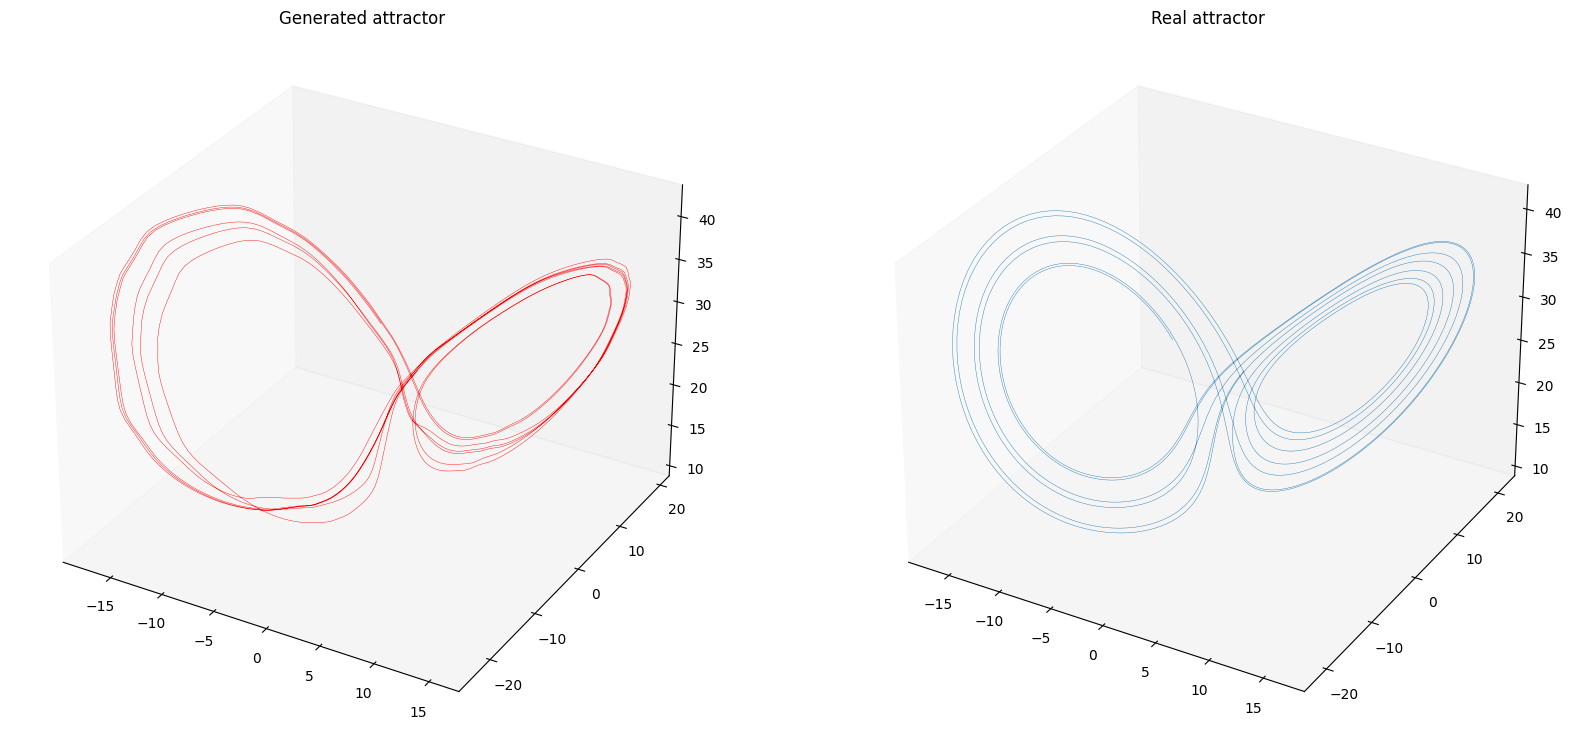

In [32]:
# Initialize reservoir and readout with the best parameters
reservoir = Reservoir(units=500, sr= 0.015354896275663277, lr=0.03542369395119896, input_scaling=0.6, seed=45,input_connectivity=0.7)
readout = Ridge(ridge=1e-7)

# Build the model with the best parameters
model = reservoir >> readout
X_train = X[:train_steps + warm_steps - 1]
Y_train = X[1:train_steps + warm_steps]
 # Assuming Y_test is the actual trajectory obtained previously

model = model.fit(X_train, Y_train)
# Now generate predictions using the trained model
u = X[train_steps + warm_steps]

Y_pred = np.zeros((test_steps-1, readout.output_dim))
for i in range(test_steps-1):
    Y_pred[i, :] = model(u)
    
    u = Y_pred[i, :]


Y_test = X[warm_steps+train_steps:]

print(len(Y_test))
from sklearn.metrics import mean_squared_error
nan_indices = np.argwhere(np.isnan(Y_pred))
print("Indices of NaN values in Y_pred:", nan_indices)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)
print("Shape of Y_pred:", Y_pred.shape)

# Check the range of values in Y_pred
print("Min value of Y_pred:", np.min(Y_pred))
print("Max value of Y_pred:", np.max(Y_pred))

# Check the shape of Y_test
print("Shape of Y_test:", Y_test.shape)
print("Min value of Y_pred:", np.min(Y_test))
print("Max value of Y_pred:", np.max(Y_test))
# Ensure that the plotting code is correctly configured

# Plot the generated attractor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.grid(False)
ax.plot(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], color='red', lw=.3)

# Plot the real attractor
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
ax2.grid(False)
ax2.plot(Y_test[:, 0], Y_test[:, 1], Y_test[:, 2], lw=.3)

plt.show()